In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import os
from pathlib import Path

# function

In [64]:
def reader(result_dir:str) -> pd.DataFrame:
    results = glob.glob(f'{result_dir}/re*.txt')
    run = Path(result_dir).stem[-1]
    result_list = [pd.read_csv(i,header=None) for i in results]
    result = pd.concat(result_list)
    result.columns = [
    "learning rate",
    "weight_decay",
    "Tmax",
    "best score",
    "best auc",
    "best avg auc",
    ]
    return result,run
        
def vis_best_metrics(results,metrics,run=None,figsize = (50, 50),output=False):
    """
    args:
        stats_df：tuple: (dataframe of result, run number)
        metrics: best auc,best score,best avg auc statistical data in different settings of hyperparameter
        run:if results are pd.DataFrame, assign run manually for correct saving of output figs. specially used in result 1-3
    """
    assert metrics in ['best auc','best score','best avg auc'], "metrics should be choosen from ['best auc','best score','best avg auc']"
    if type(results) == pd.DataFrame:
        stats_df = results
        run = run
    elif type(results) == tuple:
        stats_df,run = results
    else:
        raise TypeError('type of results should be pd.DataFrame or tuple')
    labels_lr = [str(i) for i in np.sort(stats_df["learning rate"].unique())]
    labels_wd = [str(i) for i in np.sort(stats_df["weight_decay"].unique())]
    labels_Tmax = [str(i) for i in np.sort(stats_df["Tmax"].unique())]
    auc_list = []
    score_list = []
    avg_auc_list = []
    # NOTE:auc/score/avg_auc_list is wrongly named, they have no relation with names but only a recorder of metrics for different hyperparameters seperately
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i in labels_lr:
        lr = eval(i)
        auc_list.append(stats_df[stats_df["learning rate"] == lr][metrics])
    axes[0].boxplot(auc_list, labels=labels_lr)
    axes[0].set_xlabel("learning rate")
    axes[0].set_ylabel(metrics)
    for i in labels_wd:
        wd = eval(i)
        score_list.append(stats_df[stats_df["weight_decay"] == wd][metrics])
    axes[1].boxplot(score_list, labels=labels_wd)
    axes[1].set_xlabel("weight_decay")
    axes[1].set_ylabel(metrics)
    for i in labels_Tmax:
        Tmax = eval(i)
        avg_auc_list.append(stats_df[stats_df["Tmax"] == Tmax][metrics])
    axes[2].boxplot(avg_auc_list, labels=labels_Tmax)
    axes[2].set_xlabel("Tmax")
    axes[2].set_ylabel(metrics)
    if output:
        plt.savefig(f'./mil classifier/hyperparam_select_batch_{run}/{metrics}.png')
    print(stats_df[metrics].describe())
    
def top_comb(results,metrics,top=10):
    '''
    get hyperparameter combinations that reach top N auc/score/avg auc
    args:
        results:get from reader function
        metrics: choose from [best auc,best score,best avg auc]
        top: get top N combinations, 10 by default
    return:
        3 list containing best hyperparameter combinations ---- best_auc_comb,best_score_comb,best_avg_auc_comb
        each list is composed of a tuple:(comb:series,value of metric)
        here is an example:
            ((
            learning rate    0.000920
            weight_decay     0.000005
            Tmax             50.000000
            Name: 343, dtype: float64
            ),metric:1.2994971264367816)
    '''
    if type(results) == pd.DataFrame:
        stats_df = results
    elif type(results) == tuple:
        stats_df,_ = results
    else:
        raise TypeError('type of results should be pd.DataFrame or tuple')
    top_df = stats_df.sort_values([metrics],ascending = False).head(10)
    col_index_dict = {
        'best score':3,
        'best auc':4,
        'best avg auc':5
    }
    best_comb = [(top_df.iloc[i,:3],top_df.iloc[i,col_index_dict[metrics]]) for i in range(top)]
    return best_comb

def view_boosting(results,title,figsize=(15,30),output=False):
    '''
    resutls:get from reader function,a list of result, must be arranged in correct order
    title:choose from ['simclr','pretrained Res18','pretrained Res50']
    '''
    best_auc_list = [__extract_metrics(top_comb(result,'best auc')) for result in results]
    best_score_list = [__extract_metrics(top_comb(result,'best score')) for result in results]
    N_auc = len(best_auc_list)
    N_score = len(best_score_list)
    fig,axes = plt.subplots(1,2,figsize = figsize)
    if title:
        fig.suptitle(title)
    b0=axes[0].boxplot(best_auc_list,labels = ['trial 1','trial 2','trial 3'][:N_auc],patch_artist=True)
    for patch, color in zip(b0['boxes'], ['coral','orange','yellow'][:N_auc]):
        patch.set_facecolor(color)
    axes[0].set_title('best auc')
    
    b1=axes[1].boxplot(best_score_list,labels = ['trial 1','trial 2','trial 3'][:N_score],patch_artist=True)
    for patch, color in zip(b1['boxes'], ['coral','orange','yellow'][:N_score]):
        patch.set_facecolor(color)
    axes[1].set_title('best score')
    if output:
        save_dir = '../out/5_classifier/classifier_comparison'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir,exist_ok=True)
        plt.savefig(f'../out/5_classifier/classifier_comparison/{title}.png')
    print(f'pic saved at :/out/5_classifier/classifier_comparison/{title}.png')

def __extract_metrics(top_comb):
    metrics = [i[1] for i in top_comb]
    return metrics

# results for the 1st trial

In [5]:
result_ser = pd.read_csv("./mil classifier/hyperparam_select_batch_1/reselts.txt", header=None)
result_ser.columns = [
    "learning rate",
    "weight_decay",
    "Tmax",
    "best score",
    "best auc",
    "best avg auc",
]
result_star = pd.read_csv("./mil classifier/hyperparam_select_batch_1/reselts_star.txt", header=None)
result_star.columns = [
    "learning rate",
    "weight_decay",
    "Tmax",
    "best score",
    "best auc",
    "best avg auc",
]

In [6]:
result = pd.concat([result_ser, result_star])

count    1800.000000
mean        0.515311
std         0.074492
min         0.410417
25%         0.418750
50%         0.537500
75%         0.568750
max         0.714583
Name: best auc, dtype: float64


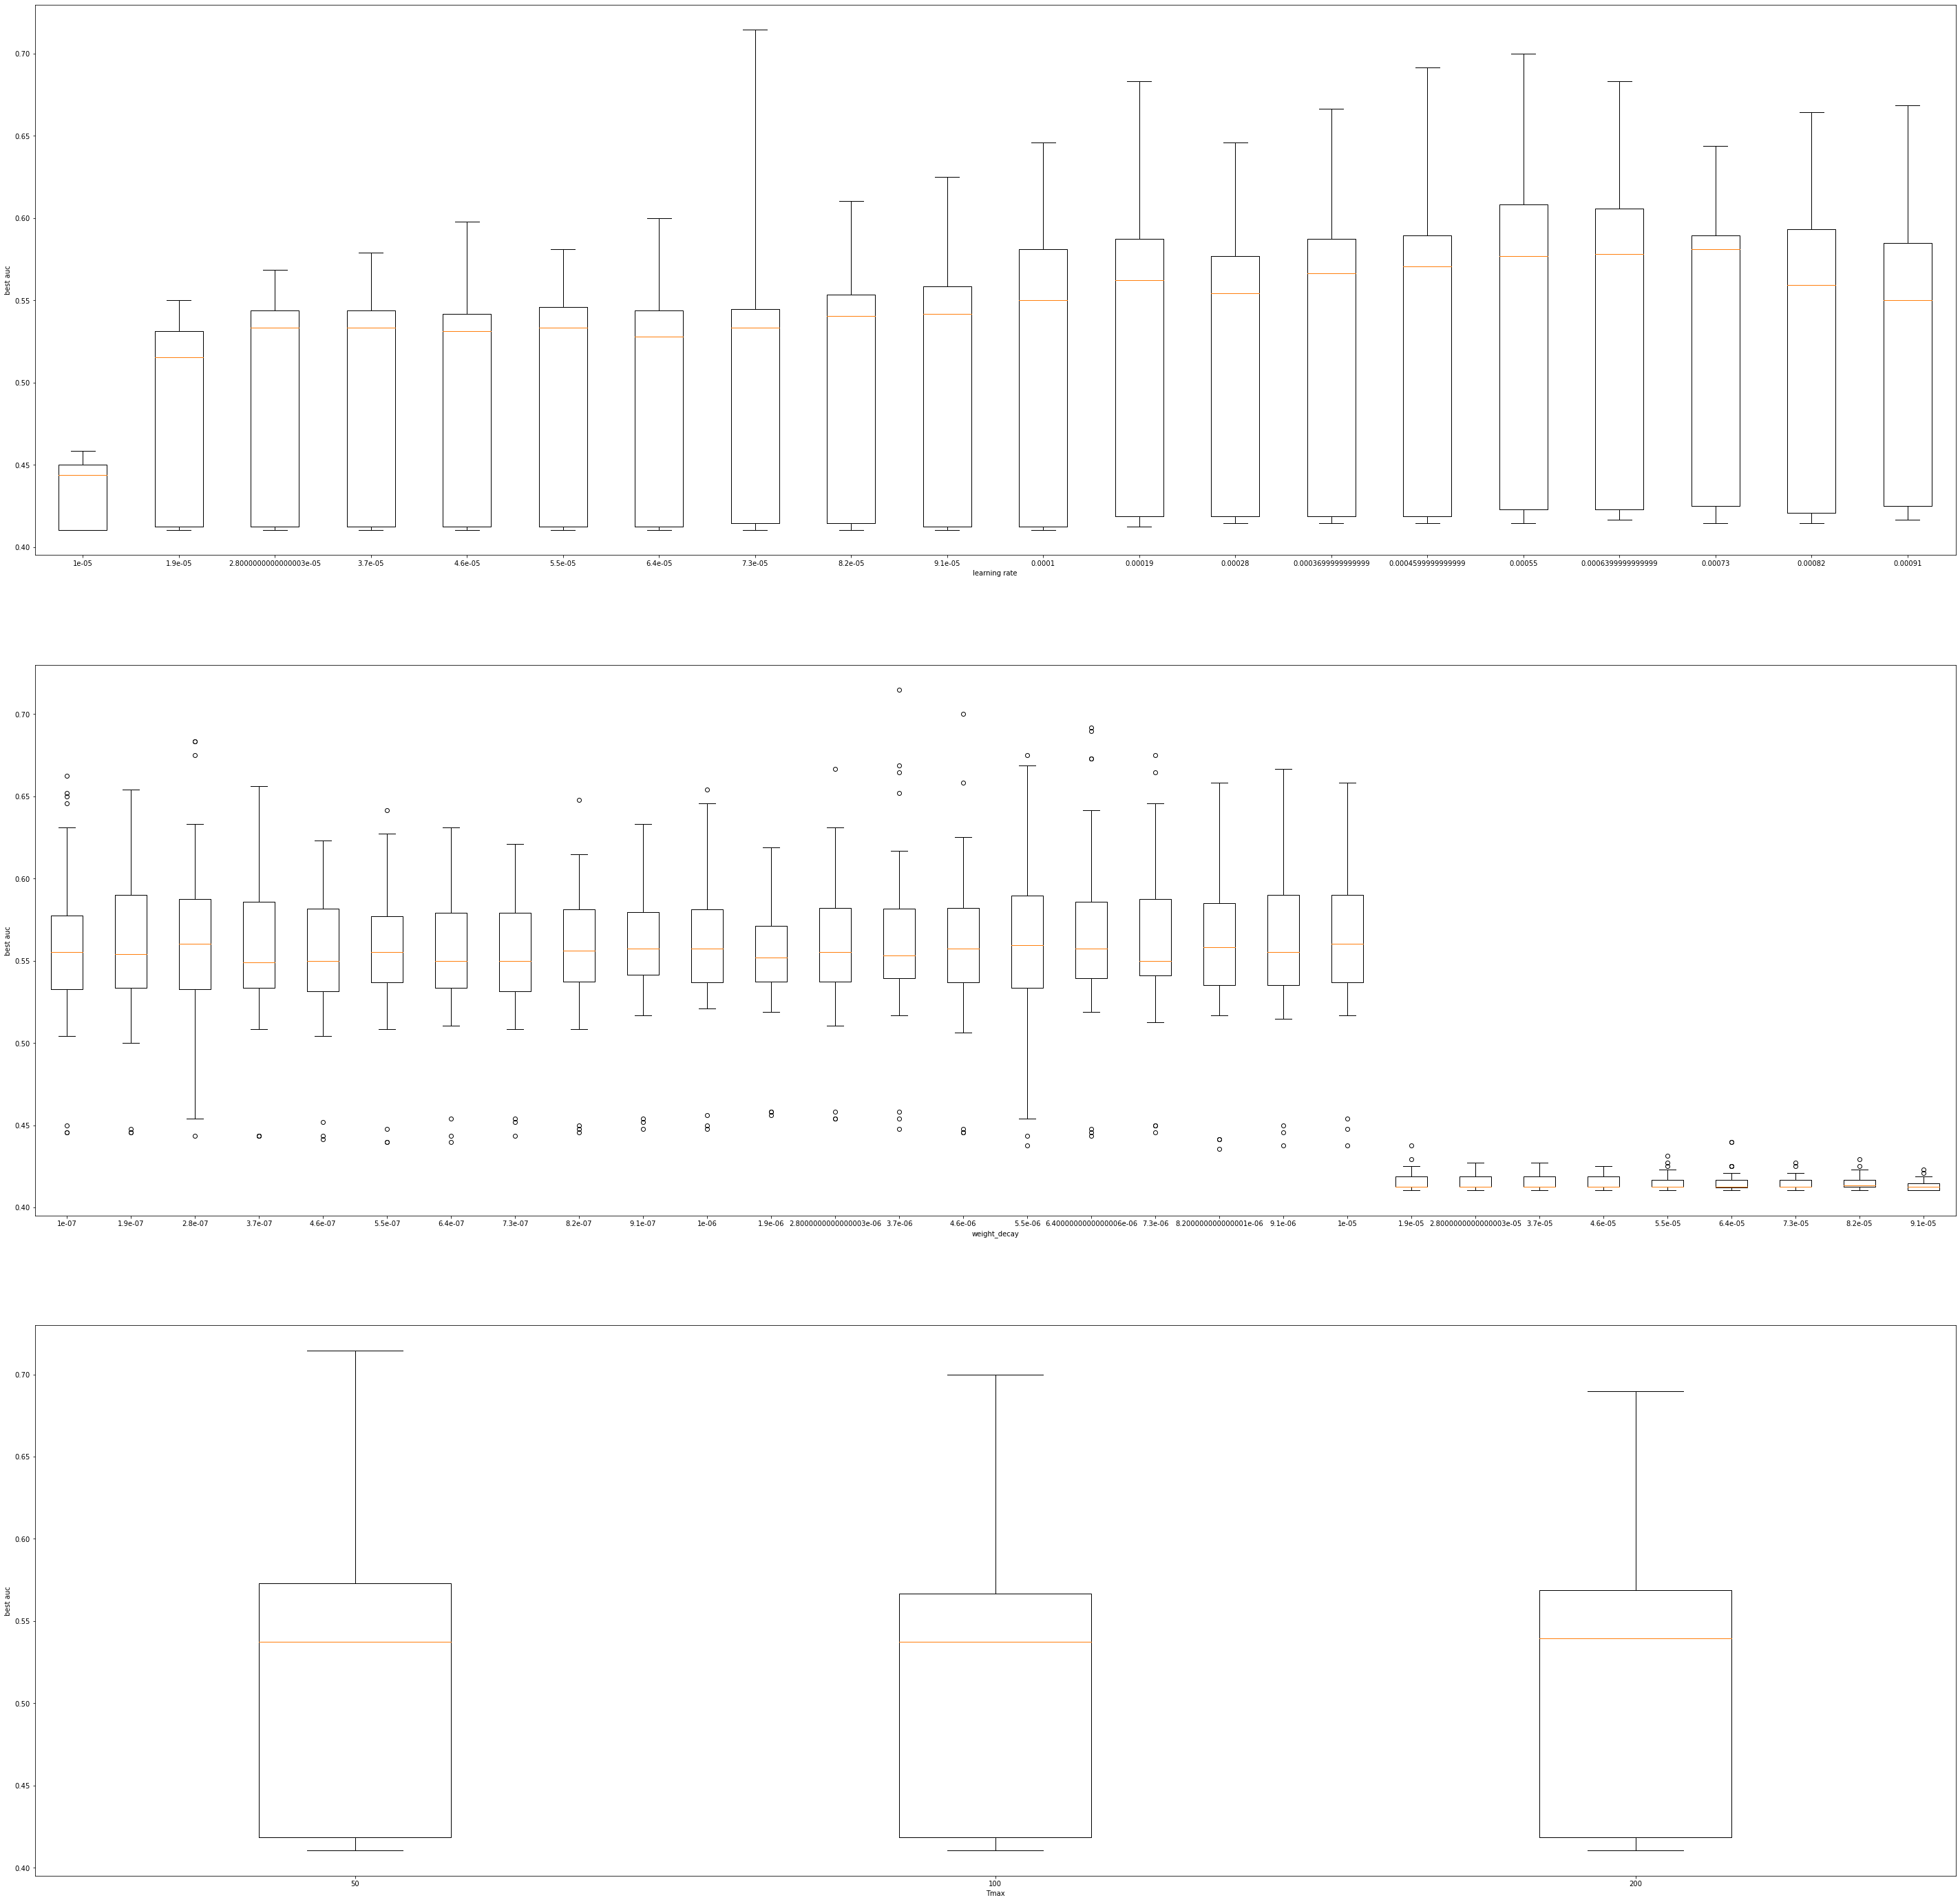

In [8]:
# vis_best_metrics(result, "best auc",run=1,output=True)

count    1800.000000
mean        0.898358
std         0.045206
min         0.801545
25%         0.855460
50%         0.910740
75%         0.928161
max         1.084339
Name: best score, dtype: float64


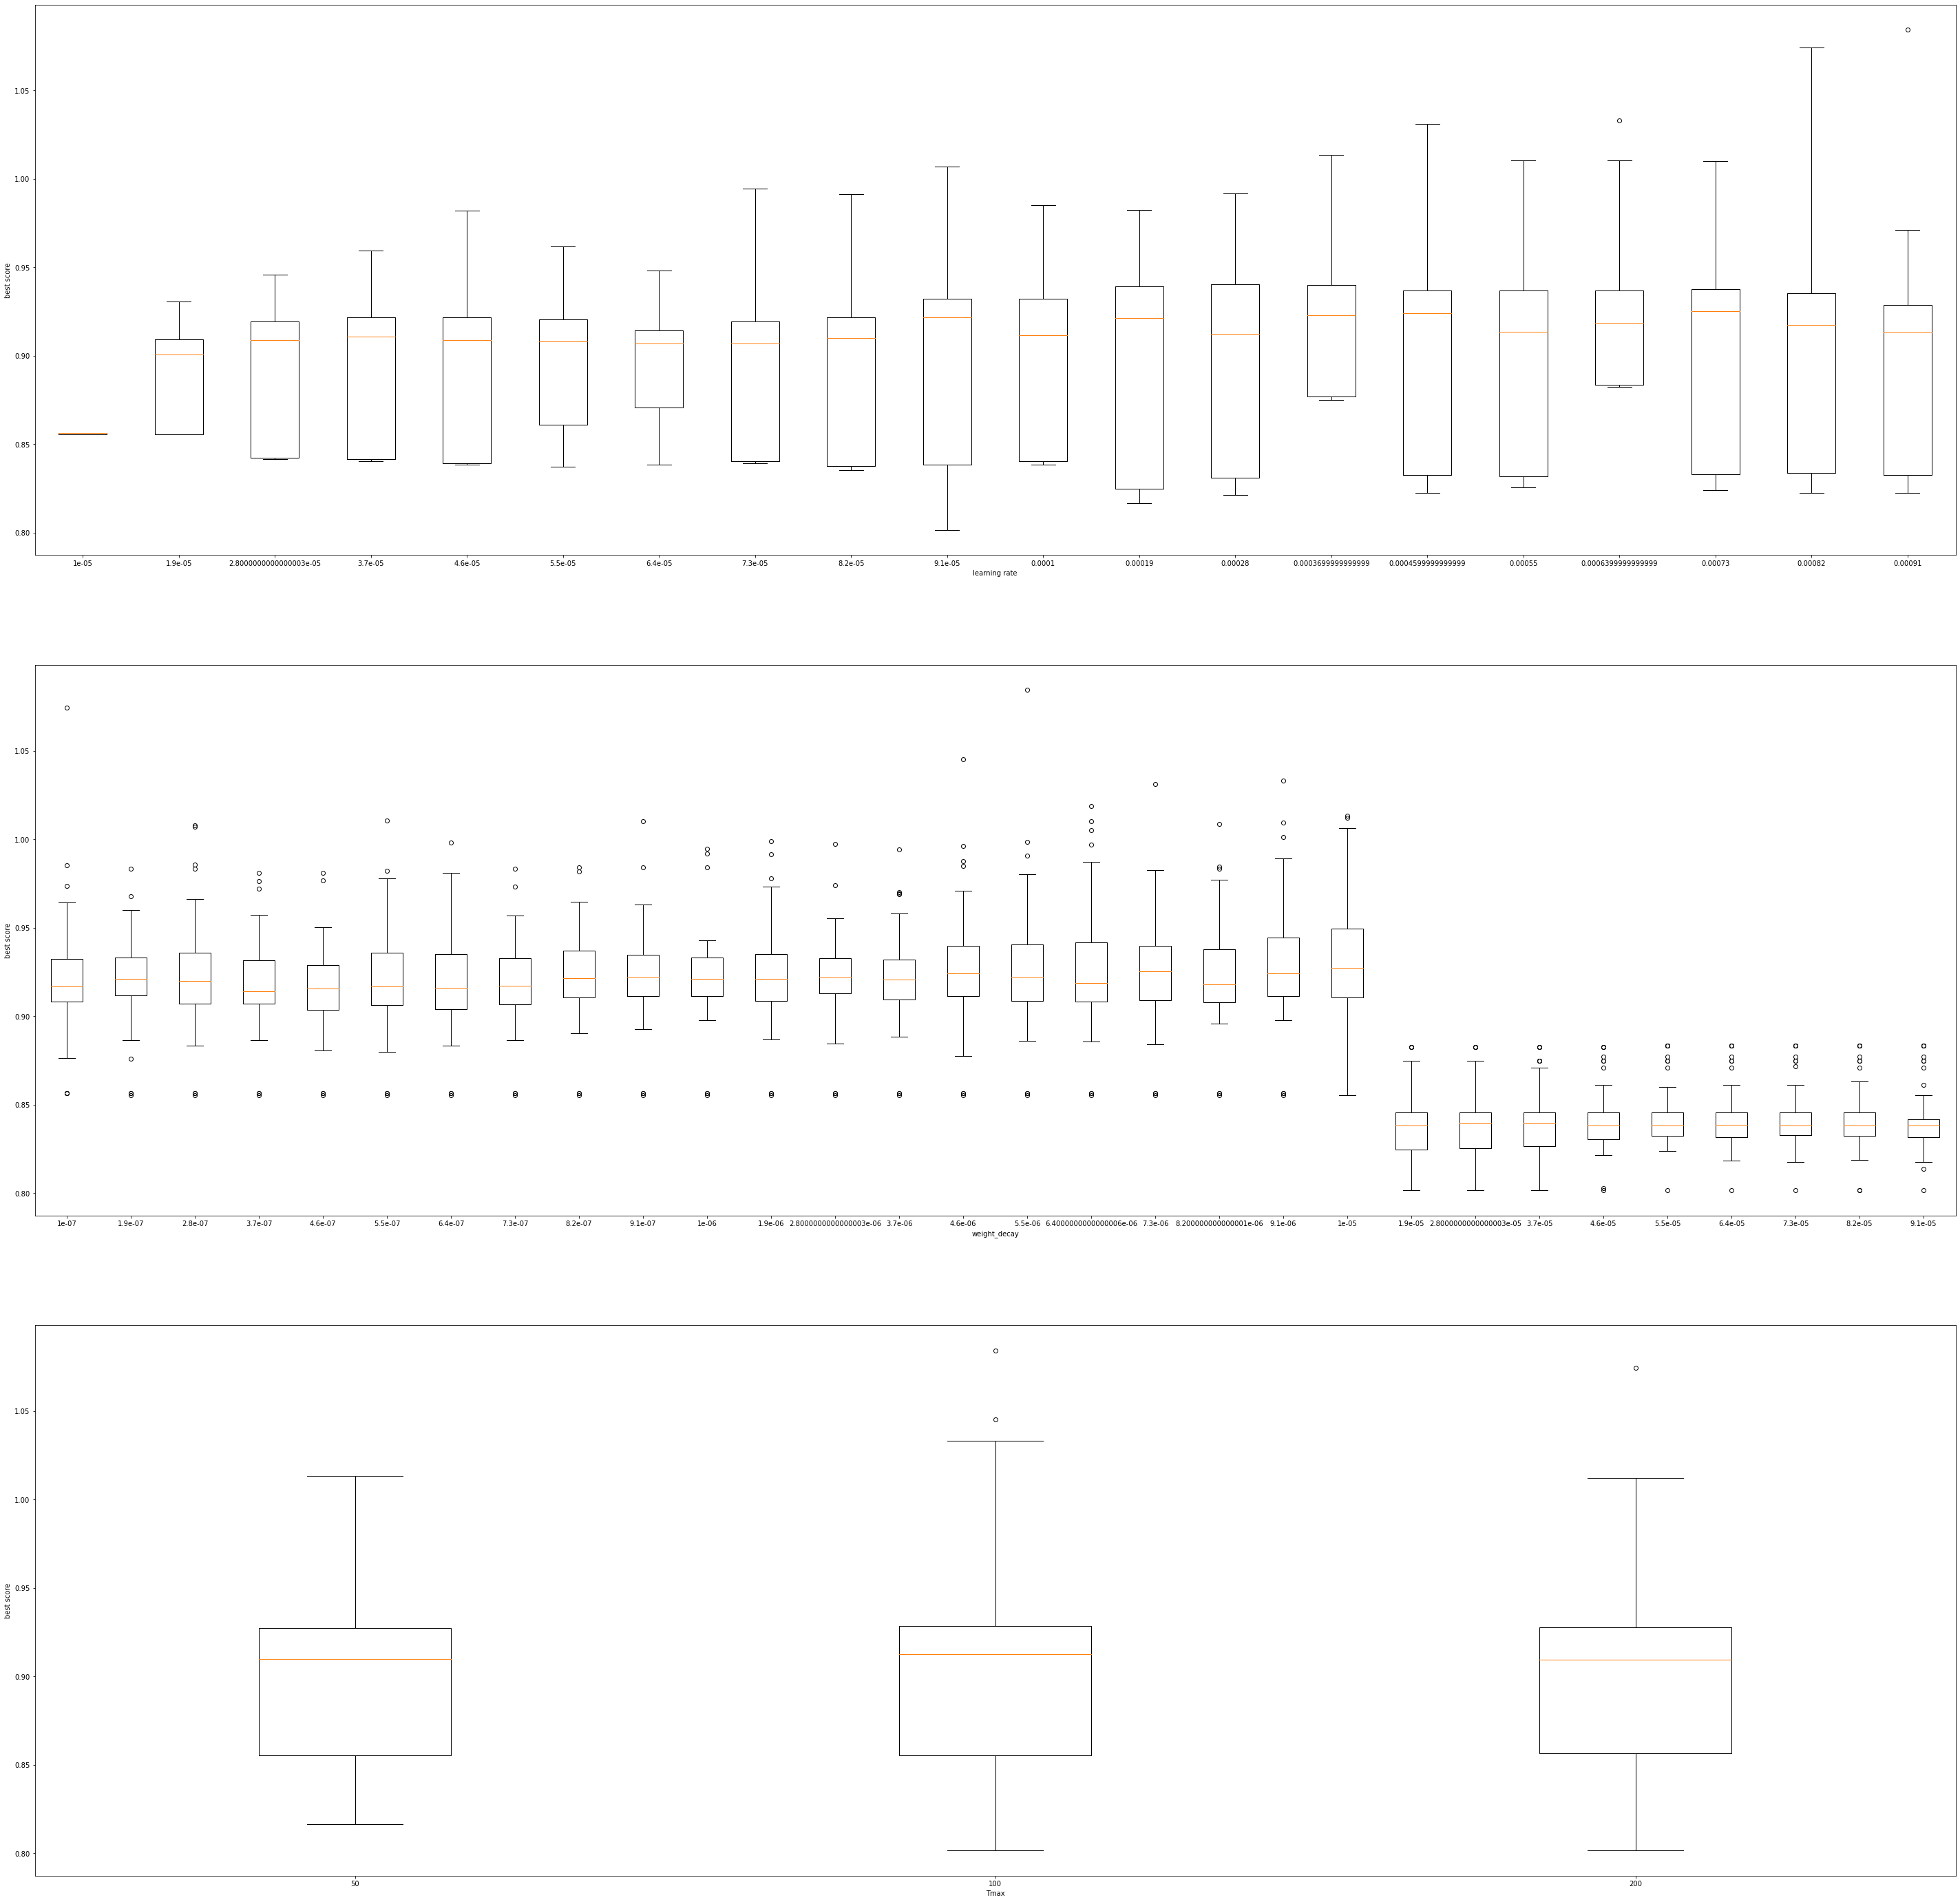

In [9]:
# vis_best_metrics(result, "best score",run=1,output=True)

## summary of 1st trial：
lr：6.4e-5 ~ 8.2e-5 ,1e-4 ~2.8e-4, 4.5e-4 ~ 4.3e-4, 1e-3~1e-2

weight_decay 1e-6 ~ 1e-5相差不大,1e-7~4.6e-7, 2.8e-6~ 6.4e-6, 8.2e-6 ~ 1e-5,

Tmax: 50

# results of 2nd trial

In [10]:
result2 = pd.read_csv("./mil classifier/hyperparam_select_batch_2/results_2.txt", header=None)
result2.columns = [
    "learning rate",
    "weight_decay",
    "Tmax",
    "best score",
    "best auc",
    "best avg auc",
]

count    1200.000000
mean        0.573924
std         0.041578
min         0.431250
25%         0.543750
50%         0.564583
75%         0.597917
max         0.747917
Name: best auc, dtype: float64


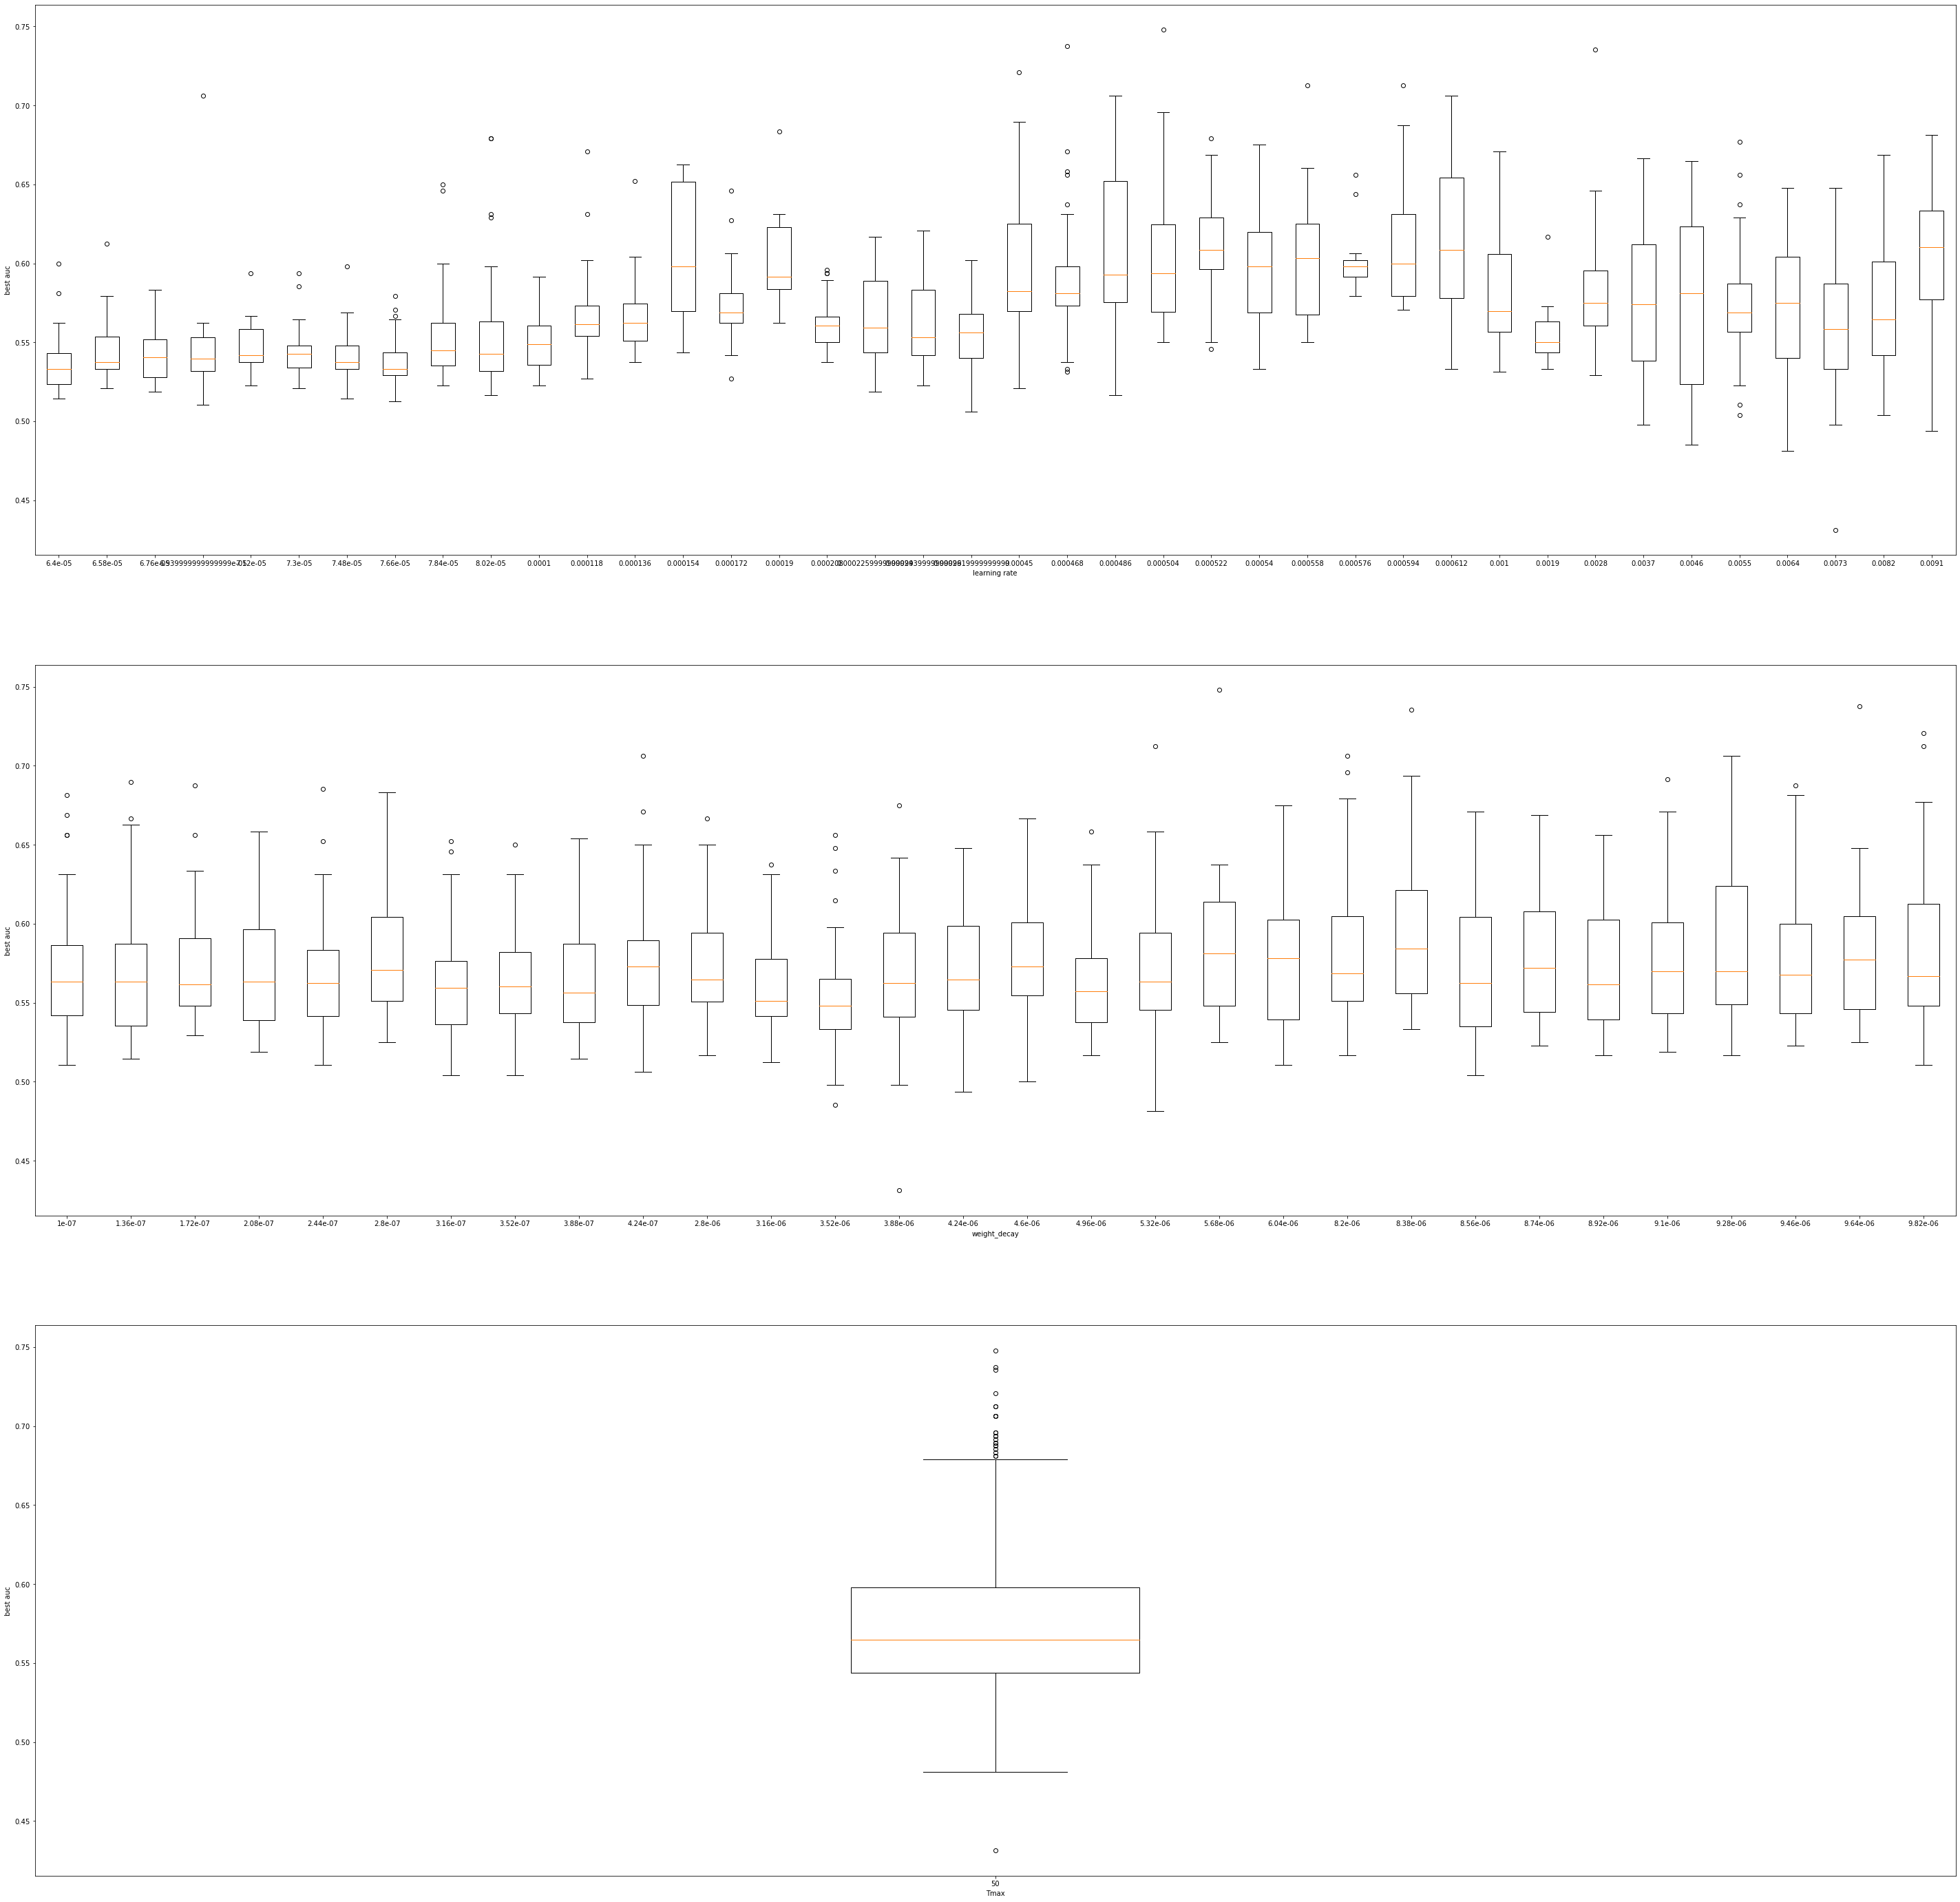

In [203]:
# vis_best_metrics(result2, "best auc",run=2,output=True)

count    1200.000000
mean        0.938442
std         0.037937
min         0.833585
25%         0.914152
50%         0.929490
75%         0.952344
max         1.134339
Name: best score, dtype: float64


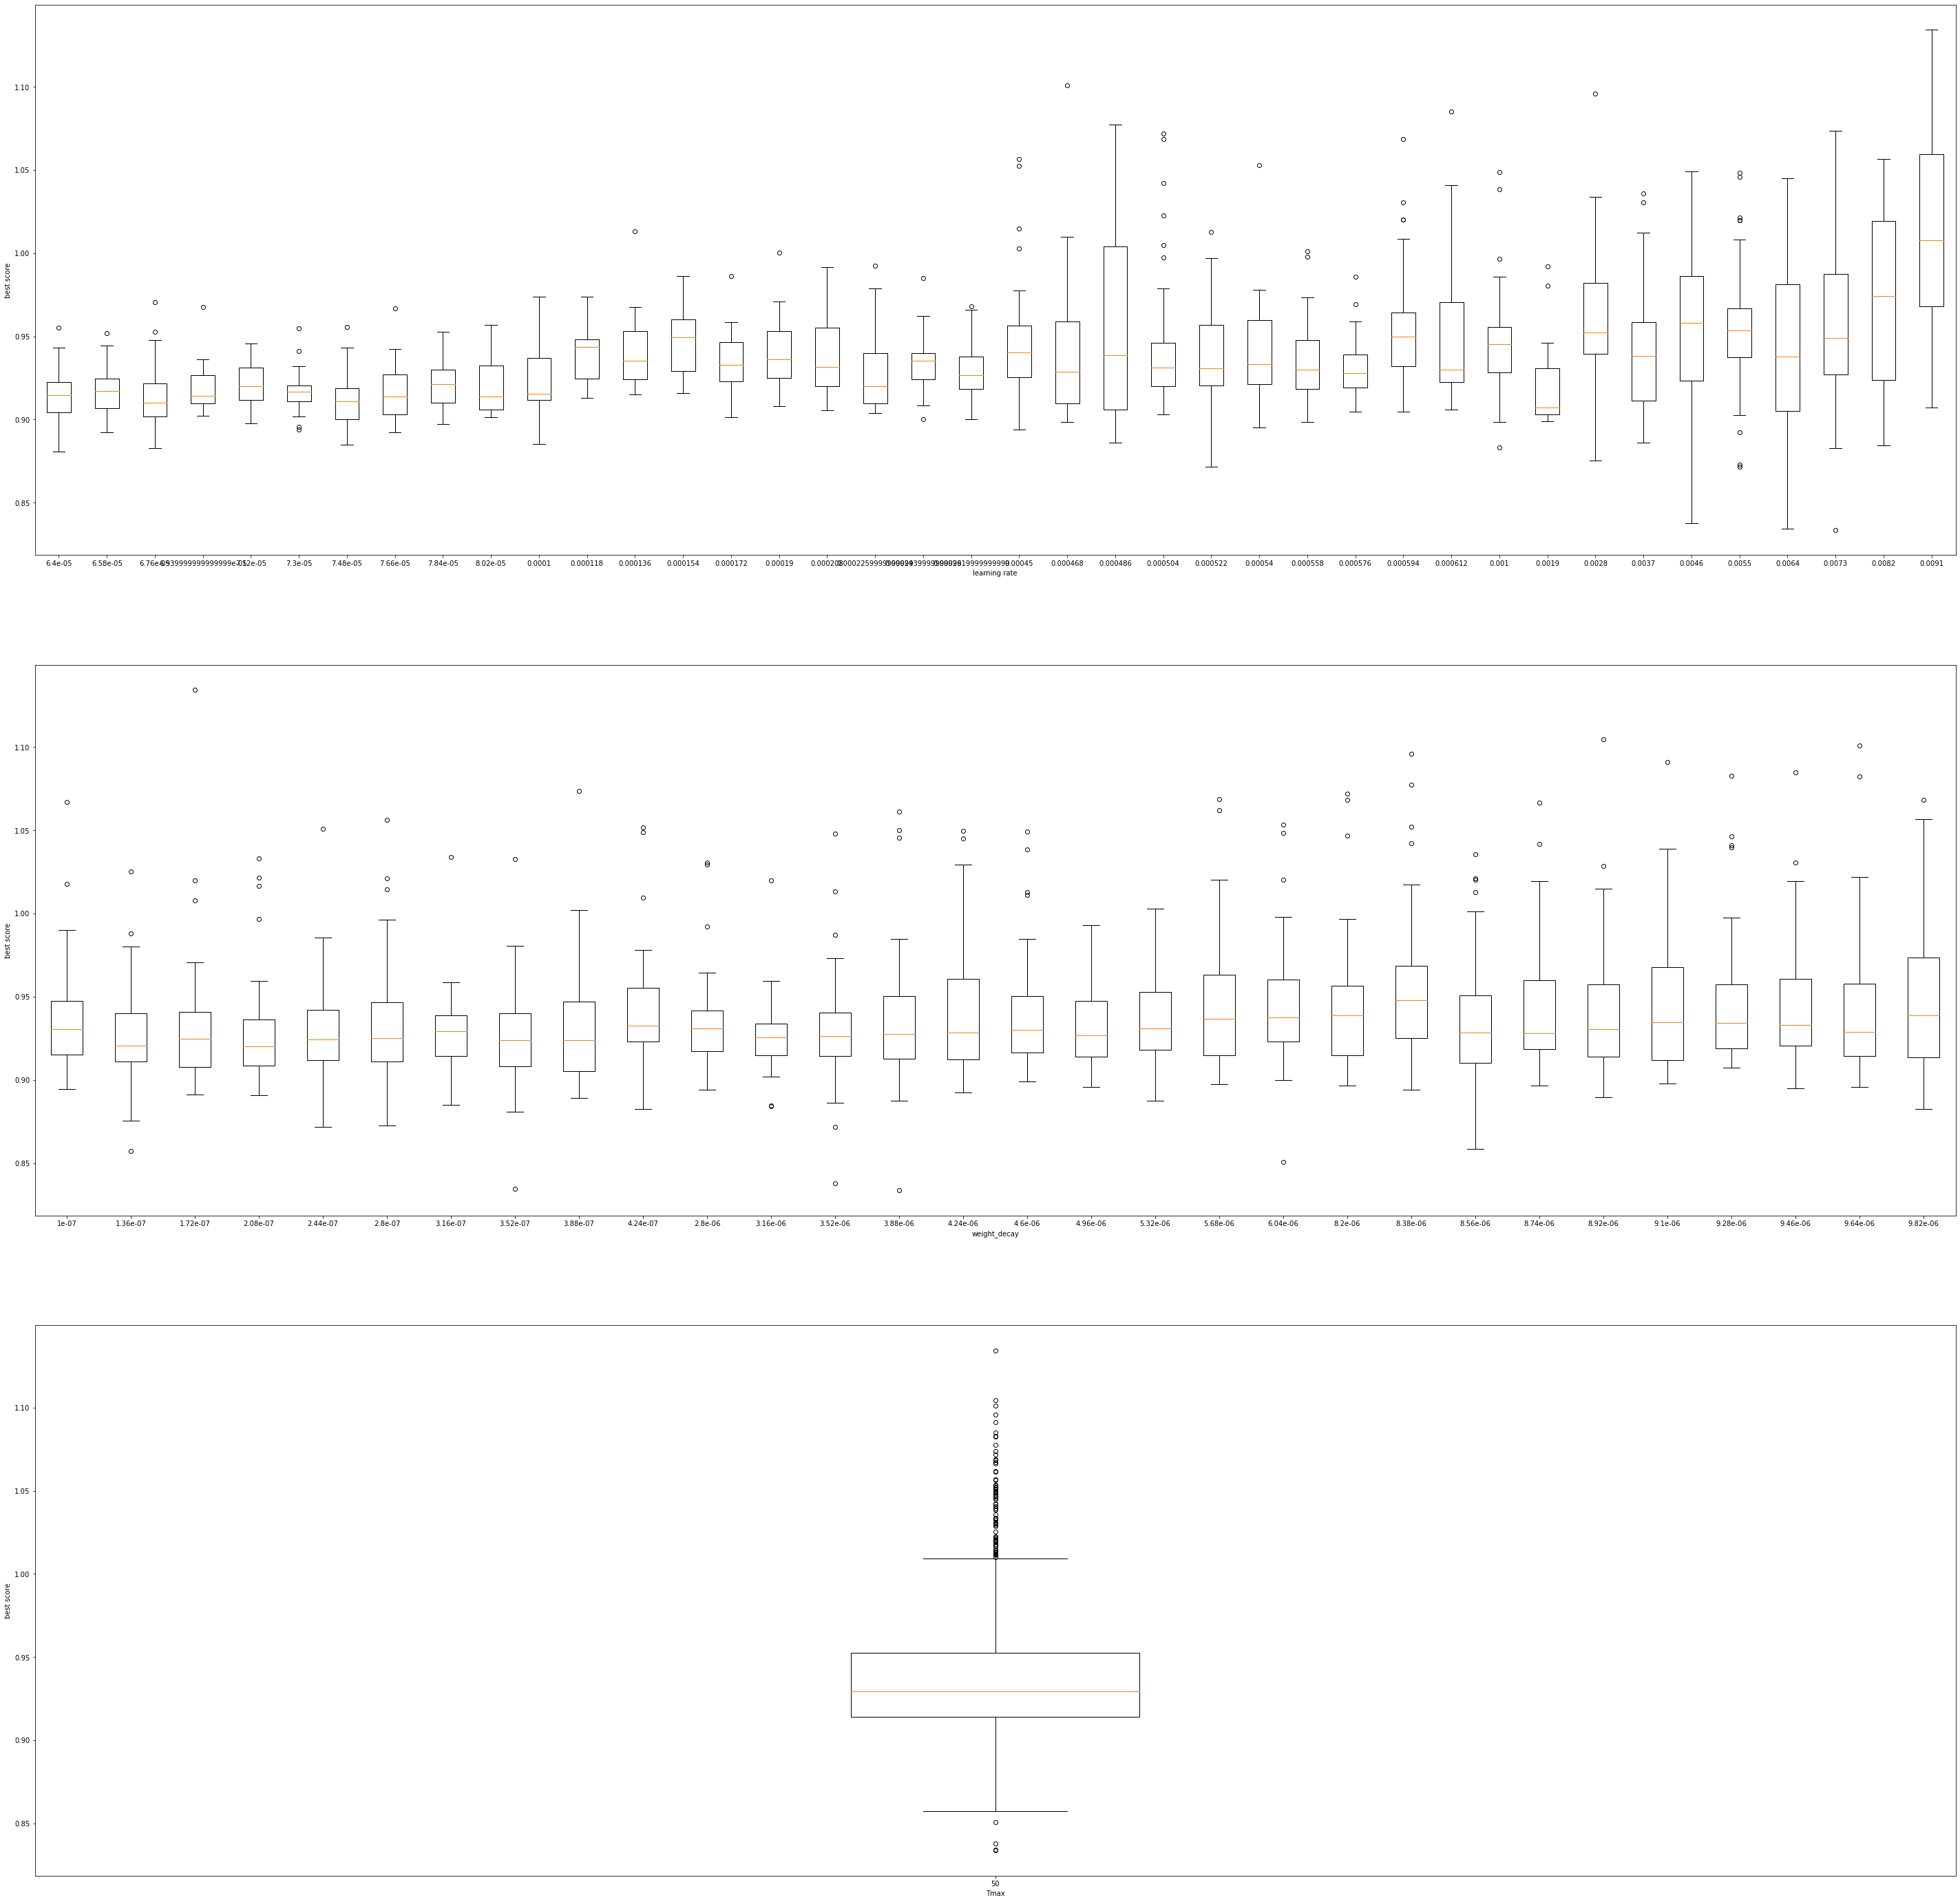

In [204]:
# vis_best_metrics(result2, "best score",run=2,output=True)

## summary of 2nd trial:

lr:(4e-4,5.2e-4)(8.2e-3,0.015)(5.5e-4,6.1-4)(1.9e-3,3.7e-3)

wd:(5.32e-6,8.38e-6)(9.3e-6,9.9-e6)(8.74e-6,9.1e-6)(1.36e-7,2.08e-7)

# results of 3rd trial

In [11]:
result3 = pd.read_csv("./mil classifier/hyperparam_select_batch_3/results_3.txt", header=None)
result3.columns = [
    "learning rate",
    "weight_decay",
    "Tmax",
    "best score",
    "best auc",
    "best avg auc",
]

count    7200.000000
mean        0.612684
std         0.061702
min         0.422917
25%         0.566667
50%         0.604167
75%         0.656250
max         0.837500
Name: best auc, dtype: float64


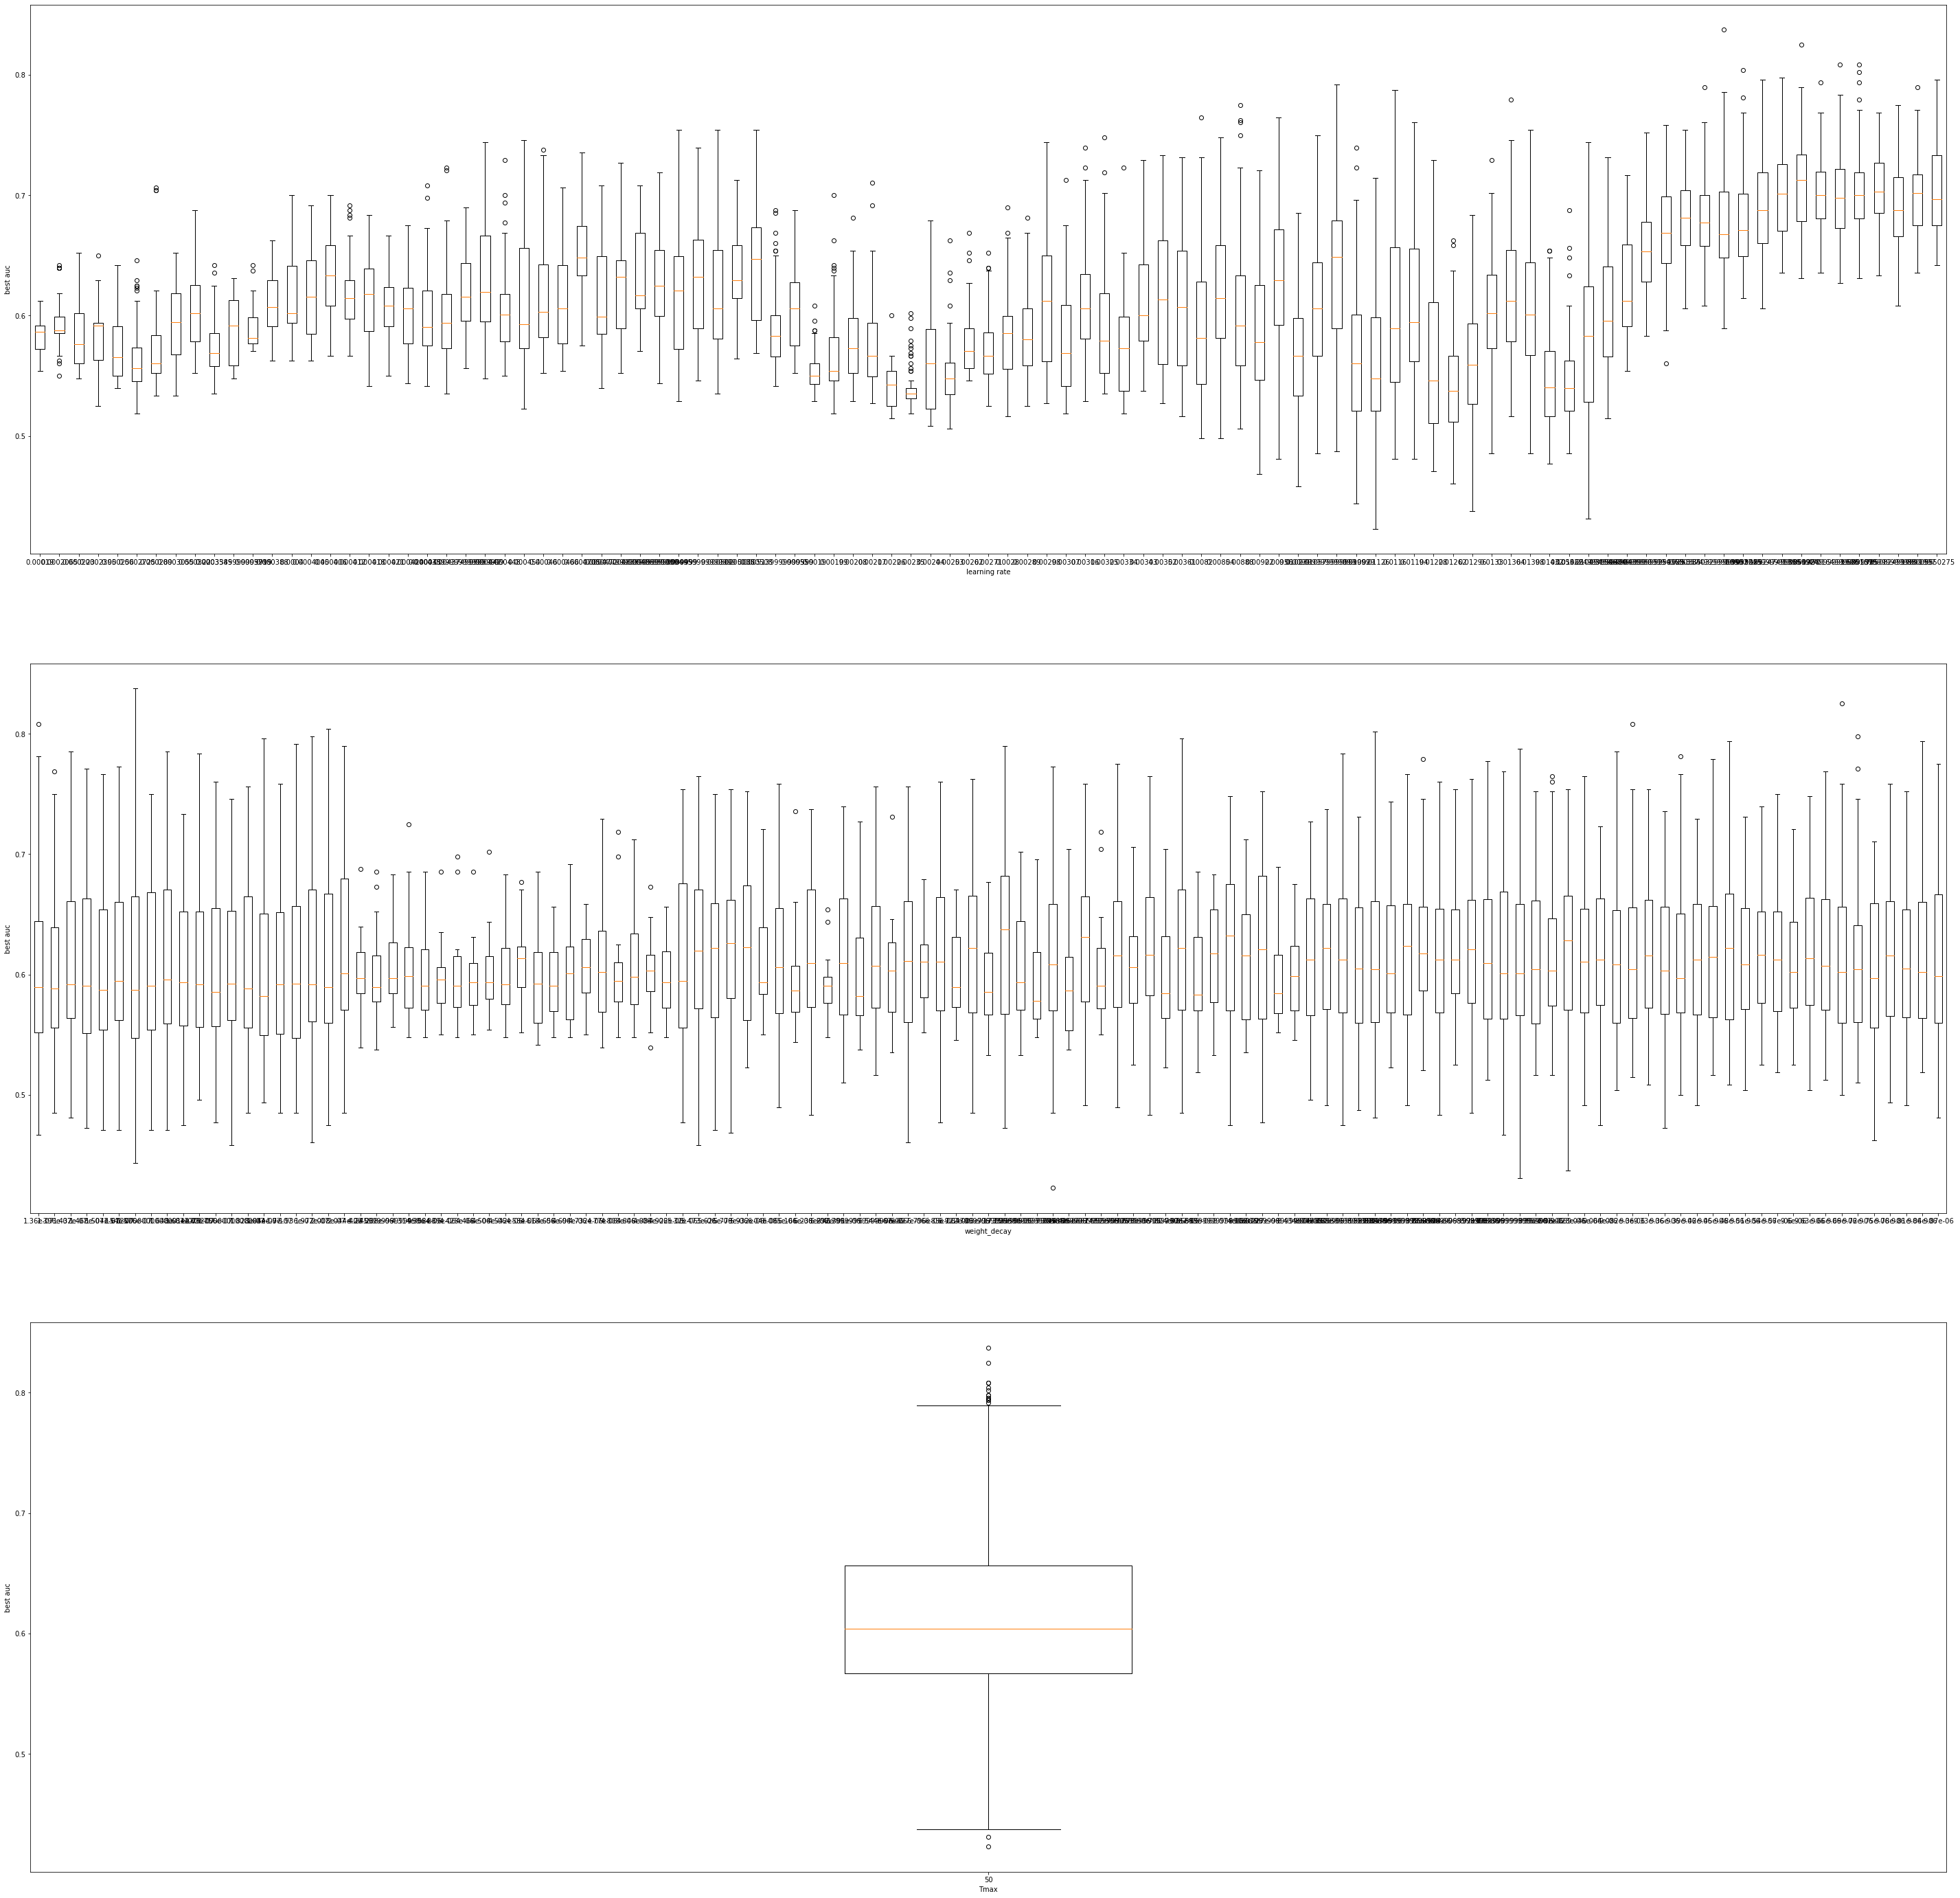

In [201]:
# vis_best_metrics(result3, "best auc",run=3,output=True)

count    7200.000000
mean        0.982359
std         0.062444
min         0.813757
25%         0.933369
50%         0.968409
75%         1.028942
max         1.221839
Name: best score, dtype: float64


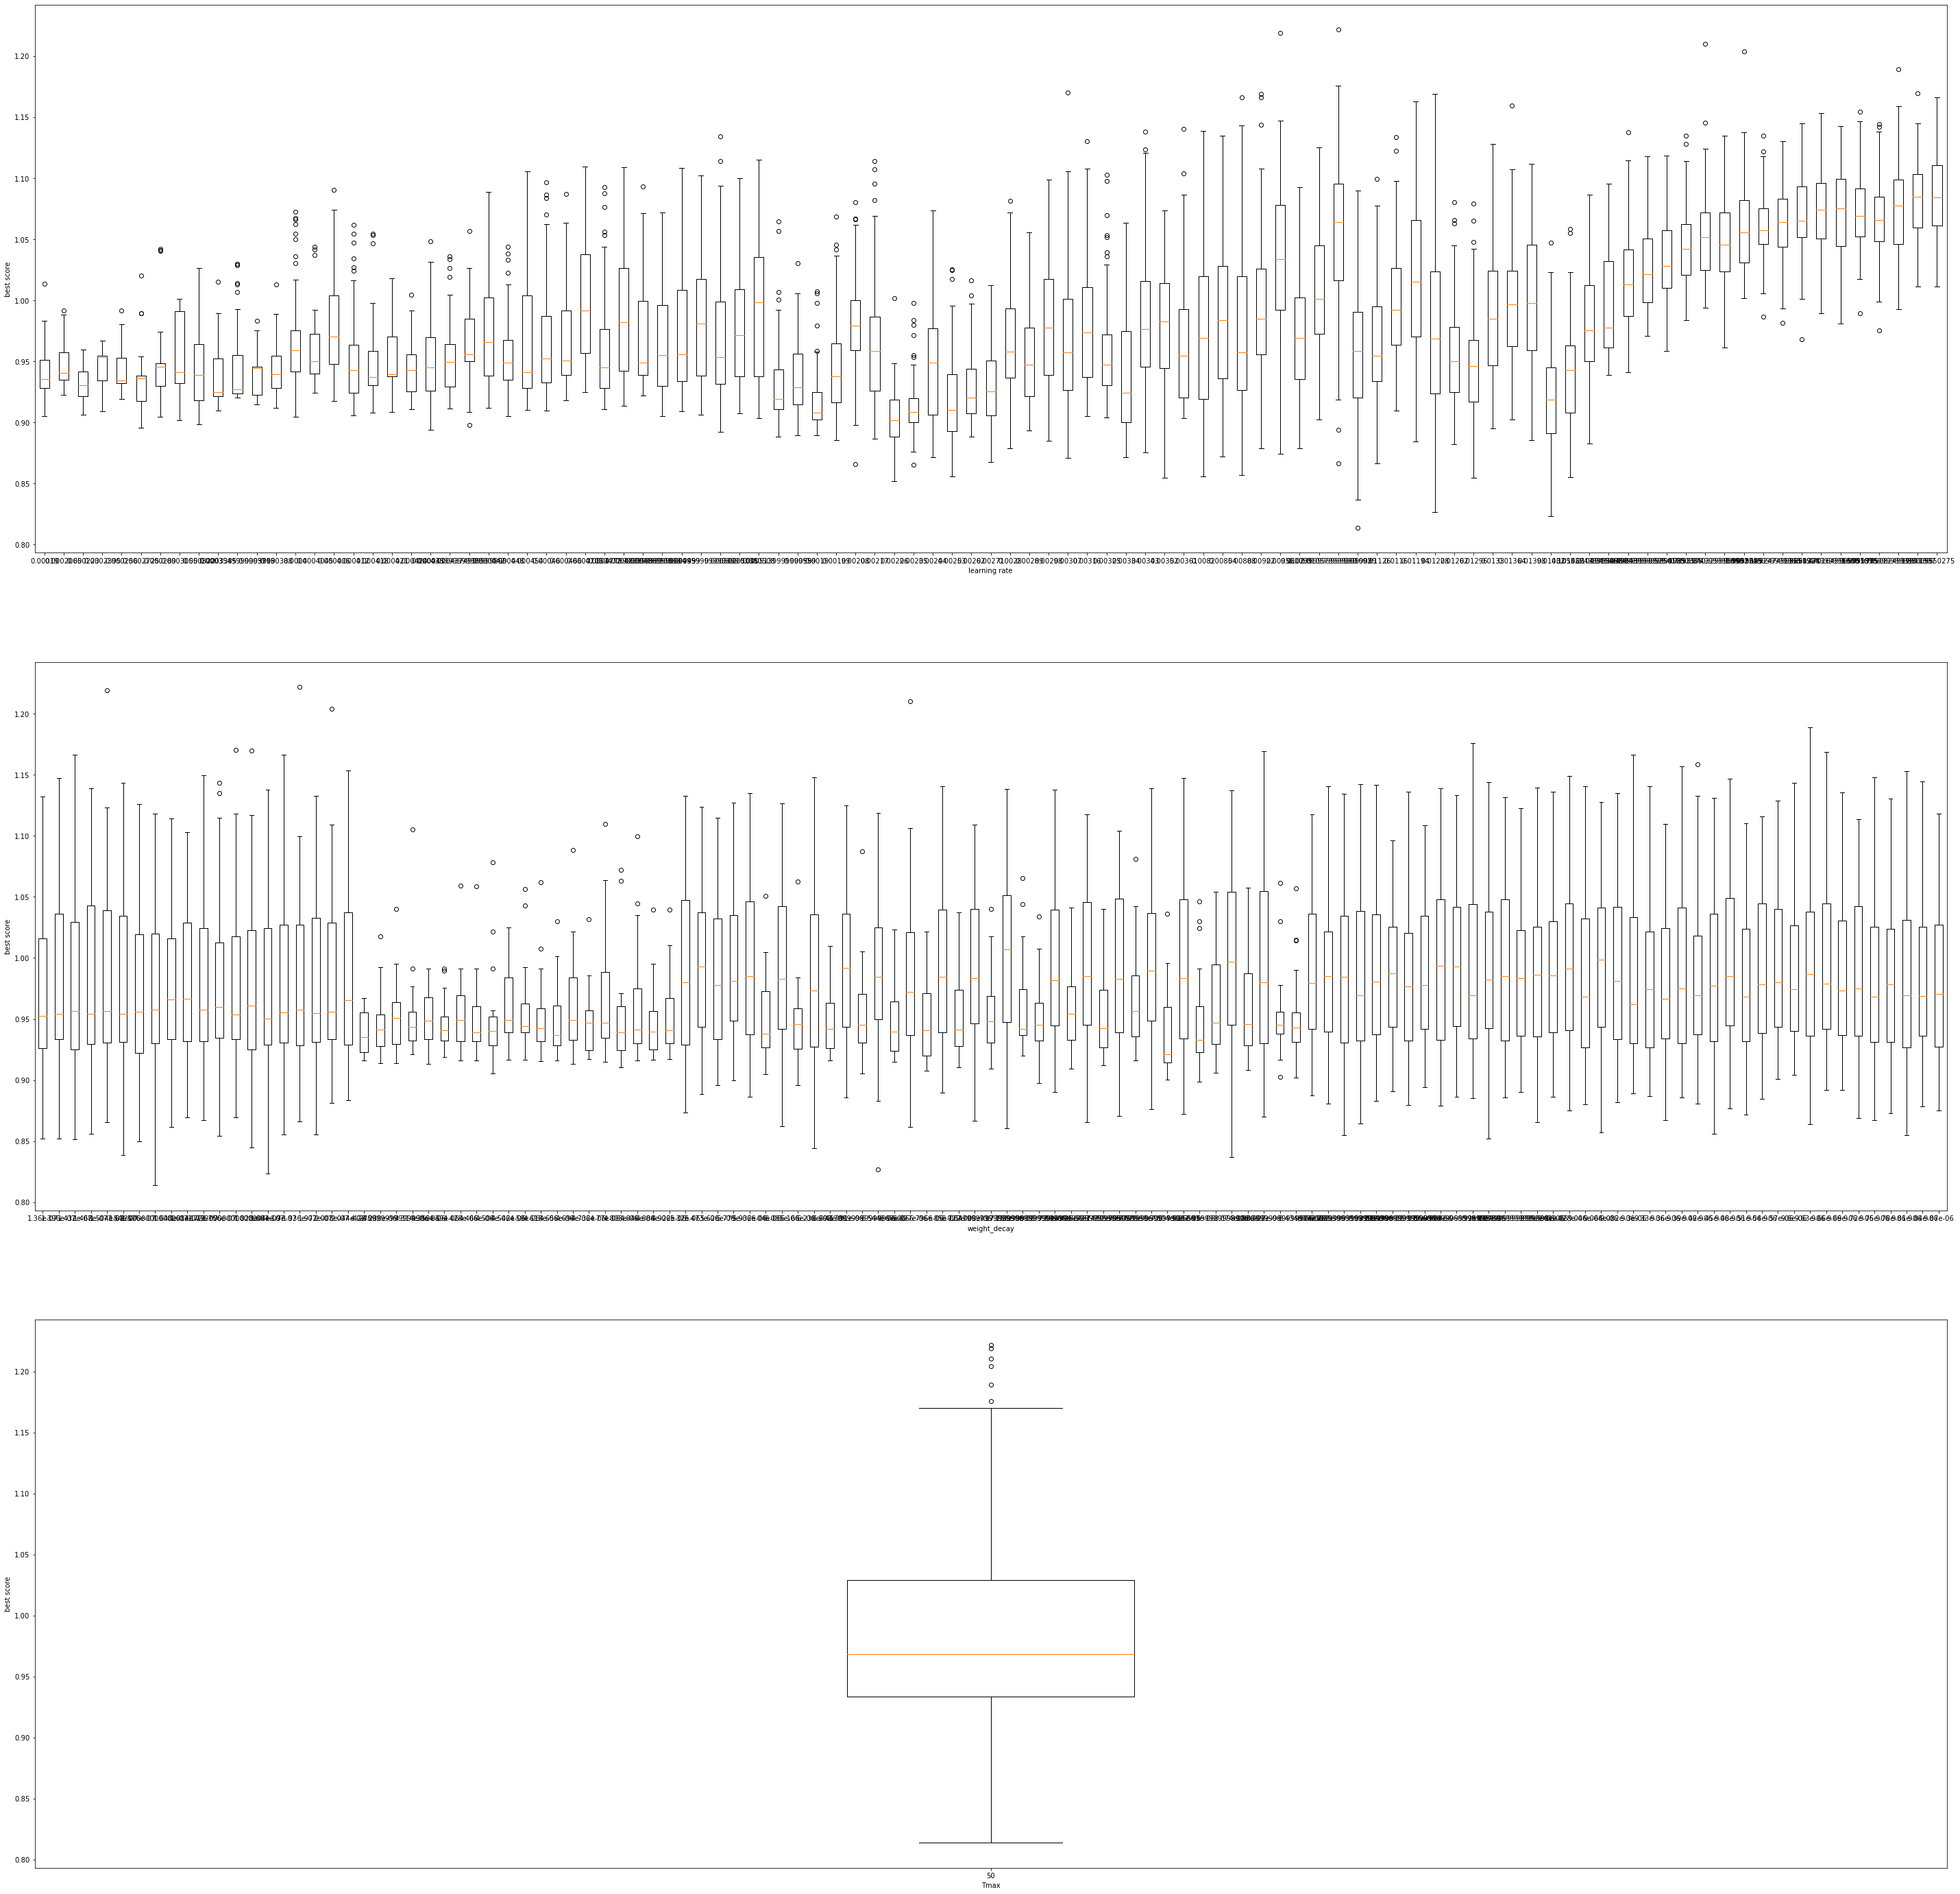

In [202]:
# vis_best_metrics(result3, "best score",run=3,output=True)

## summary of trial 3
lr:

In [12]:
result_ser_3 = pd.read_csv("./mil classifier/hyperparam_select_batch_3/results_3.txt", header=None)
result_ser_3.columns = [
    "learning rate",
    "weight_decay",
    "Tmax",
    "best score",
    "best auc",
    "best avg auc",
]
result_star_3 = pd.read_csv("./mil classifier/hyperparam_select_batch_3/results_star_3.txt", header=None)
result_star_3.columns = [
    "learning rate",
    "weight_decay",
    "Tmax",
    "best score",
    "best auc",
    "best avg auc",
]
result3 = pd.concat([result_ser_3, result_star_3])

count    7200.000000
mean        0.612684
std         0.061702
min         0.422917
25%         0.566667
50%         0.604167
75%         0.656250
max         0.837500
Name: best auc, dtype: float64


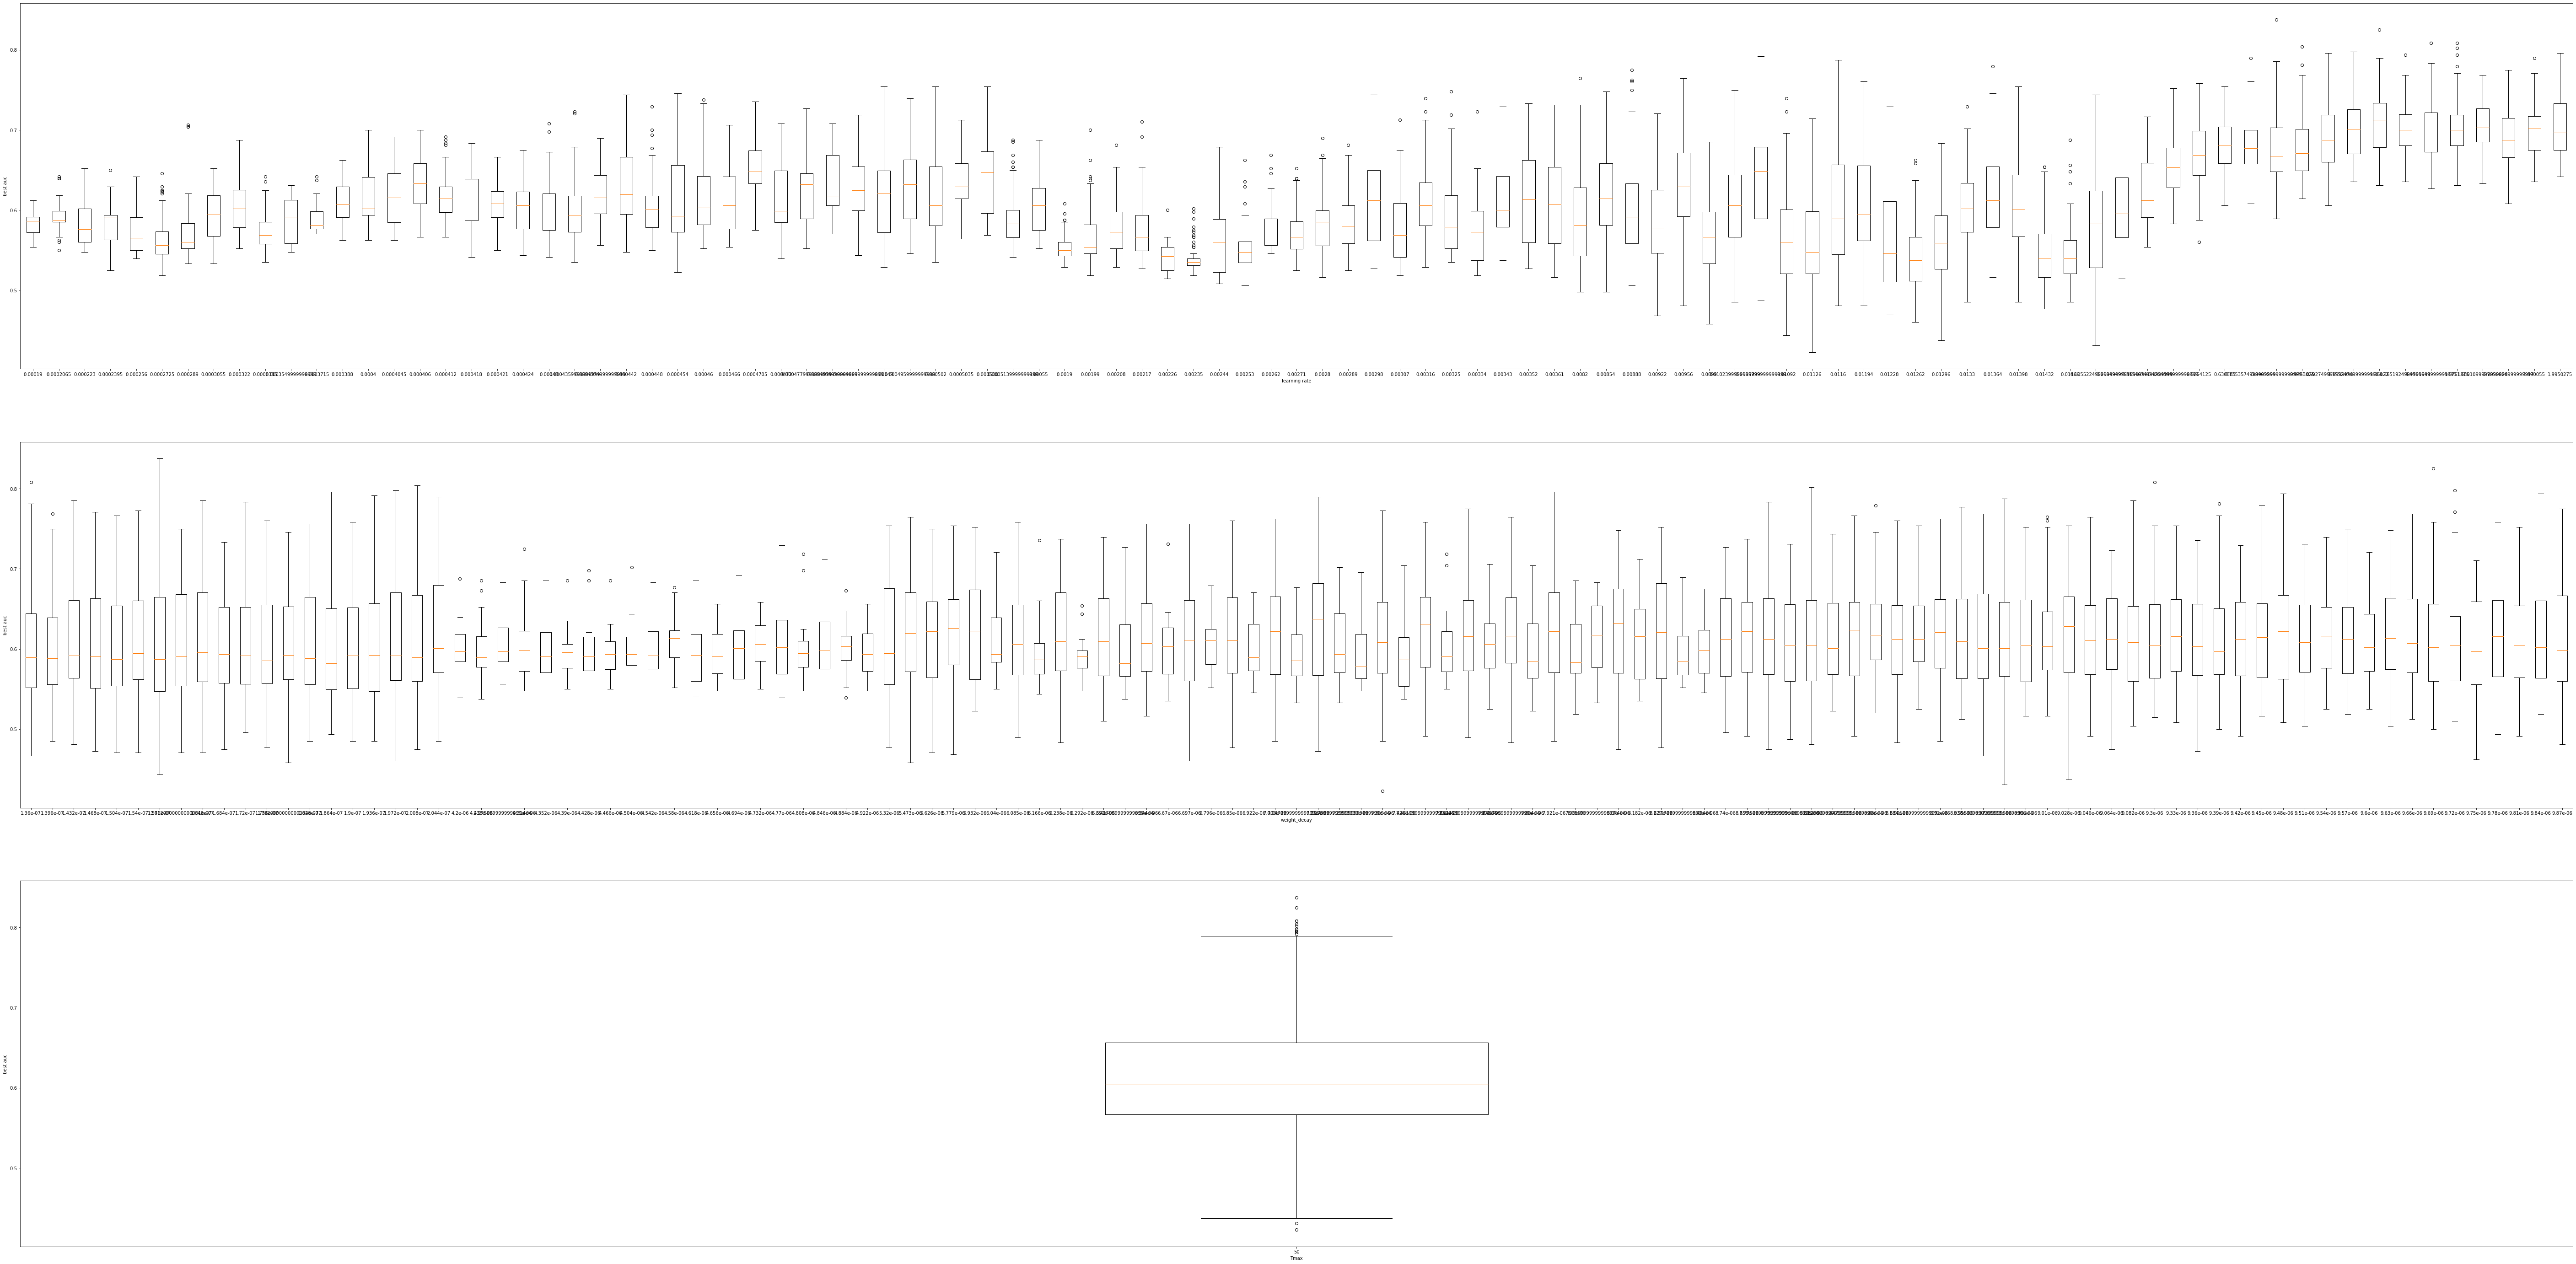

In [116]:
# vis_best_metrics(result3,'best auc')

count    7200.000000
mean        0.982359
std         0.062444
min         0.813757
25%         0.933369
50%         0.968409
75%         1.028942
max         1.221839
Name: best score, dtype: float64


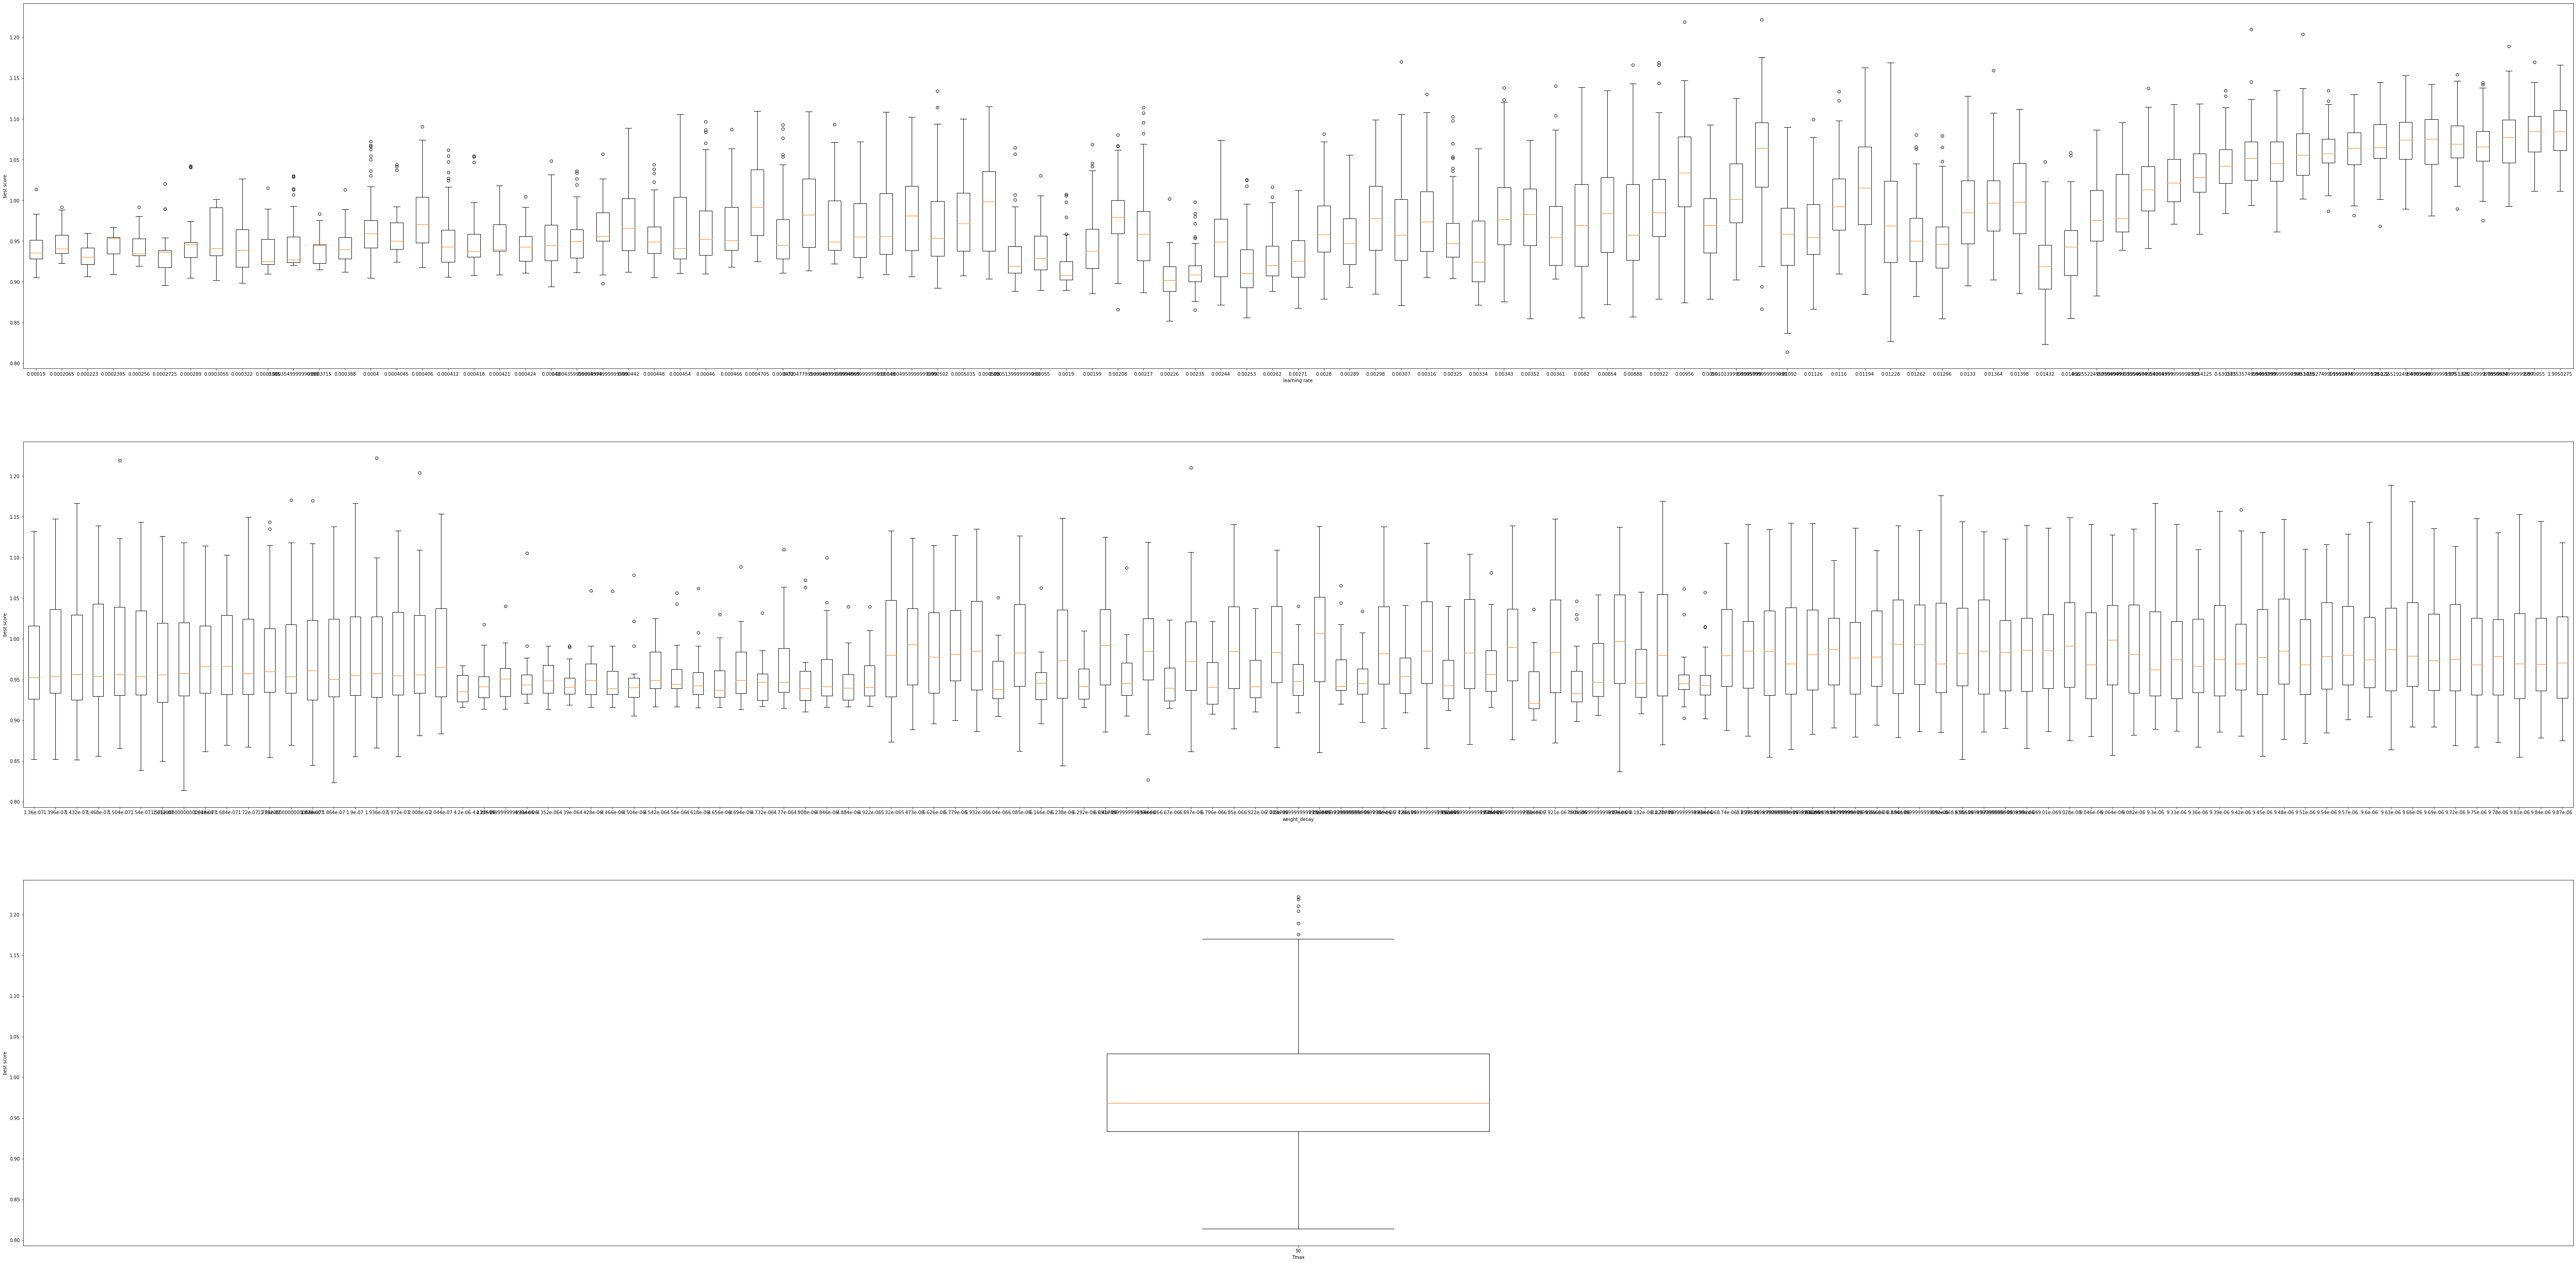

In [117]:
# vis_best_metrics(result3,'best score')

2023-5-13 **changed path of result file**: 

packed in './mil processing/hyperparam_select_batch_{run}/' folder

# results of 1st trial with pretrained resnet, 4th run

count    600.000000
mean       0.691847
std        0.080112
min        0.452083
25%        0.650000
50%        0.704167
75%        0.756250
max        0.845833
Name: best auc, dtype: float64


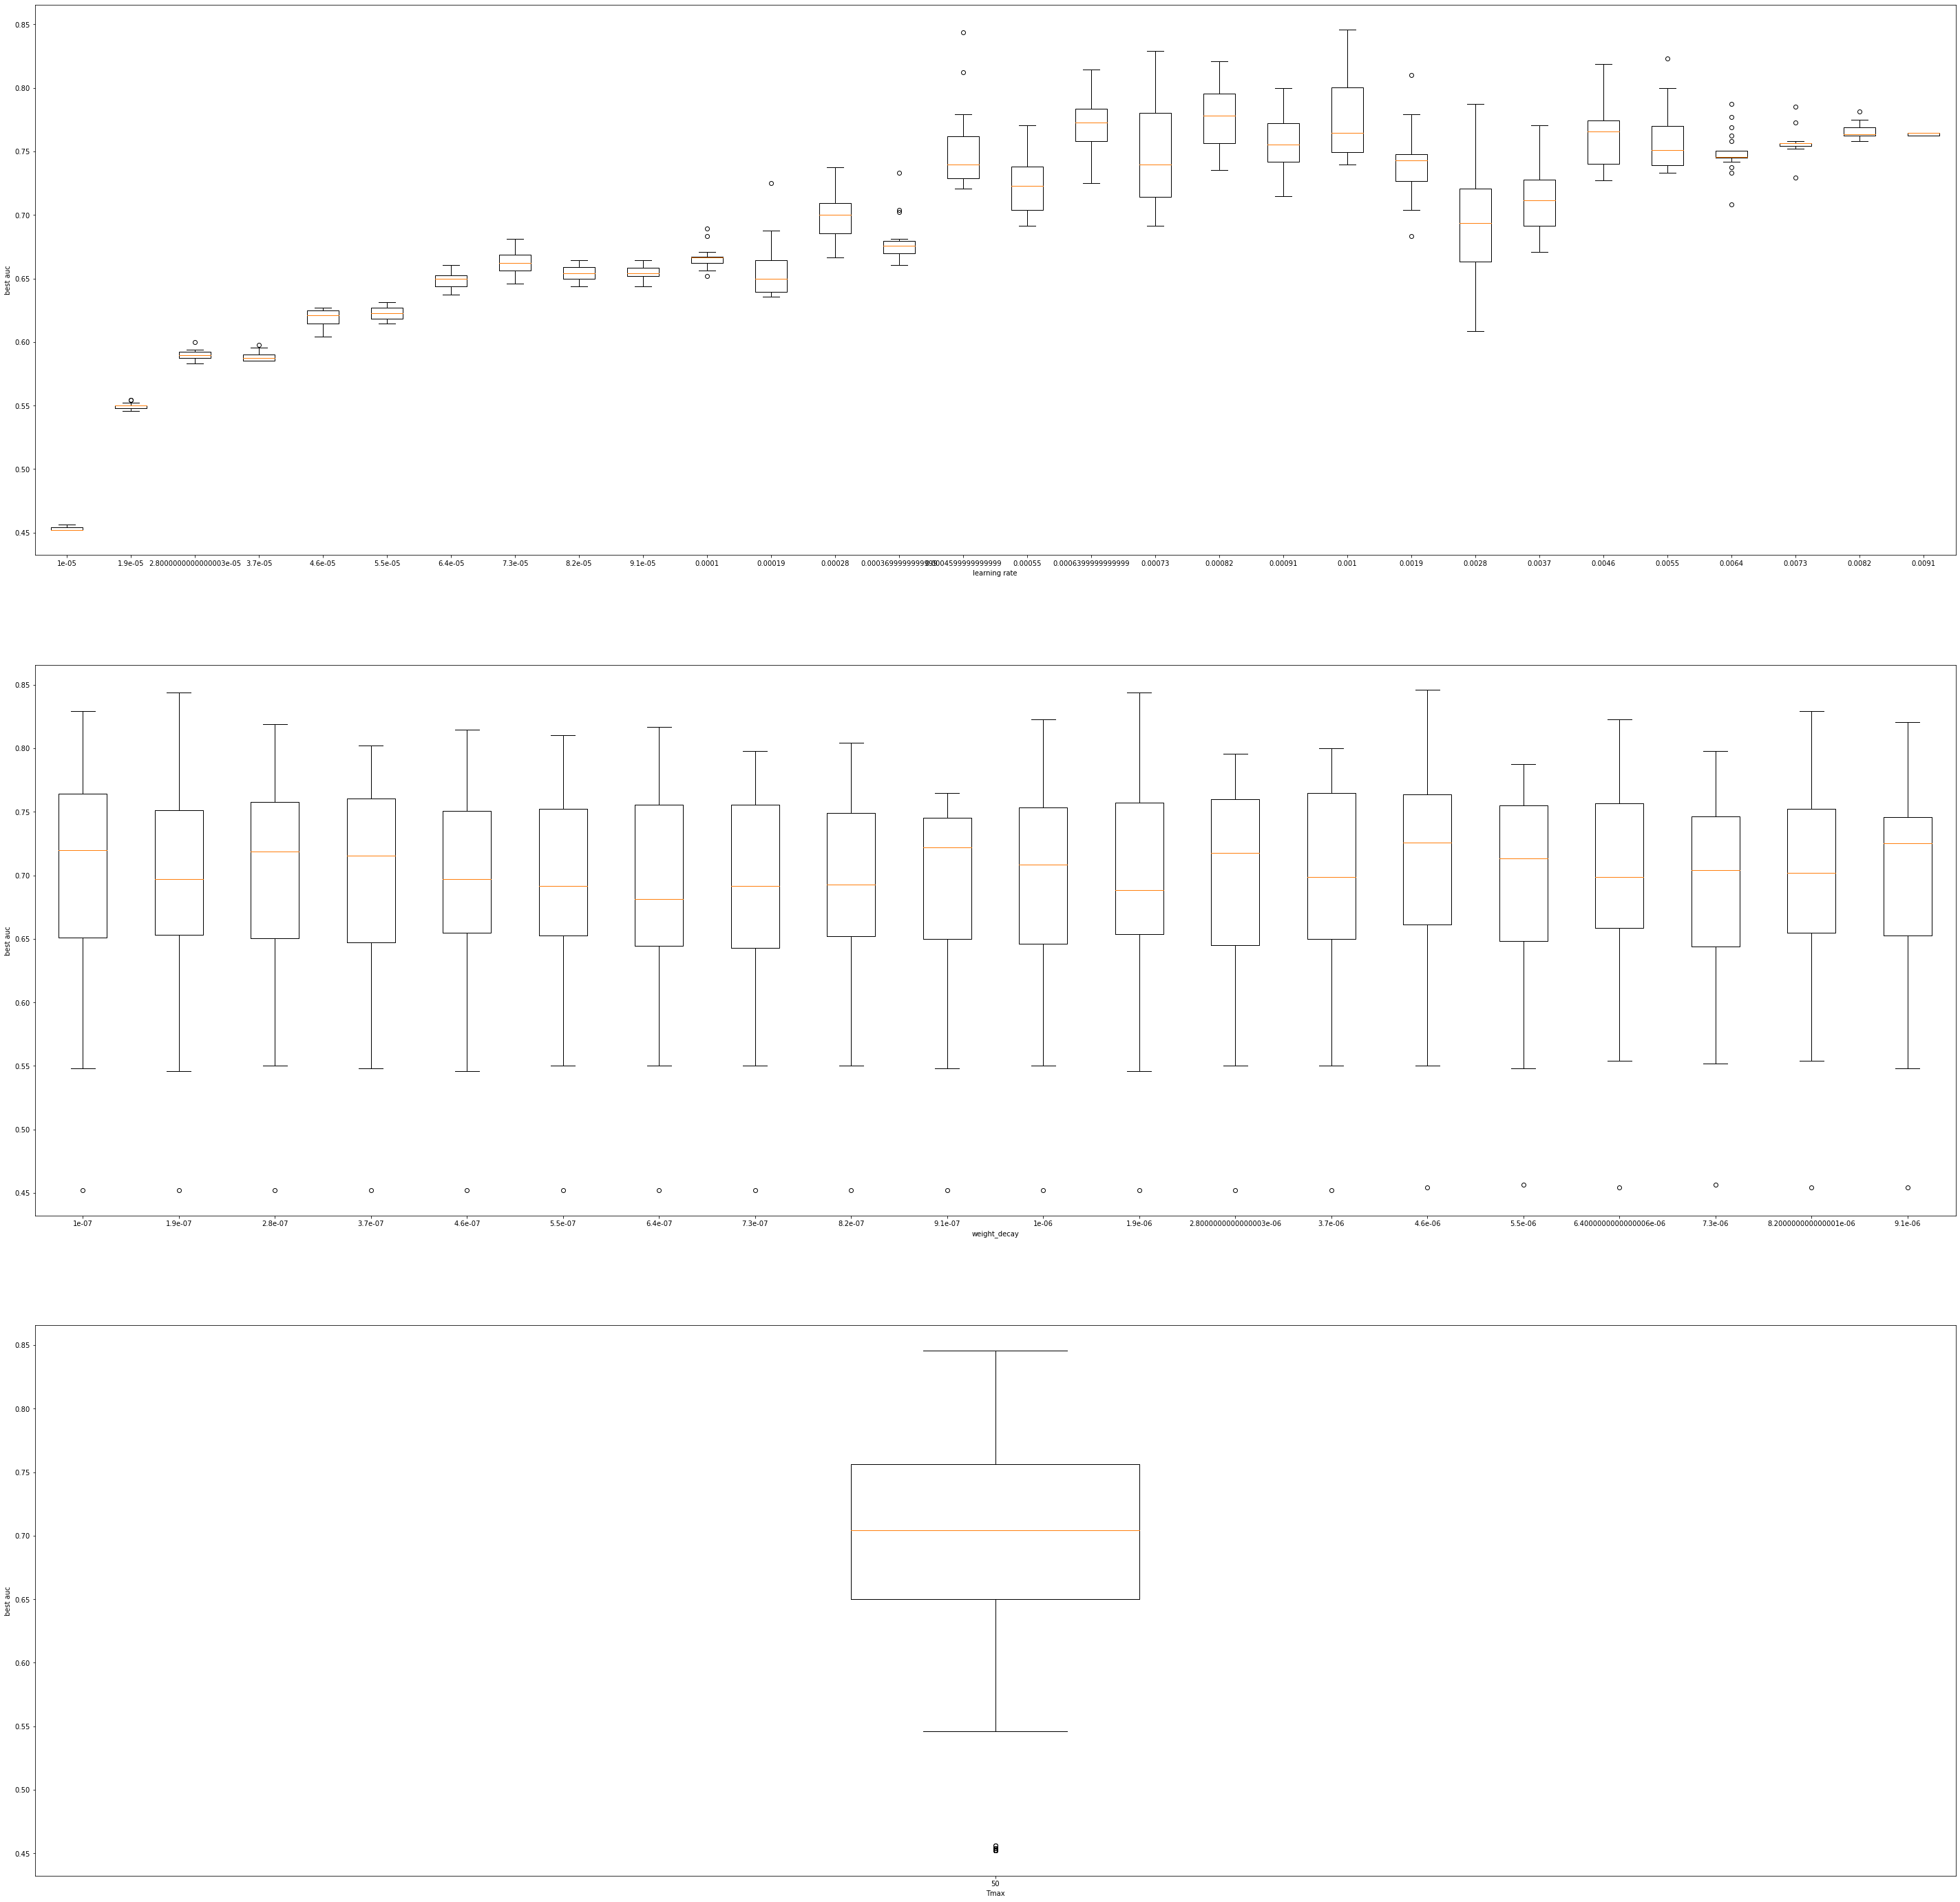

In [13]:
result4 = reader('./mil classifier/hyperparam_select_batch_4')
# vis_best_metrics(result4,'best auc',figsize = (50,50),output=True)

count    600.000000
mean       1.099046
std        0.056764
min        0.918139
25%        1.070564
50%        1.094253
75%        1.133630
max        1.248922
Name: best score, dtype: float64


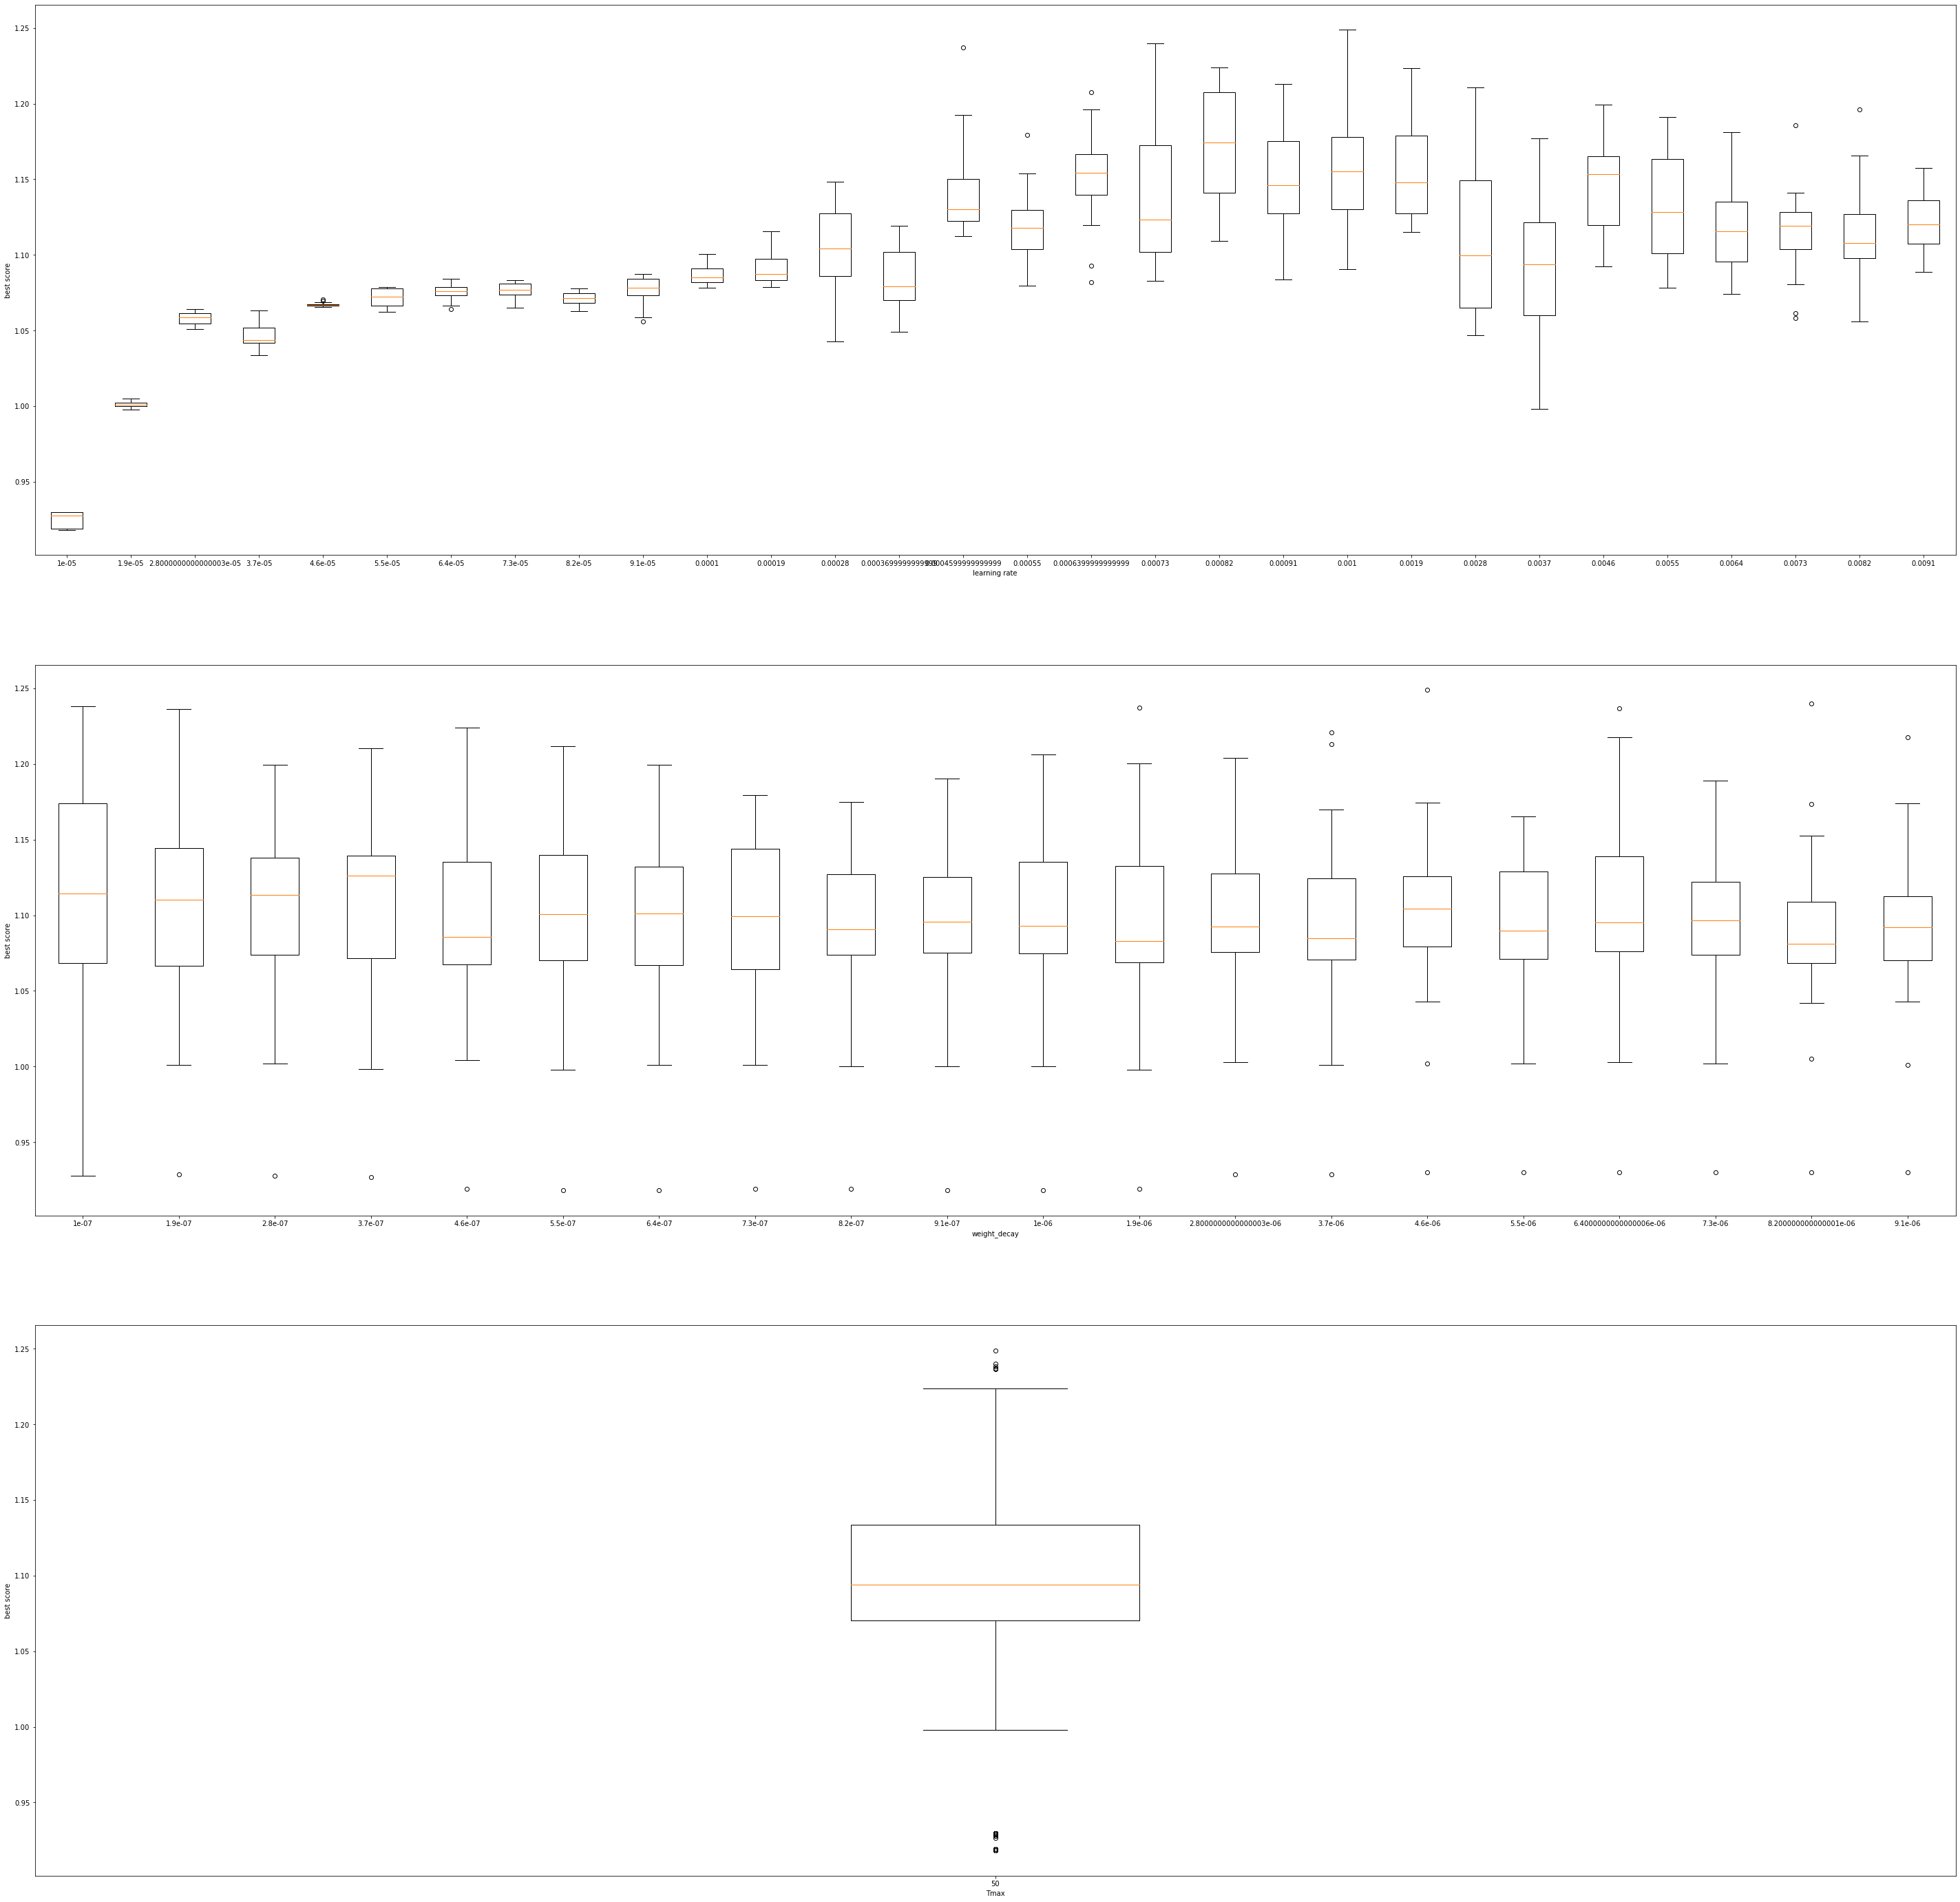

In [145]:
# vis_best_metrics(result4,'best score',figsize=(50,50),output = True)

## summary of 1st trial with pretrained resnet18, 4th run

lr: (4e-4,1e-3)

wd:对结果影响不敏感，沿用上述

Tmax：根据run1，沿用50

# results of 2nd trial with pretrained resnet, 5th run

count    600.000000
mean       0.758292
std        0.035338
min        0.662500
25%        0.733333
50%        0.759375
75%        0.783333
max        0.879167
Name: best auc, dtype: float64


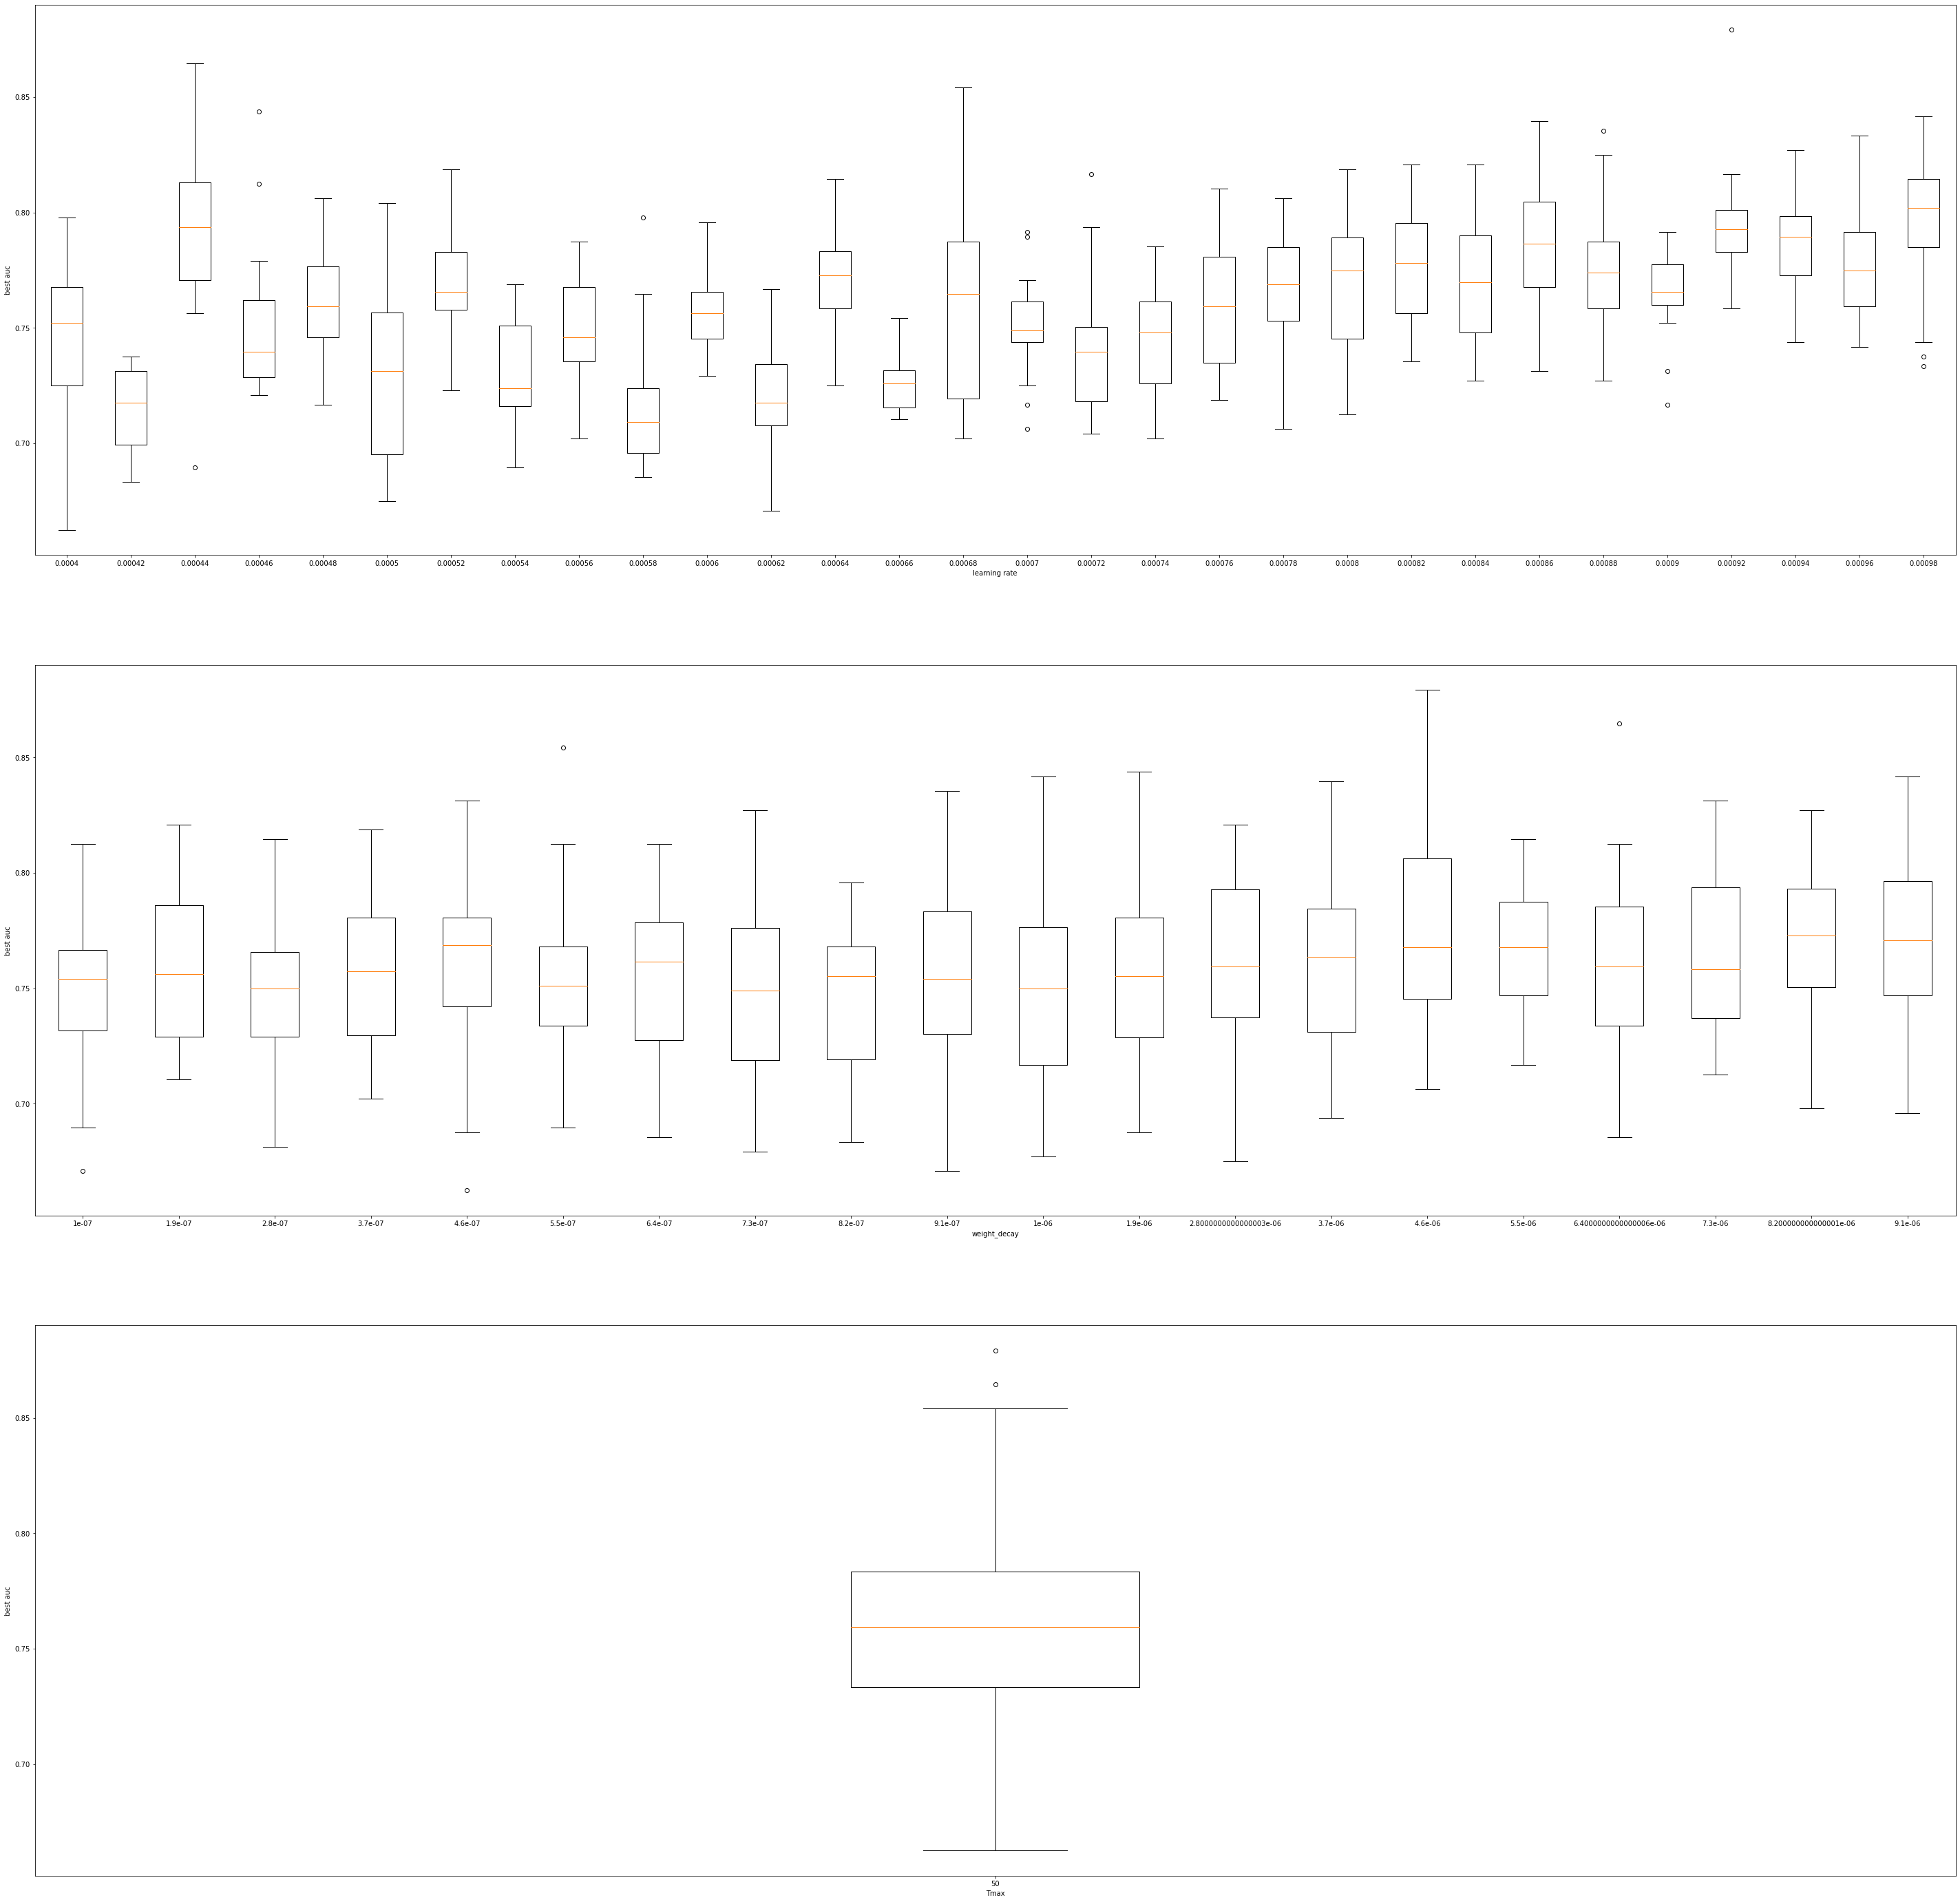

In [14]:
result5 = reader('./mil classifier/hyperparam_select_batch_5')
# vis_best_metrics(result5,'best auc',output=True)

count    600.000000
mean       1.145554
std        0.039254
min        1.052407
25%        1.118481
50%        1.142241
75%        1.171444
max        1.299497
Name: best score, dtype: float64


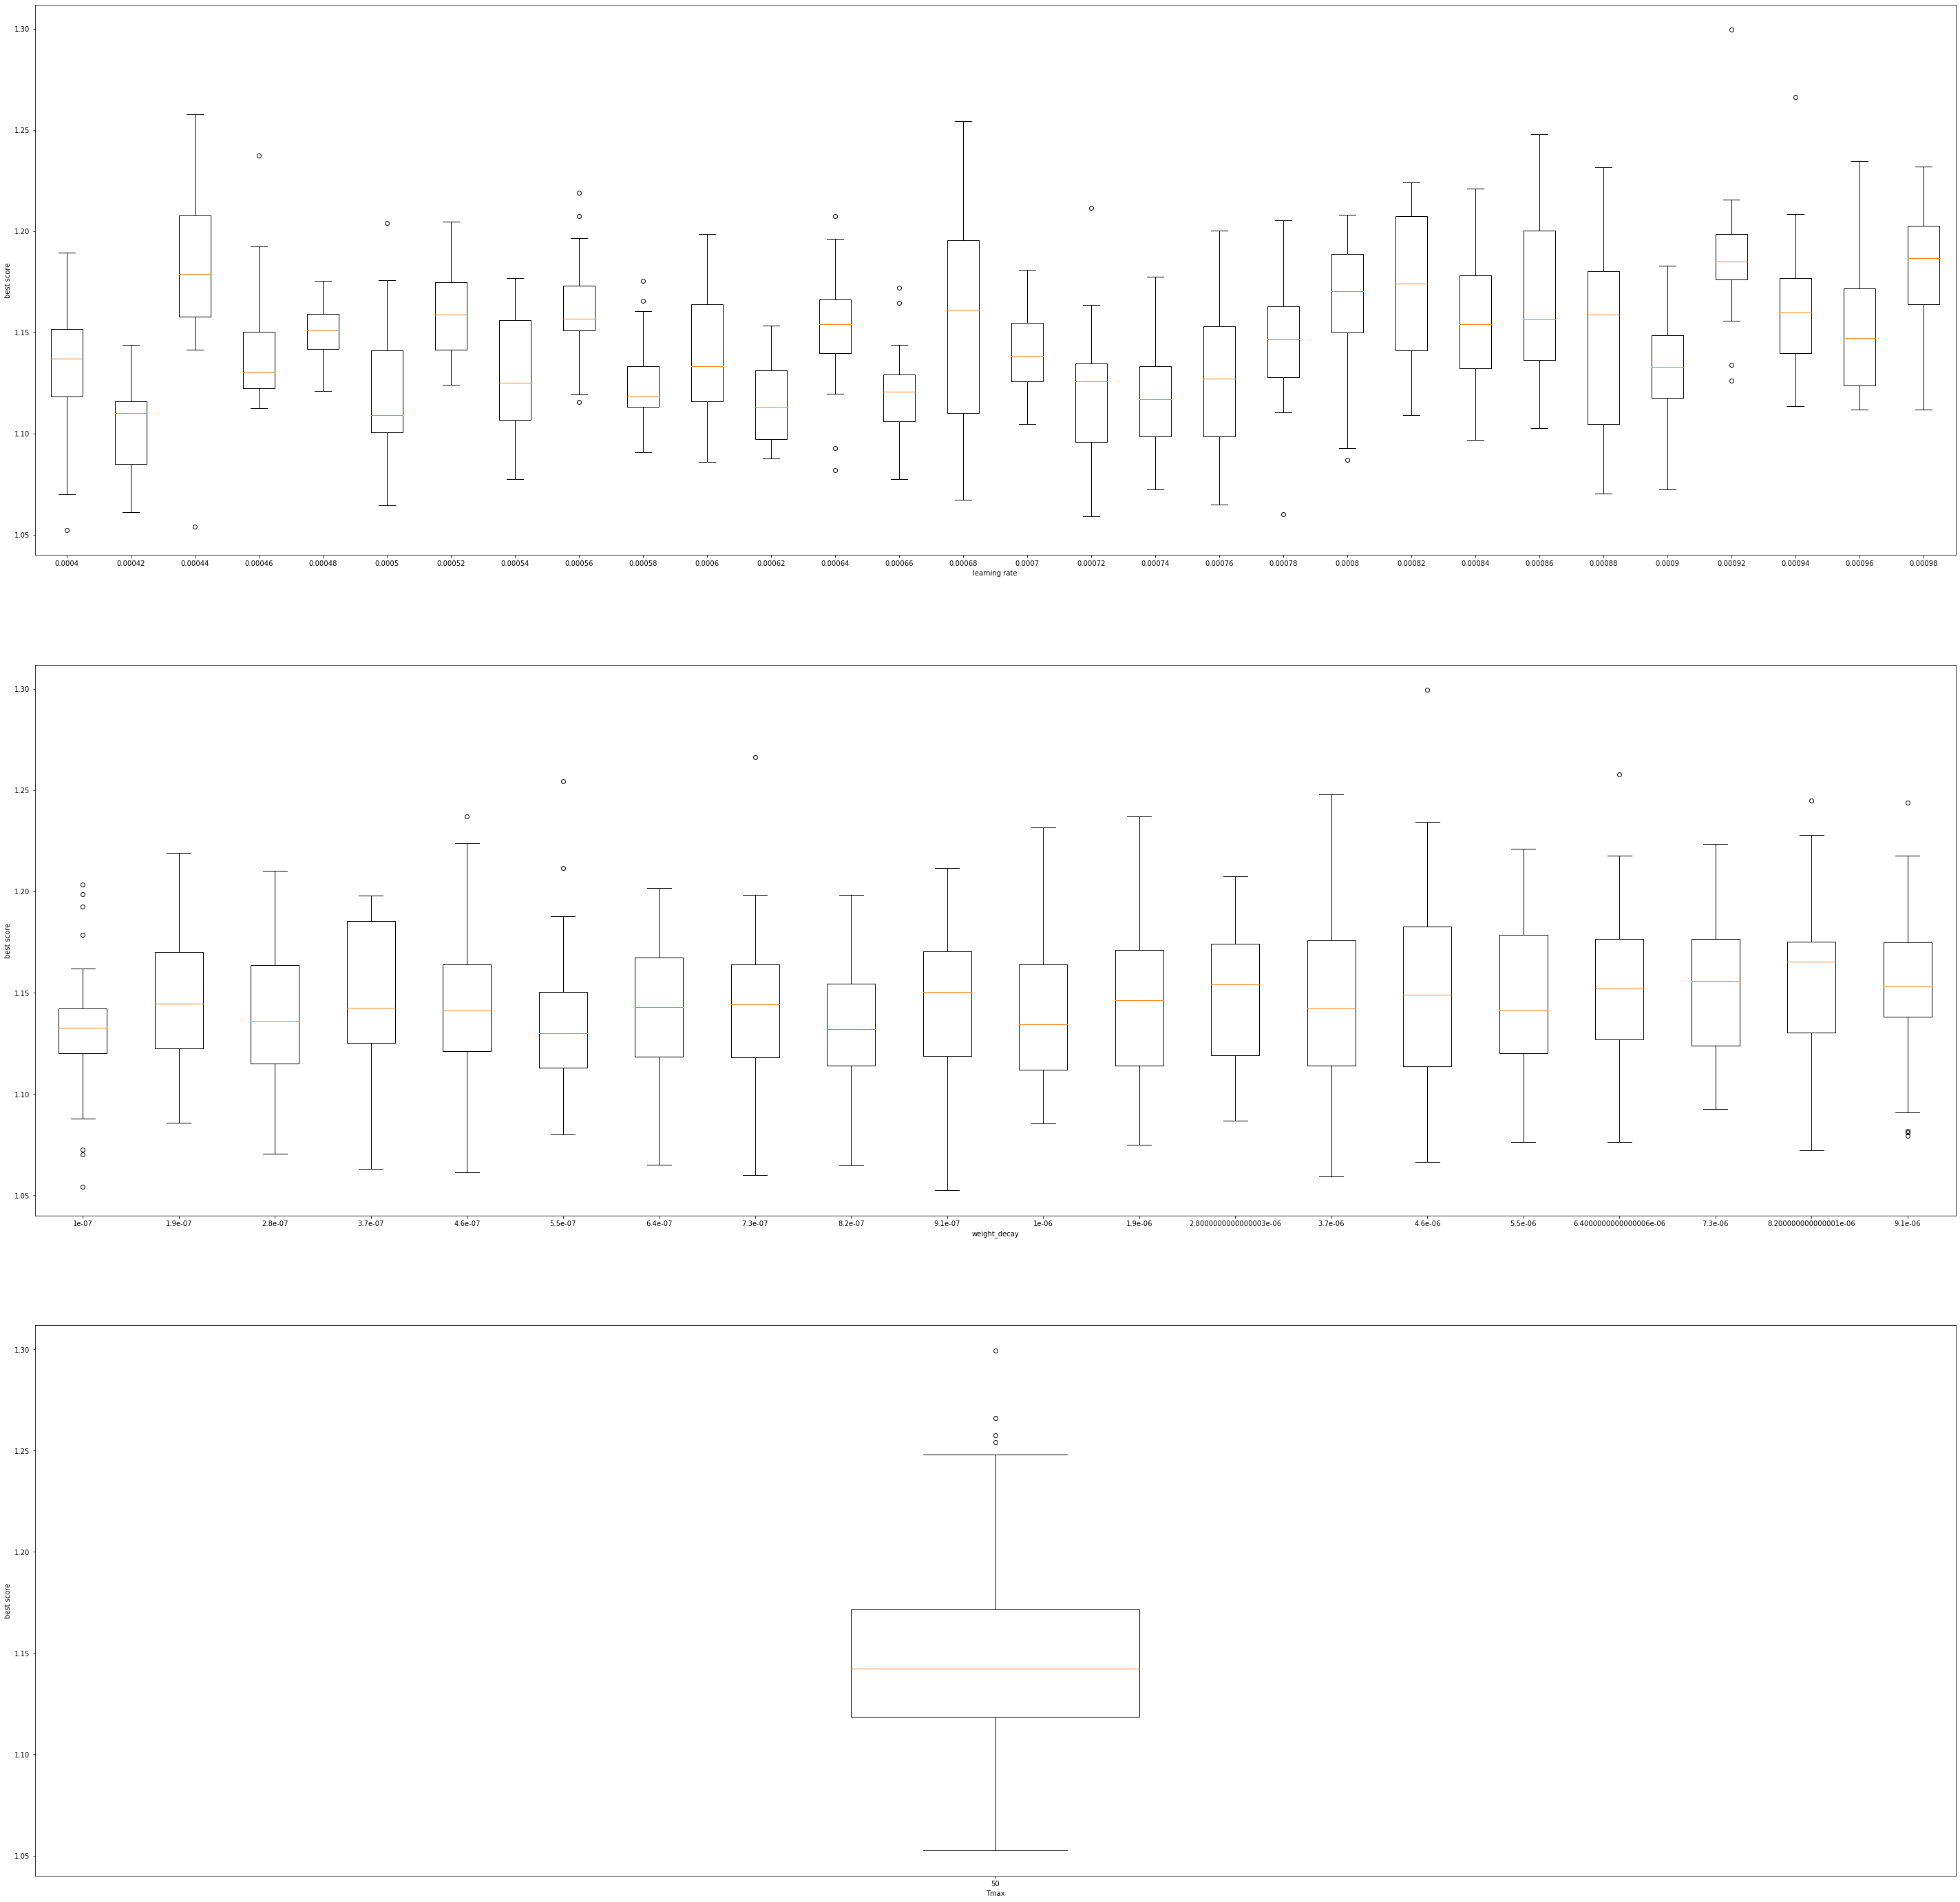

In [151]:
# vis_best_metrics(result5,'best score',output= True)

## summary of 2nd trial with pretrained resnet18, 5th run

lr:(4.2e-4,4.6e-4),(9e-4,9.6e-4)

wd:对结果无明显影响，沿用之前的范围 -- (1e-7,1e-6),(1e-6,1e-5)

# results of 3rd trial with pretrained resnet, 6th run

count    800.000000
mean       0.758336
std        0.039581
min        0.641667
25%        0.734896
50%        0.764583
75%        0.785417
max        0.864583
Name: best auc, dtype: float64


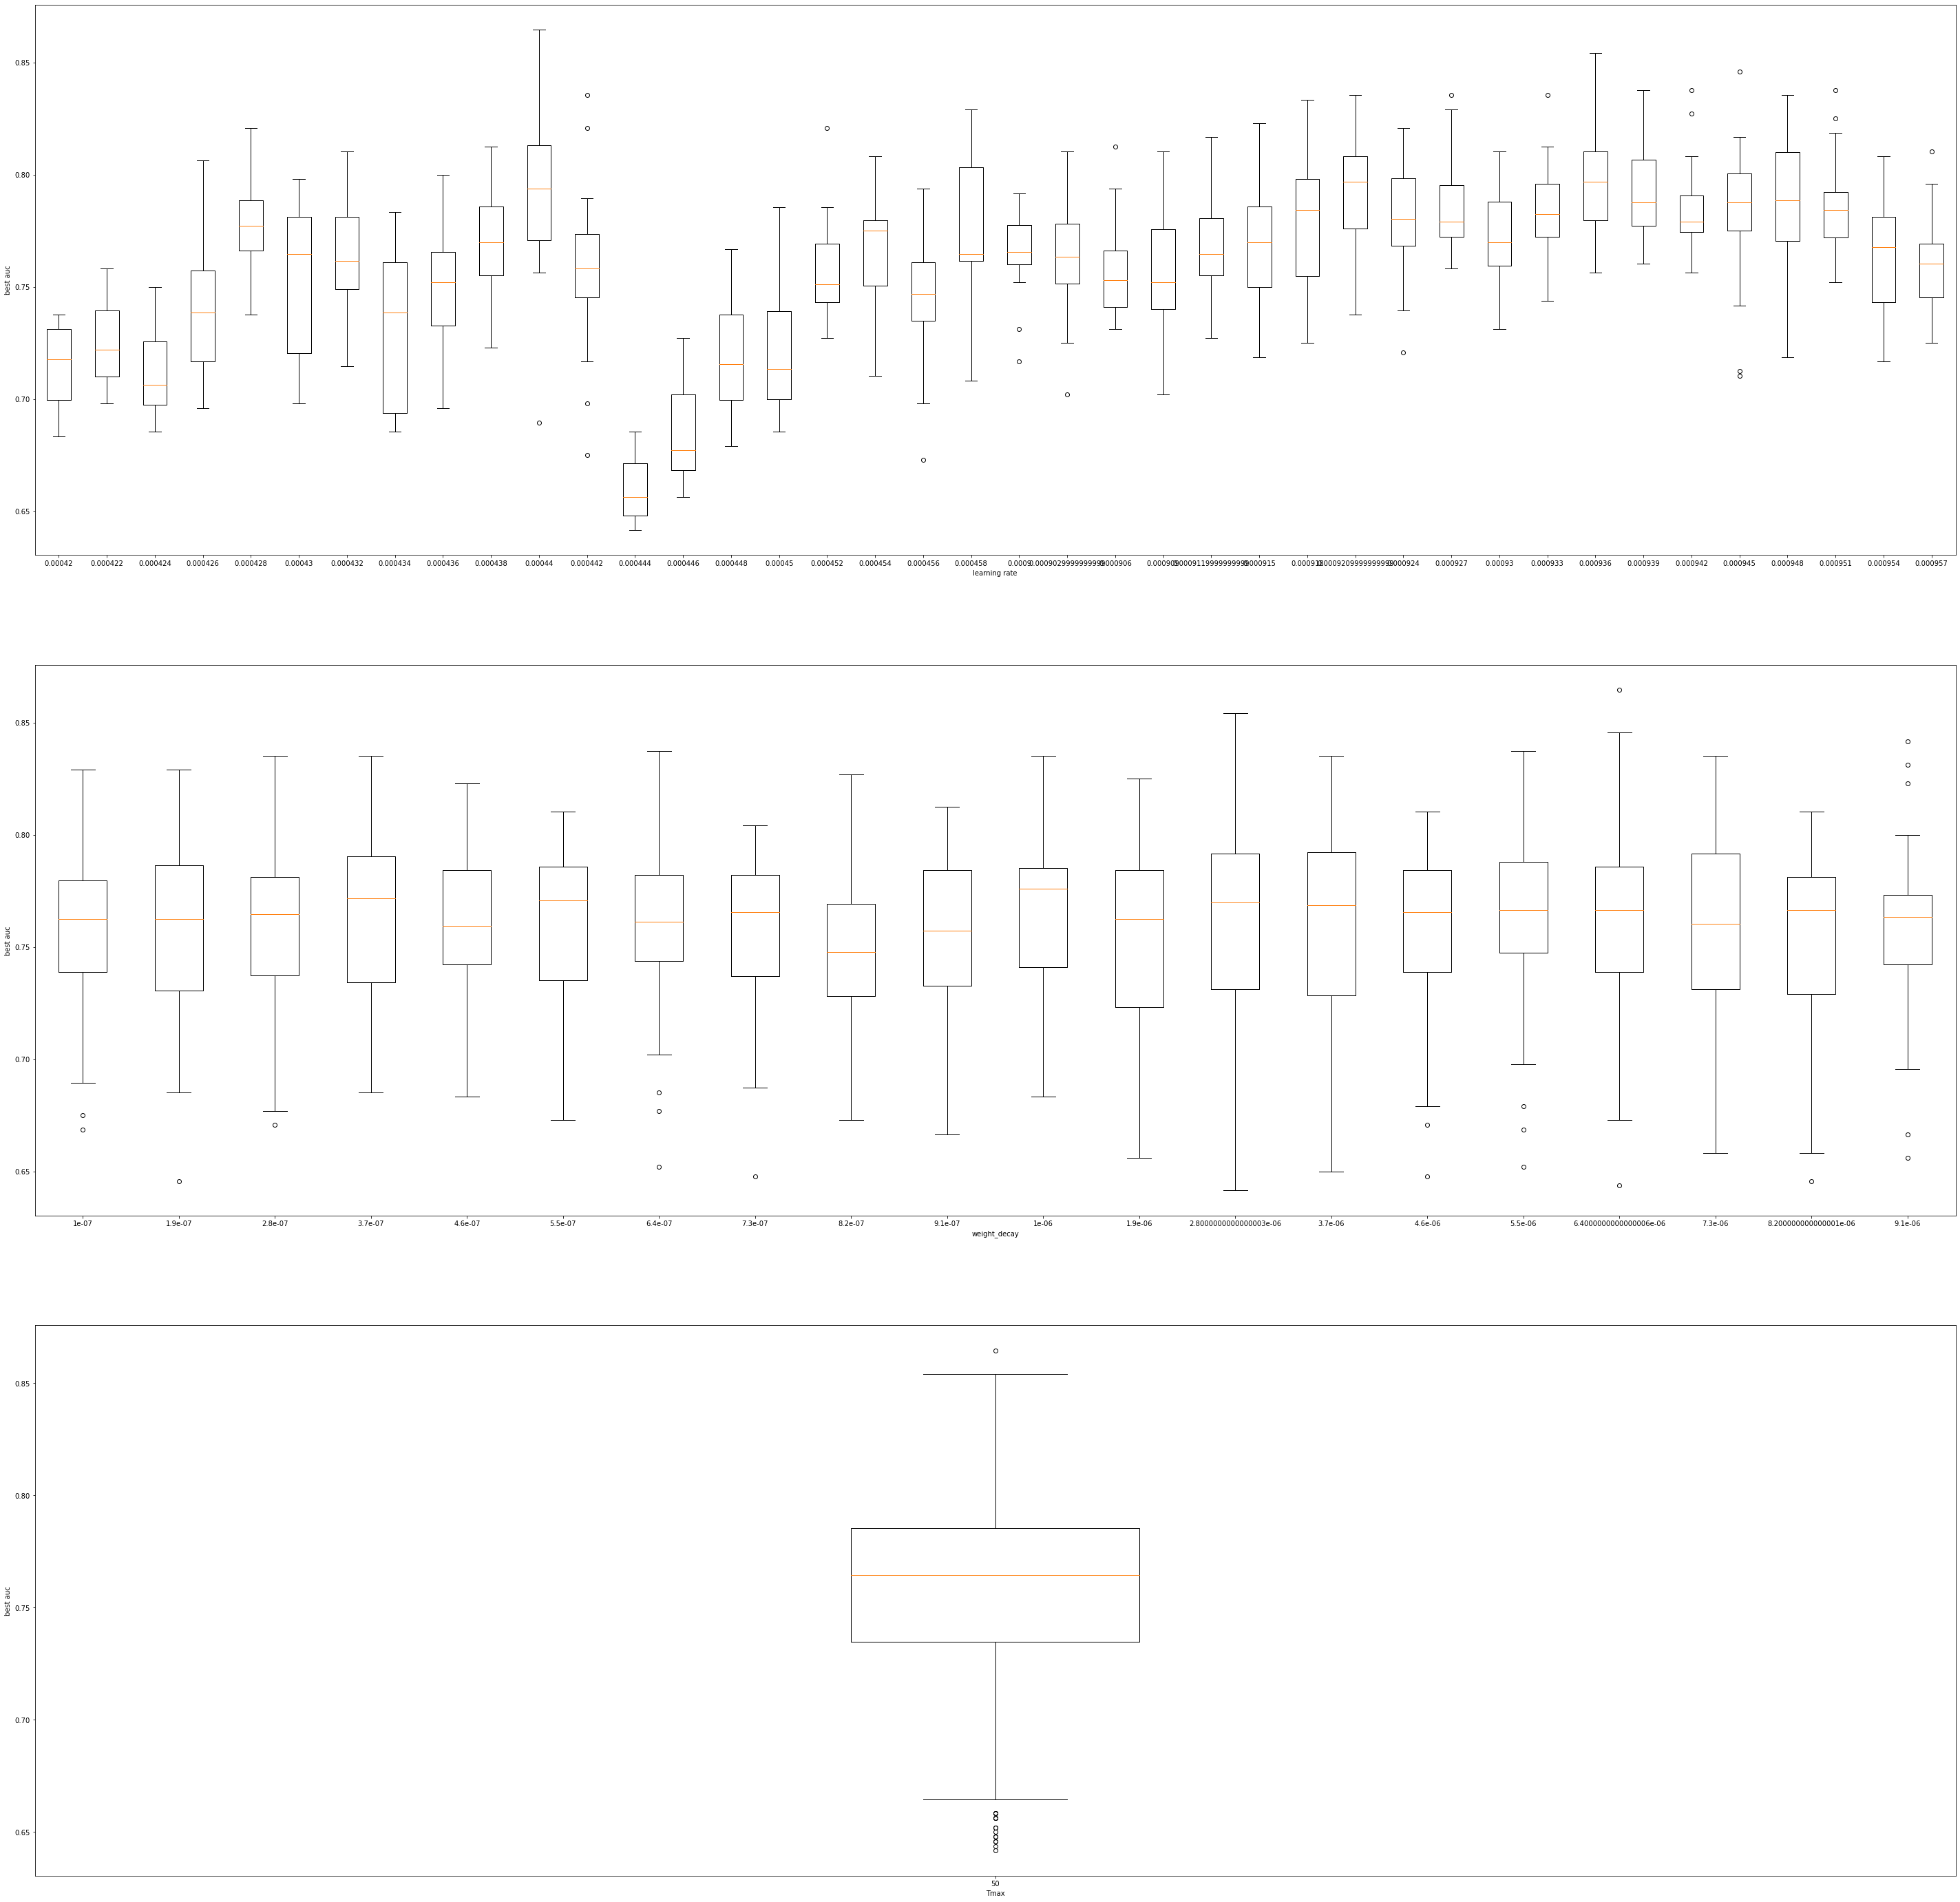

In [15]:
result6 = reader('./mil classifier/hyperparam_select_batch_6')
# vis_best_metrics(result6,'best auc',output=True)

count    800.000000
mean       1.145293
std        0.041711
min        0.998132
25%        1.119729
50%        1.144828
75%        1.172926
max        1.308405
Name: best score, dtype: float64


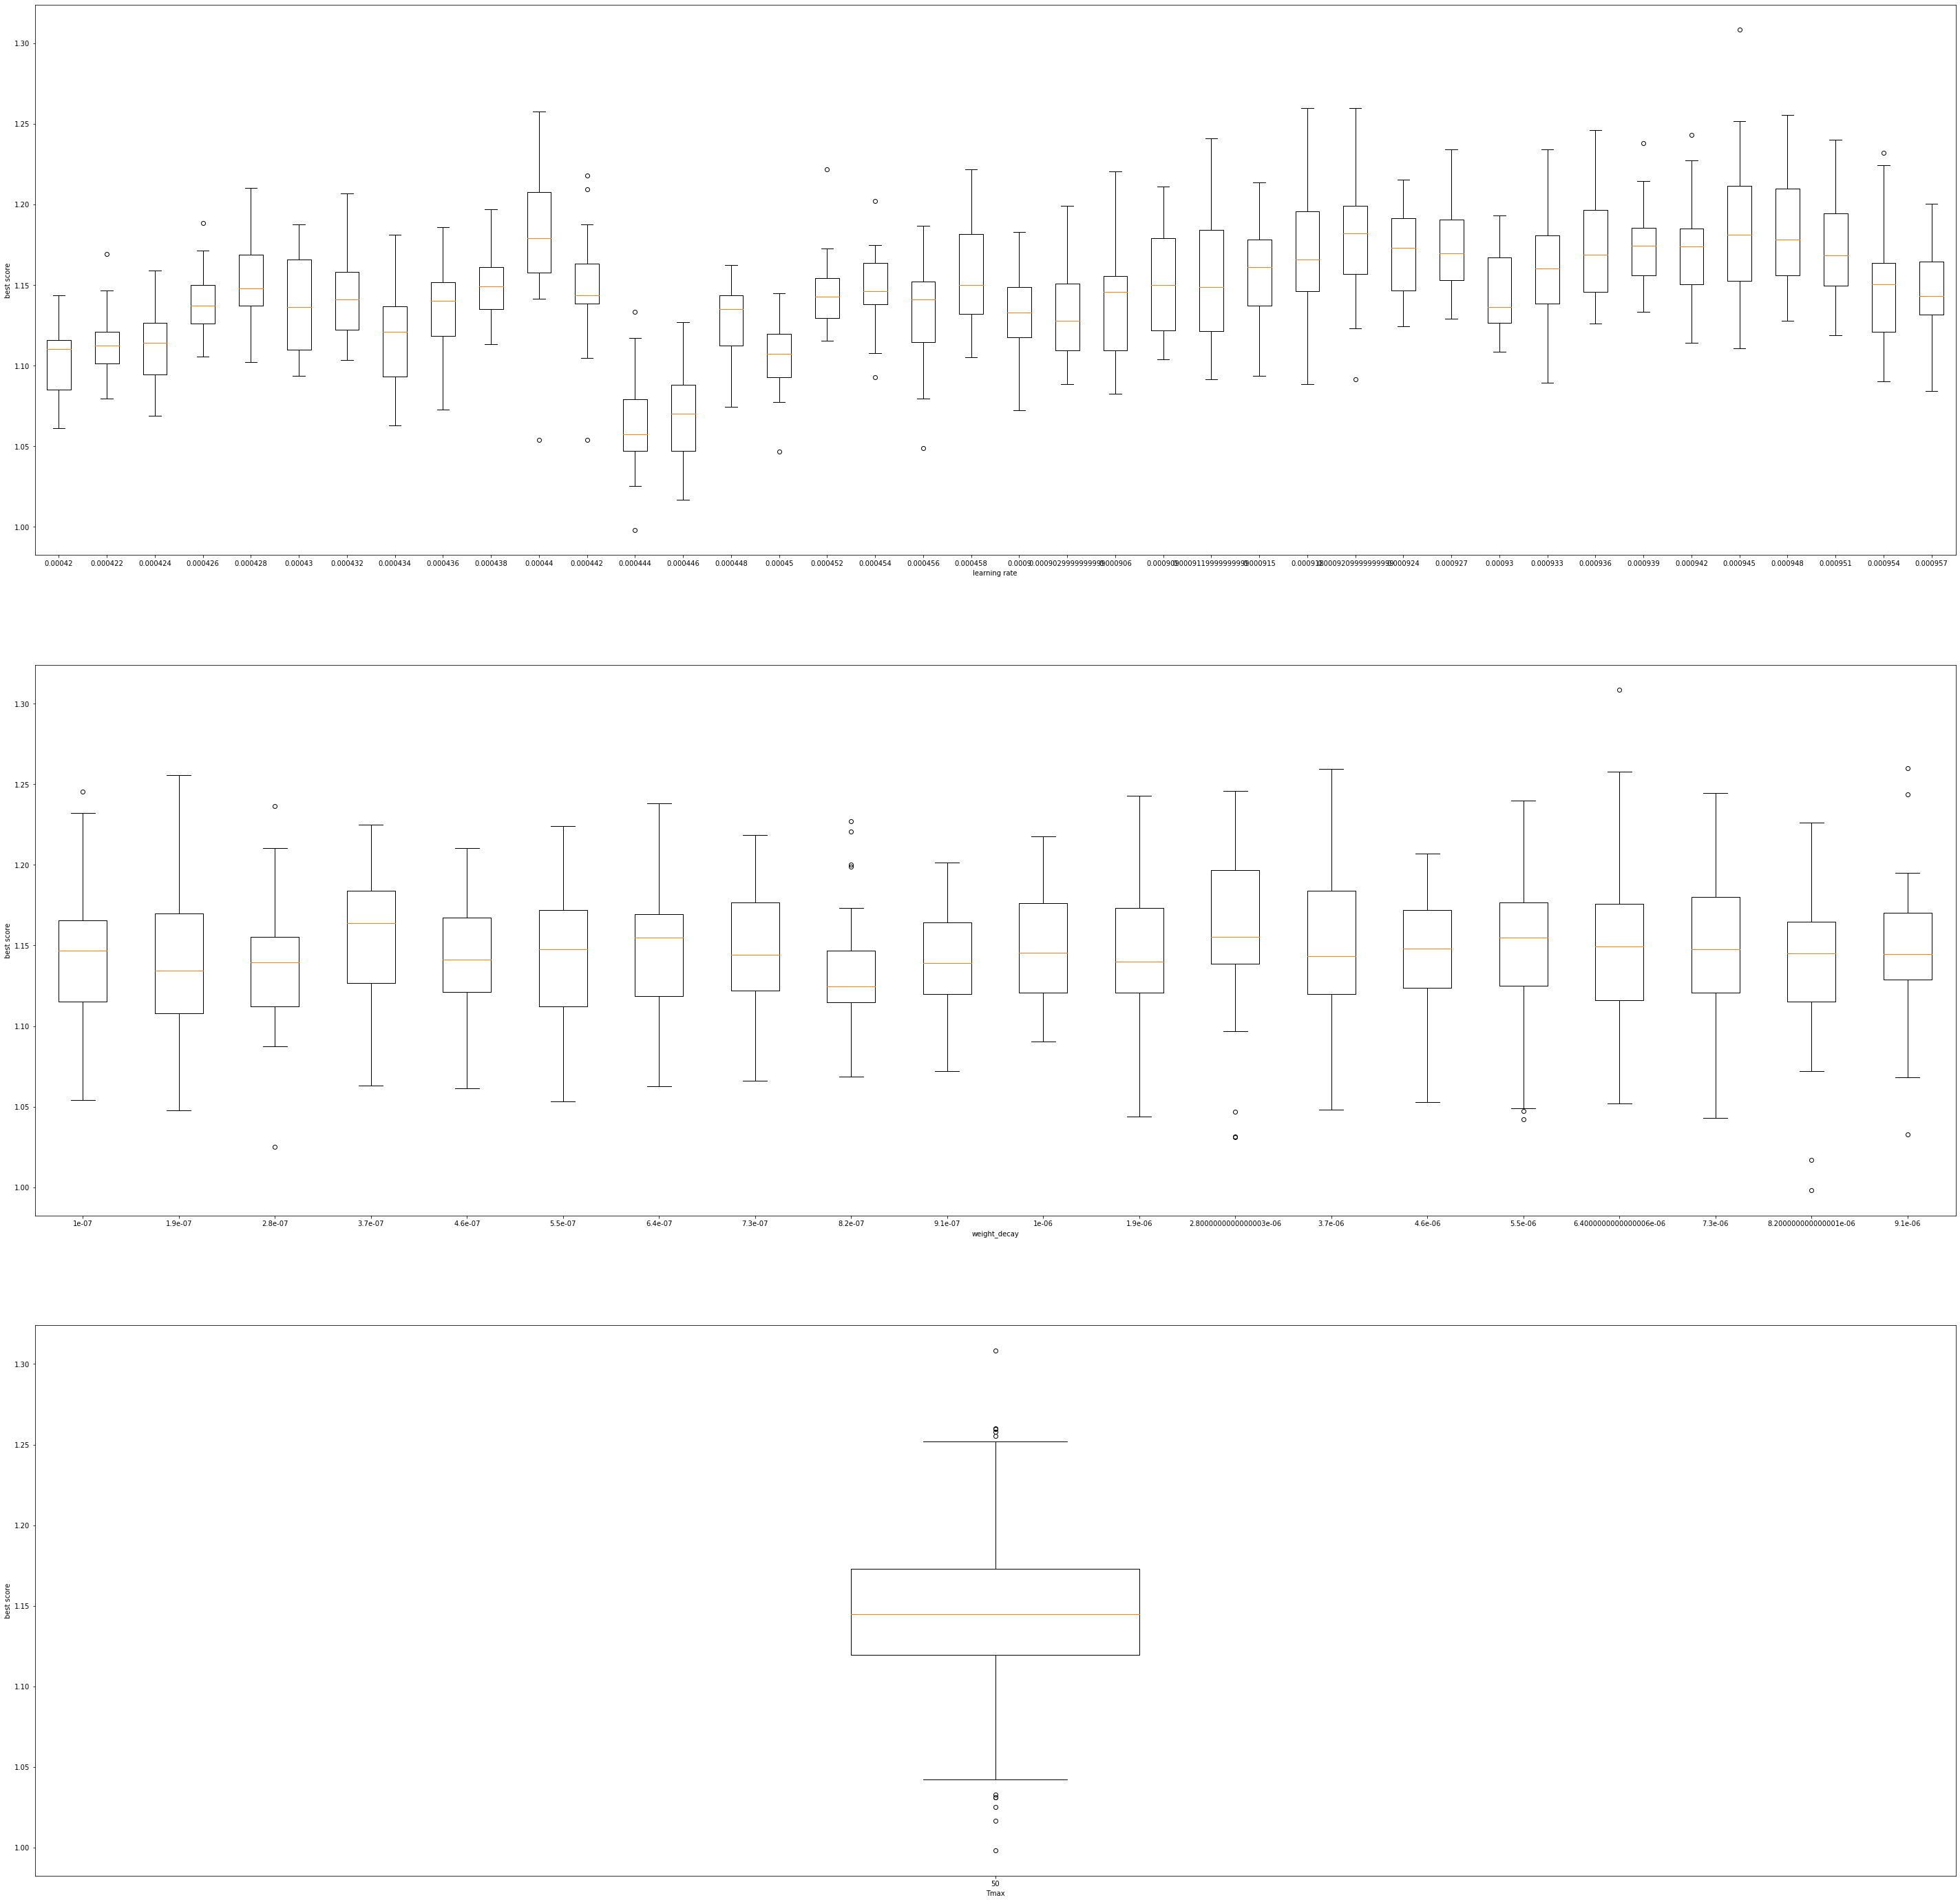

In [194]:
# vis_best_metrics(result6,'best score',output= True)

## summary of 3rd trial with pretrained resnet18, 6th run

调参基本达到上限,使用5th run的结果

# top 10 hyperparam implement on PtRes18 extracted features

In [18]:
auc_PtRes18_10X_R5 = top_comb(result5,metrics='best auc')  # best auc hyperparam_comb, based on PtRes18 extracted features, 10X slides, result from 5th run
score_PtRes18_10X_R5 = top_comb(result5,metrics='best score')
avg_PtRes18_10X_R5 = top_comb(result5,metrics='best avg auc')

In [19]:
auc_PtRes18_10X_R5

[(learning rate     0.000920
  weight_decay      0.000005
  Tmax             50.000000
  Name: 343, dtype: float64,
  0.8791666666666667),
 (learning rate     0.000440
  weight_decay      0.000006
  Tmax             50.000000
  Name: 220, dtype: float64,
  0.8645833333333334),
 (learning rate    6.800000e-04
  weight_decay     5.500000e-07
  Tmax             5.000000e+01
  Name: 537, dtype: float64,
  0.8541666666666667),
 (learning rate     0.000460
  weight_decay      0.000002
  Tmax             50.000000
  Name: 287, dtype: float64,
  0.84375),
 (learning rate     0.000440
  weight_decay      0.000009
  Tmax             50.000000
  Name: 239, dtype: float64,
  0.8416666666666668),
 (learning rate     0.000980
  weight_decay      0.000001
  Tmax             50.000000
  Name: 571, dtype: float64,
  0.8416666666666667),
 (learning rate     0.000860
  weight_decay      0.000004
  Tmax             50.000000
  Name: 83, dtype: float64,
  0.8395833333333332),
 (learning rate     0.000880
 

# results of 1st trial with pretrained resnet50 extracted data, 7th run

count    600.000000
mean       0.545003
std        0.147094
min        0.418750
25%        0.427083
50%        0.455208
75%        0.710417
max        0.845833
Name: best auc, dtype: float64


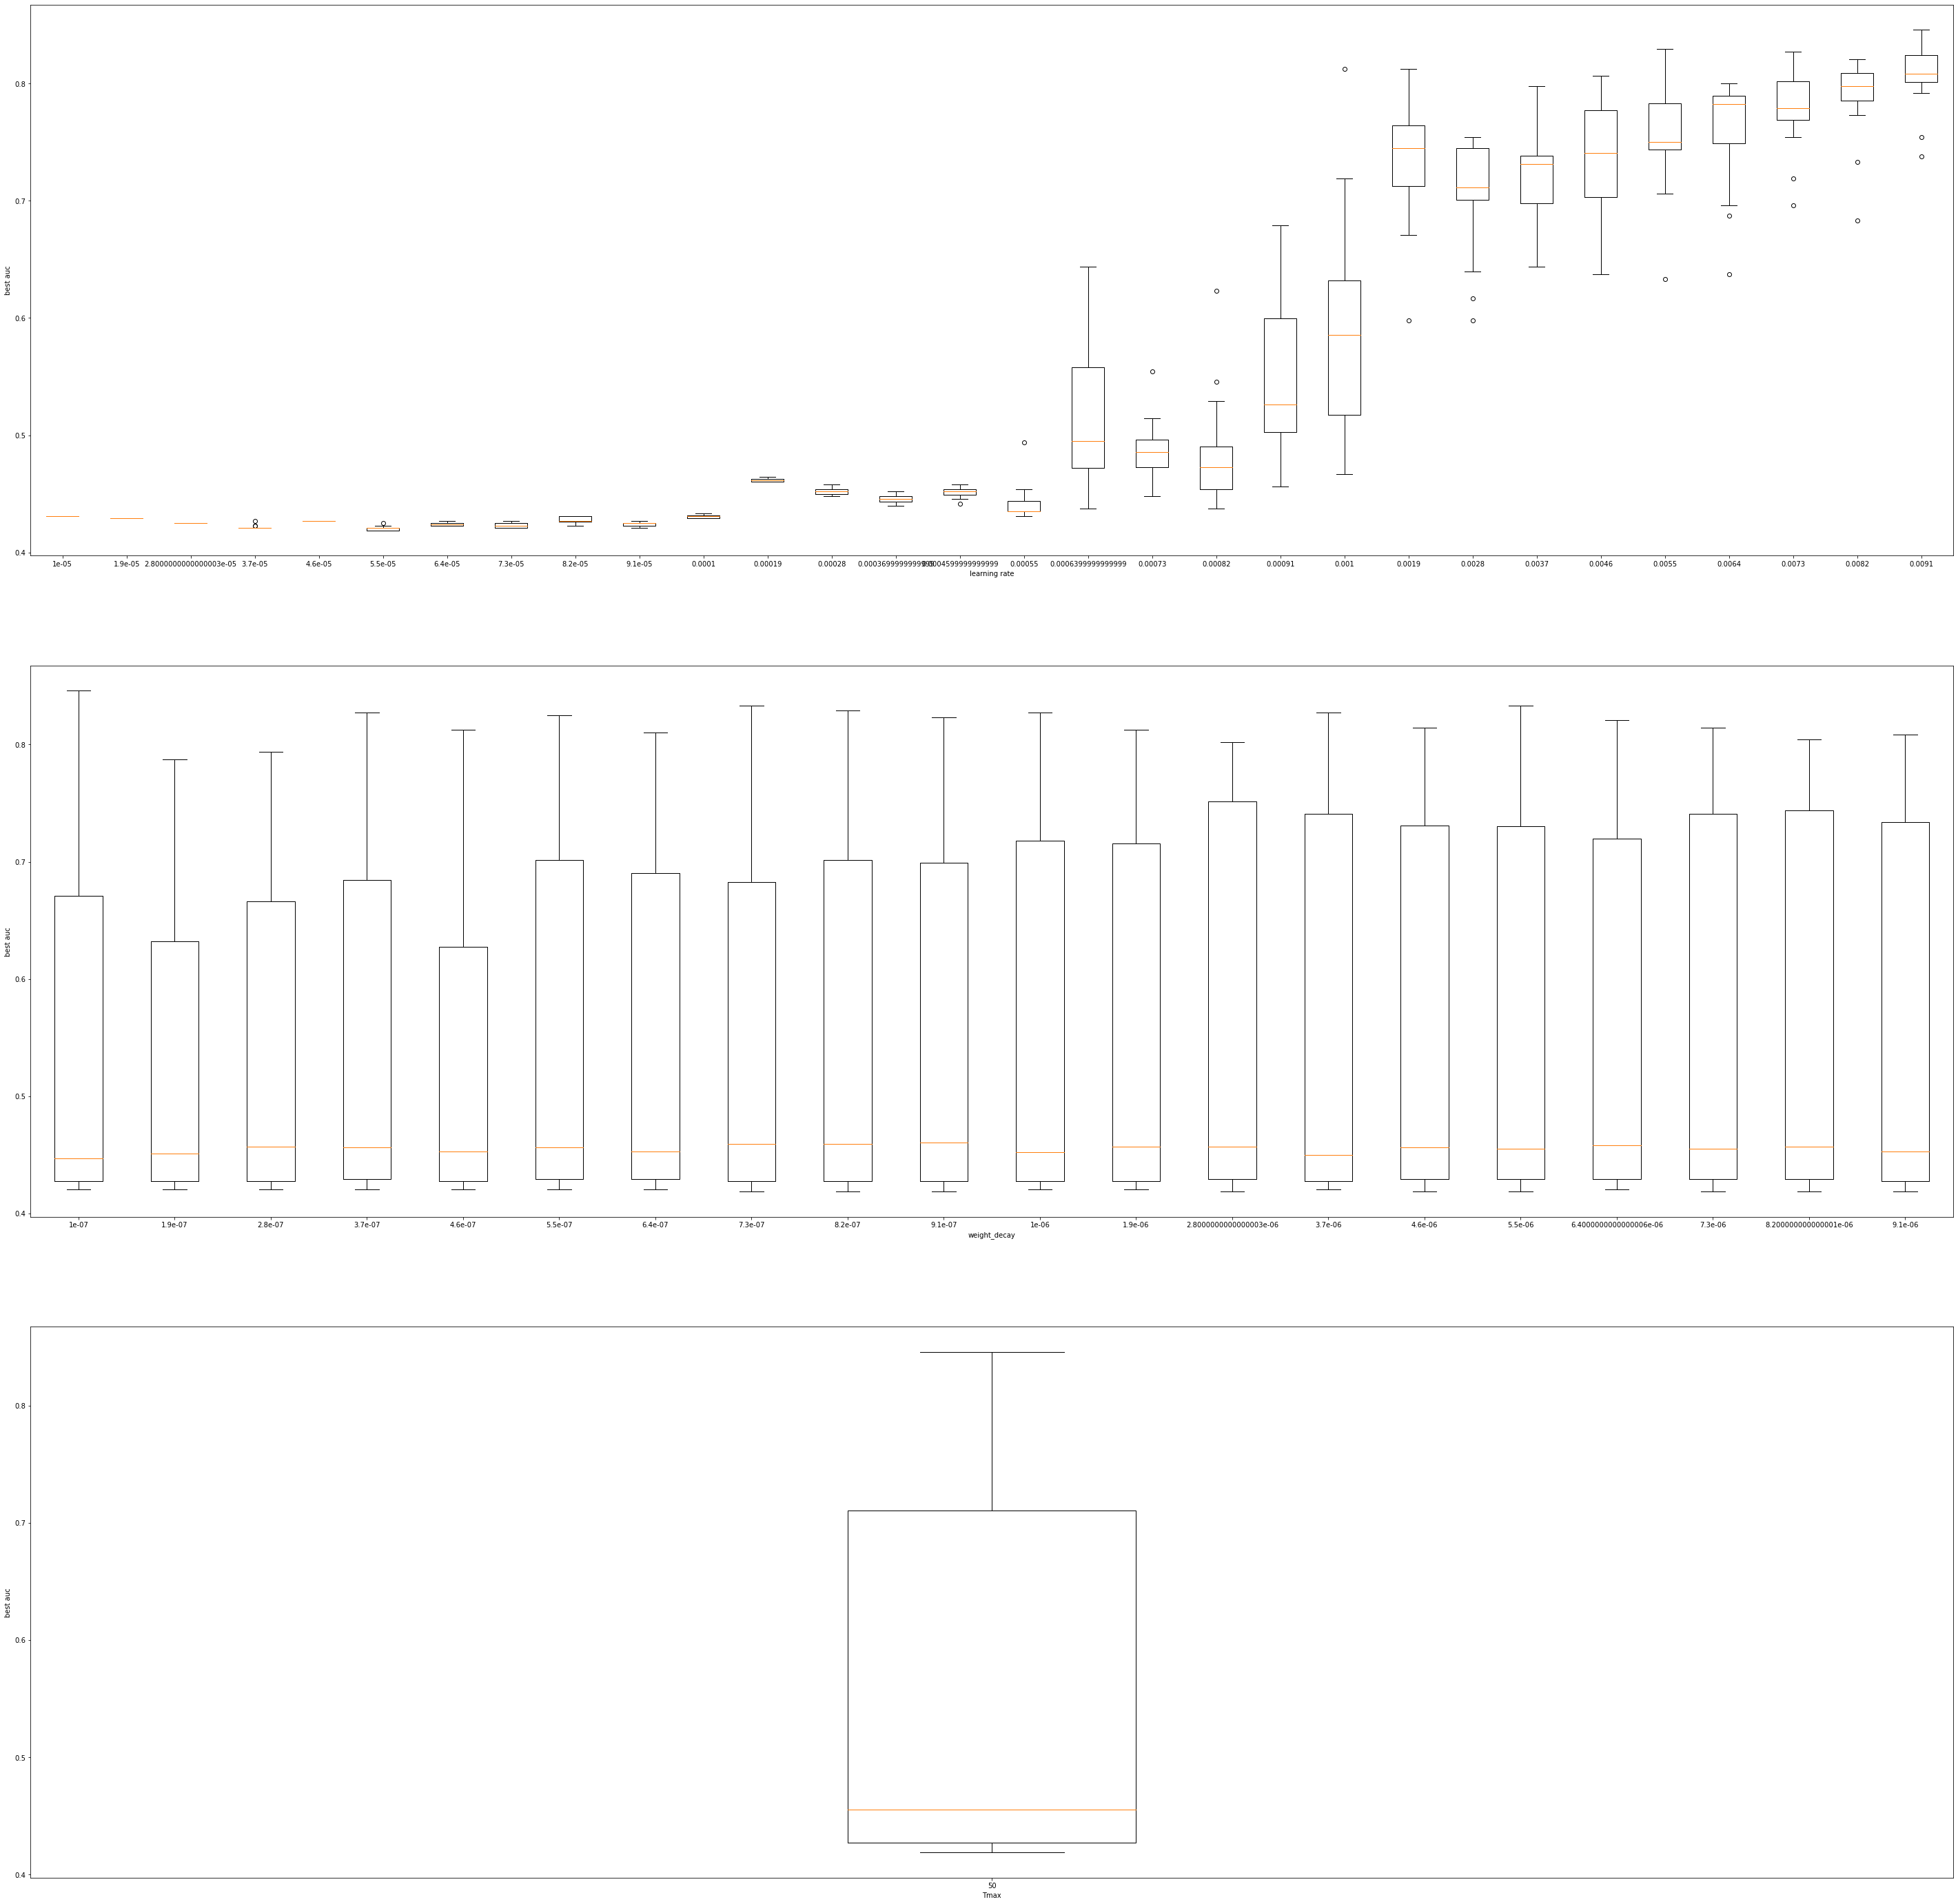

In [16]:
result7 = reader('./mil classifier/hyperparam_select_batch_7')
# vis_best_metrics(result7,'best auc',output=True)

count    600.000000
mean       0.992320
std        0.088913
min        0.874066
25%        0.900251
50%        0.976760
75%        1.055244
max        1.228376
Name: best score, dtype: float64


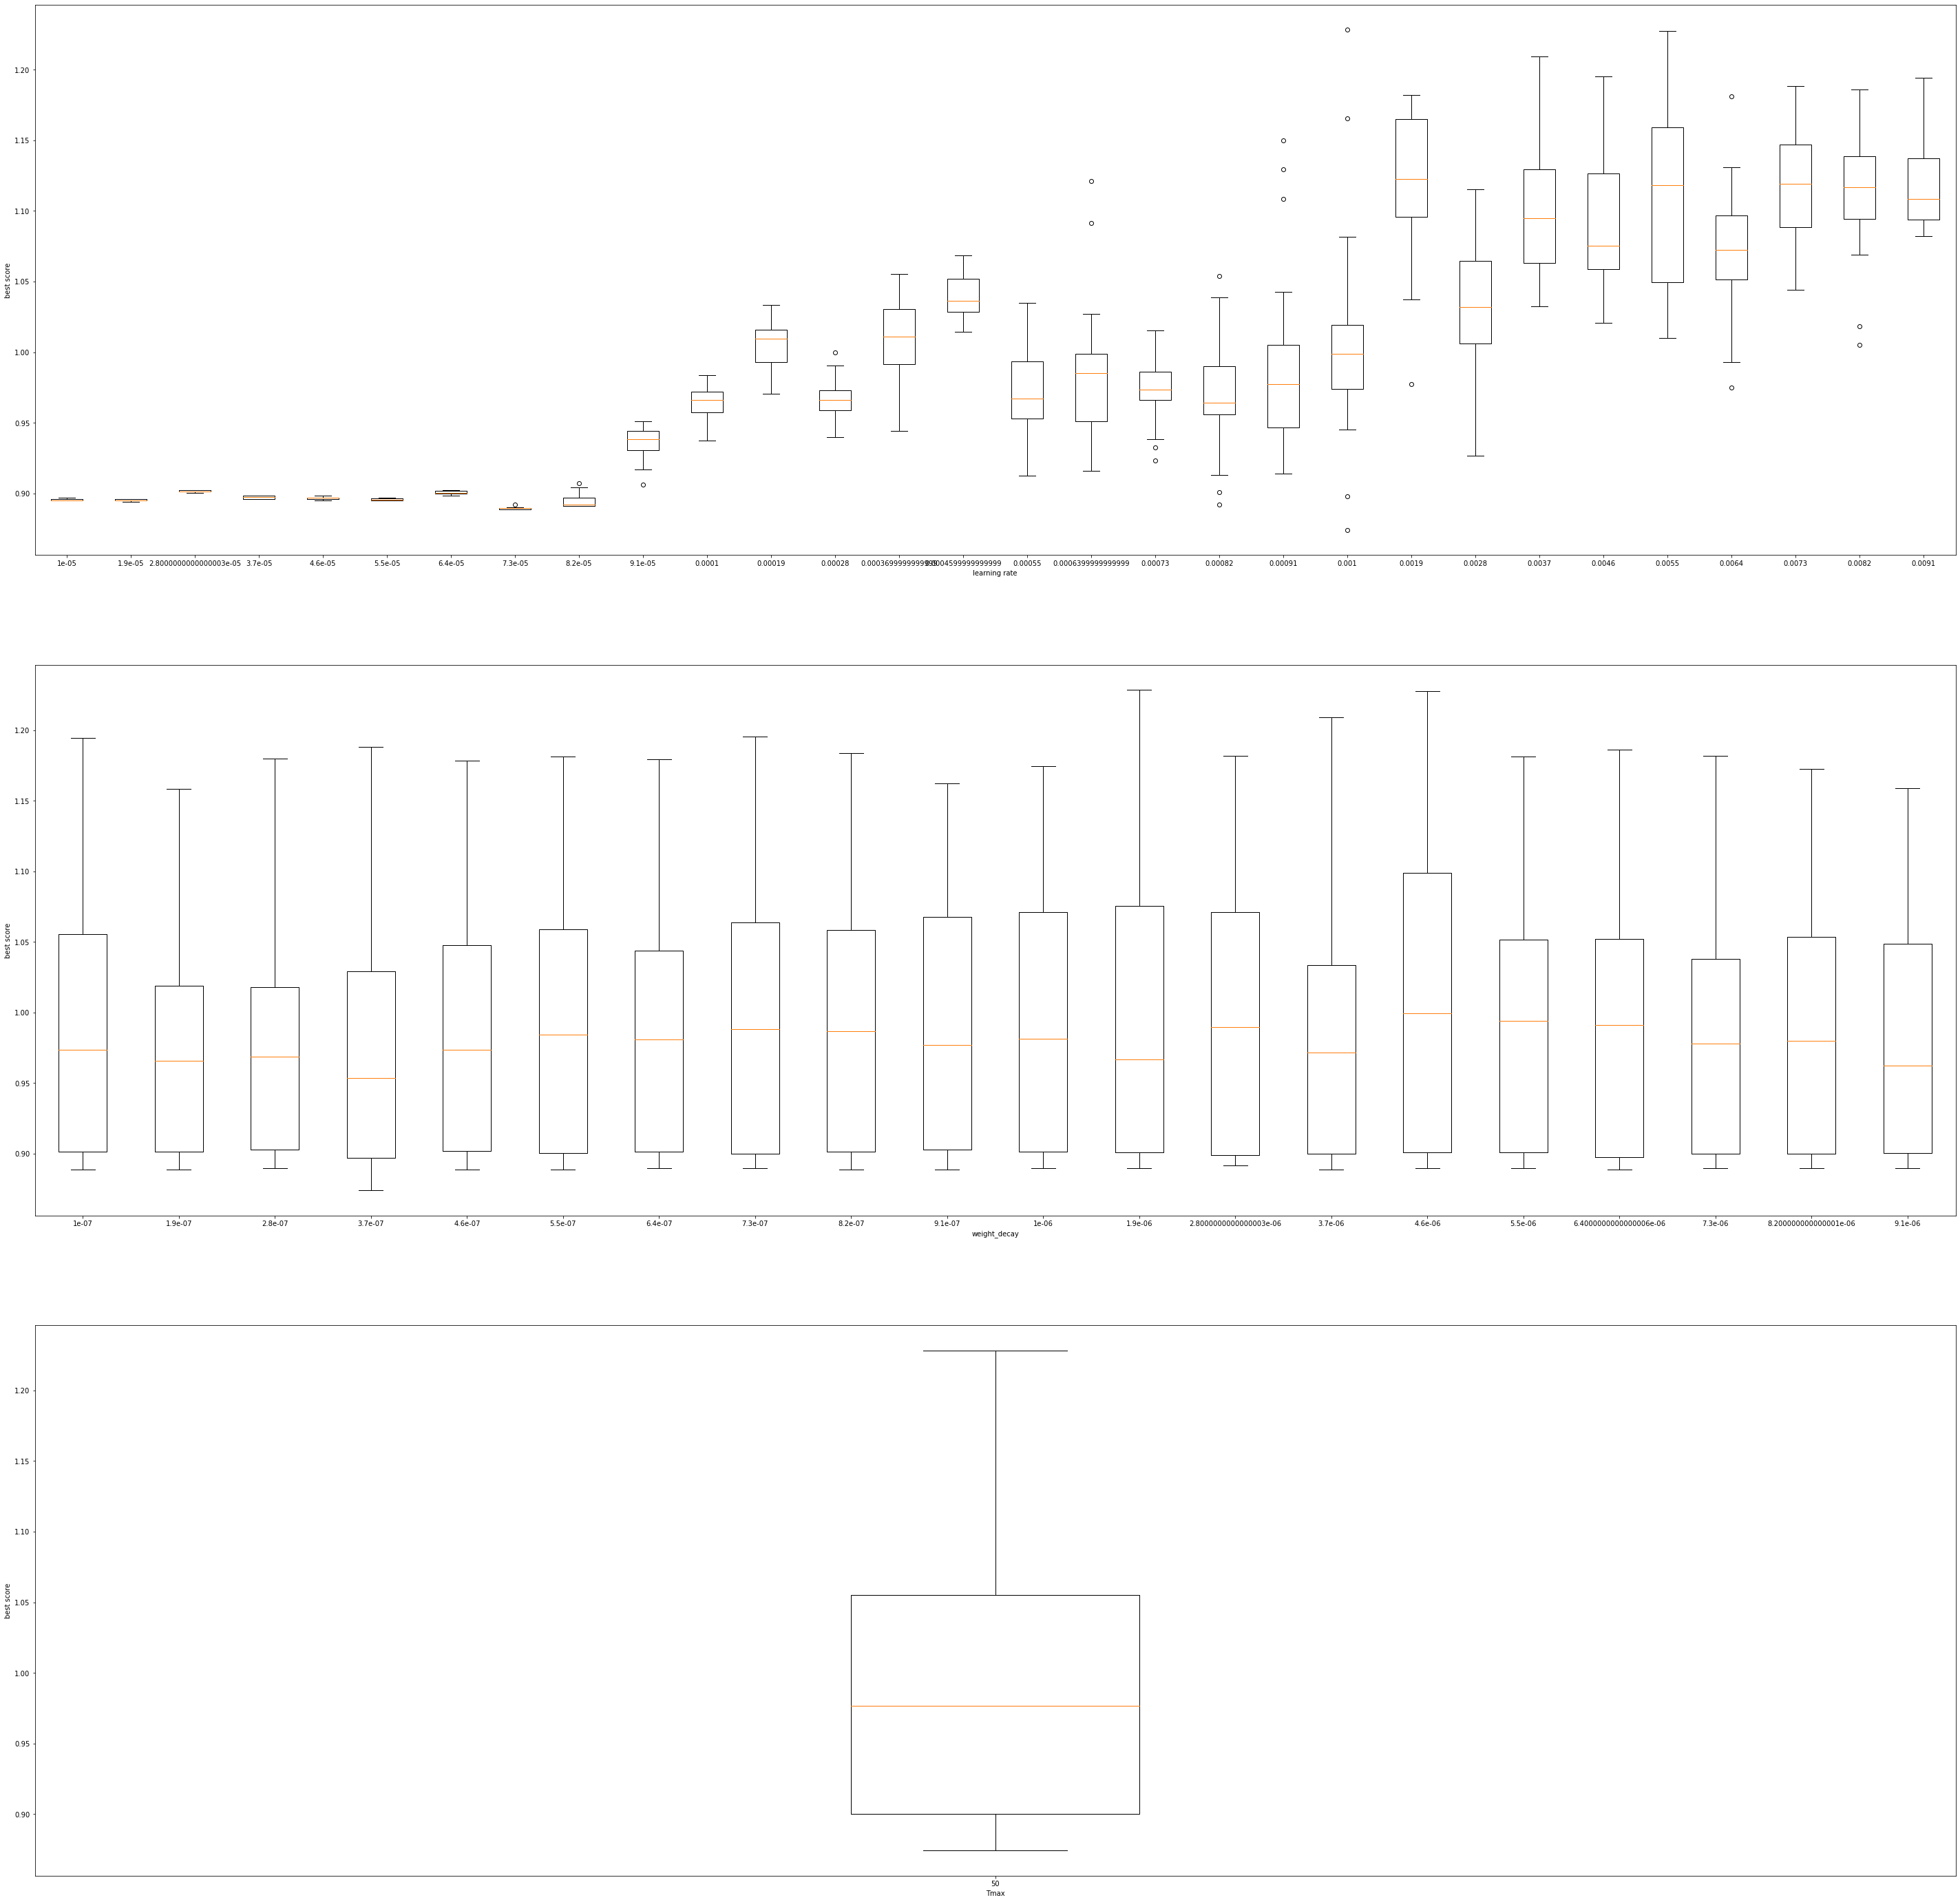

In [192]:
vis_best_metrics(result7,'best score',output=True)

# results of 2nd trial with pretrained resnet50 extracted data, 8th run(run on server)

count    200.000000
mean       0.768943
std        0.095478
min        0.443750
25%        0.726562
50%        0.802083
75%        0.838021
max        0.900000
Name: best auc, dtype: float64


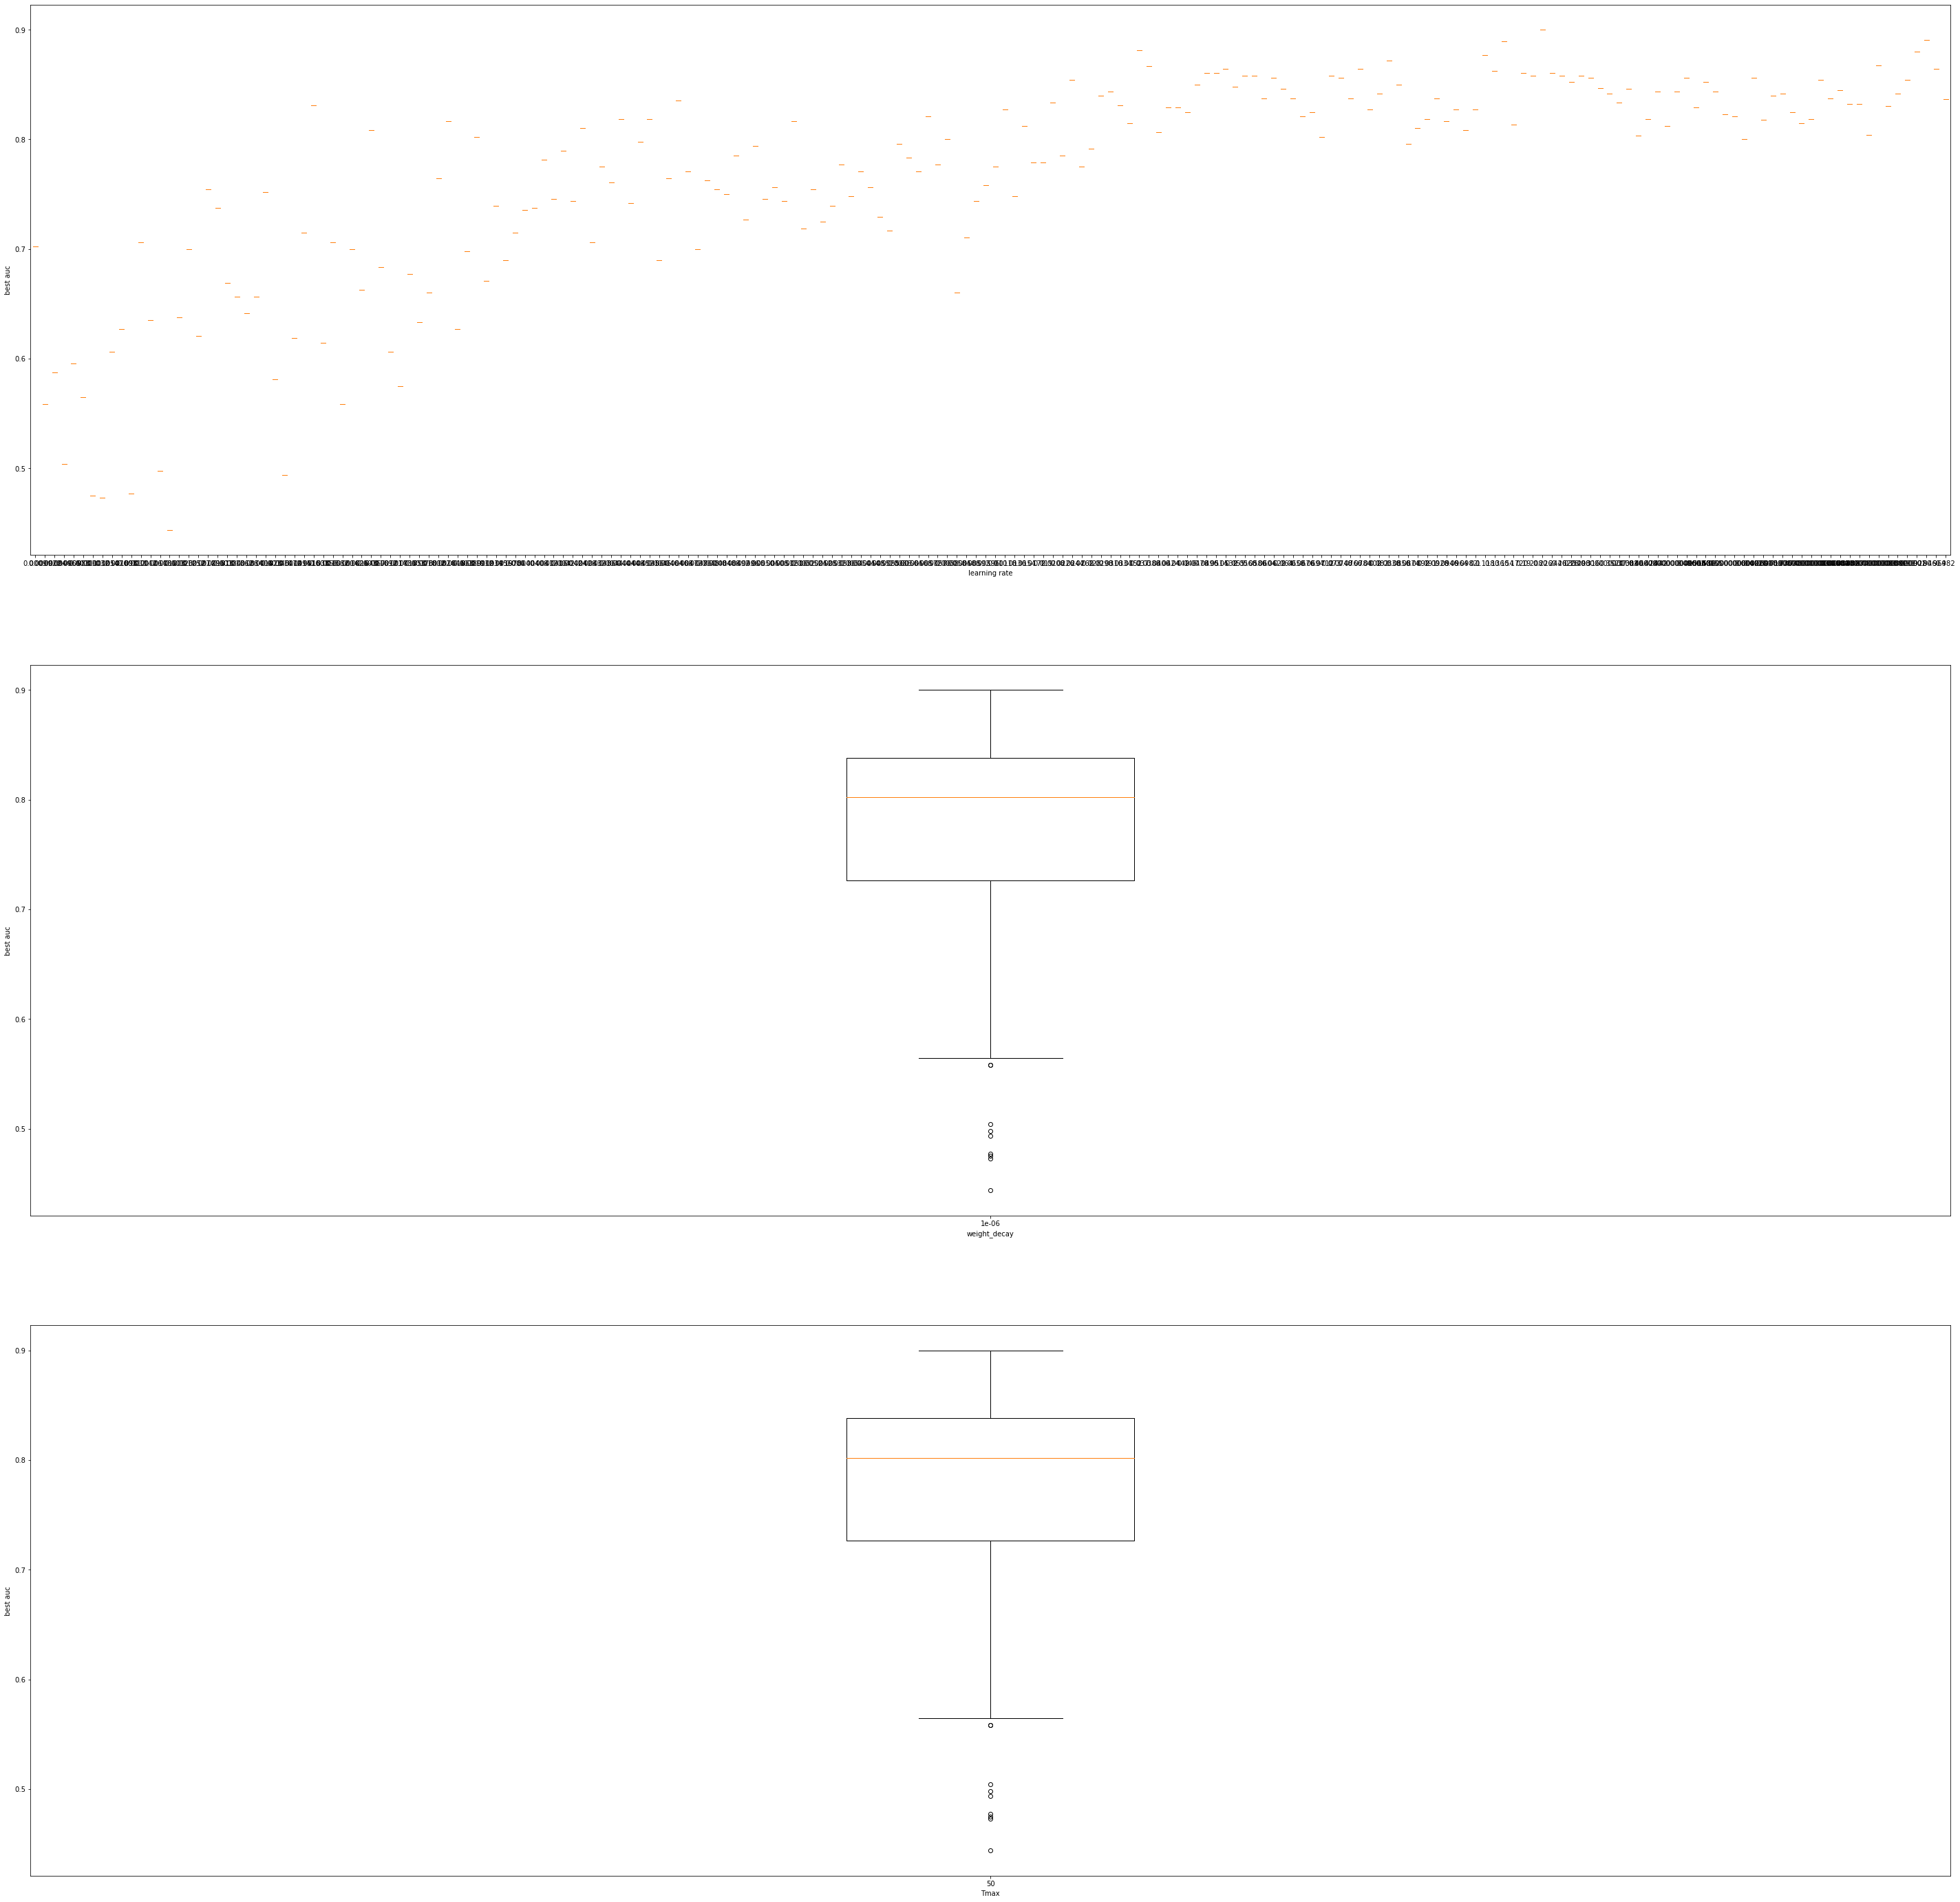

In [59]:
result8 = reader('./mil classifier/hyperparam_select_batch_8')
vis_best_metrics(result8,'best auc')

count    200.000000
mean       1.135110
std        0.076553
min        0.879741
25%        1.083782
50%        1.154346
75%        1.189260
max        1.296947
Name: best score, dtype: float64


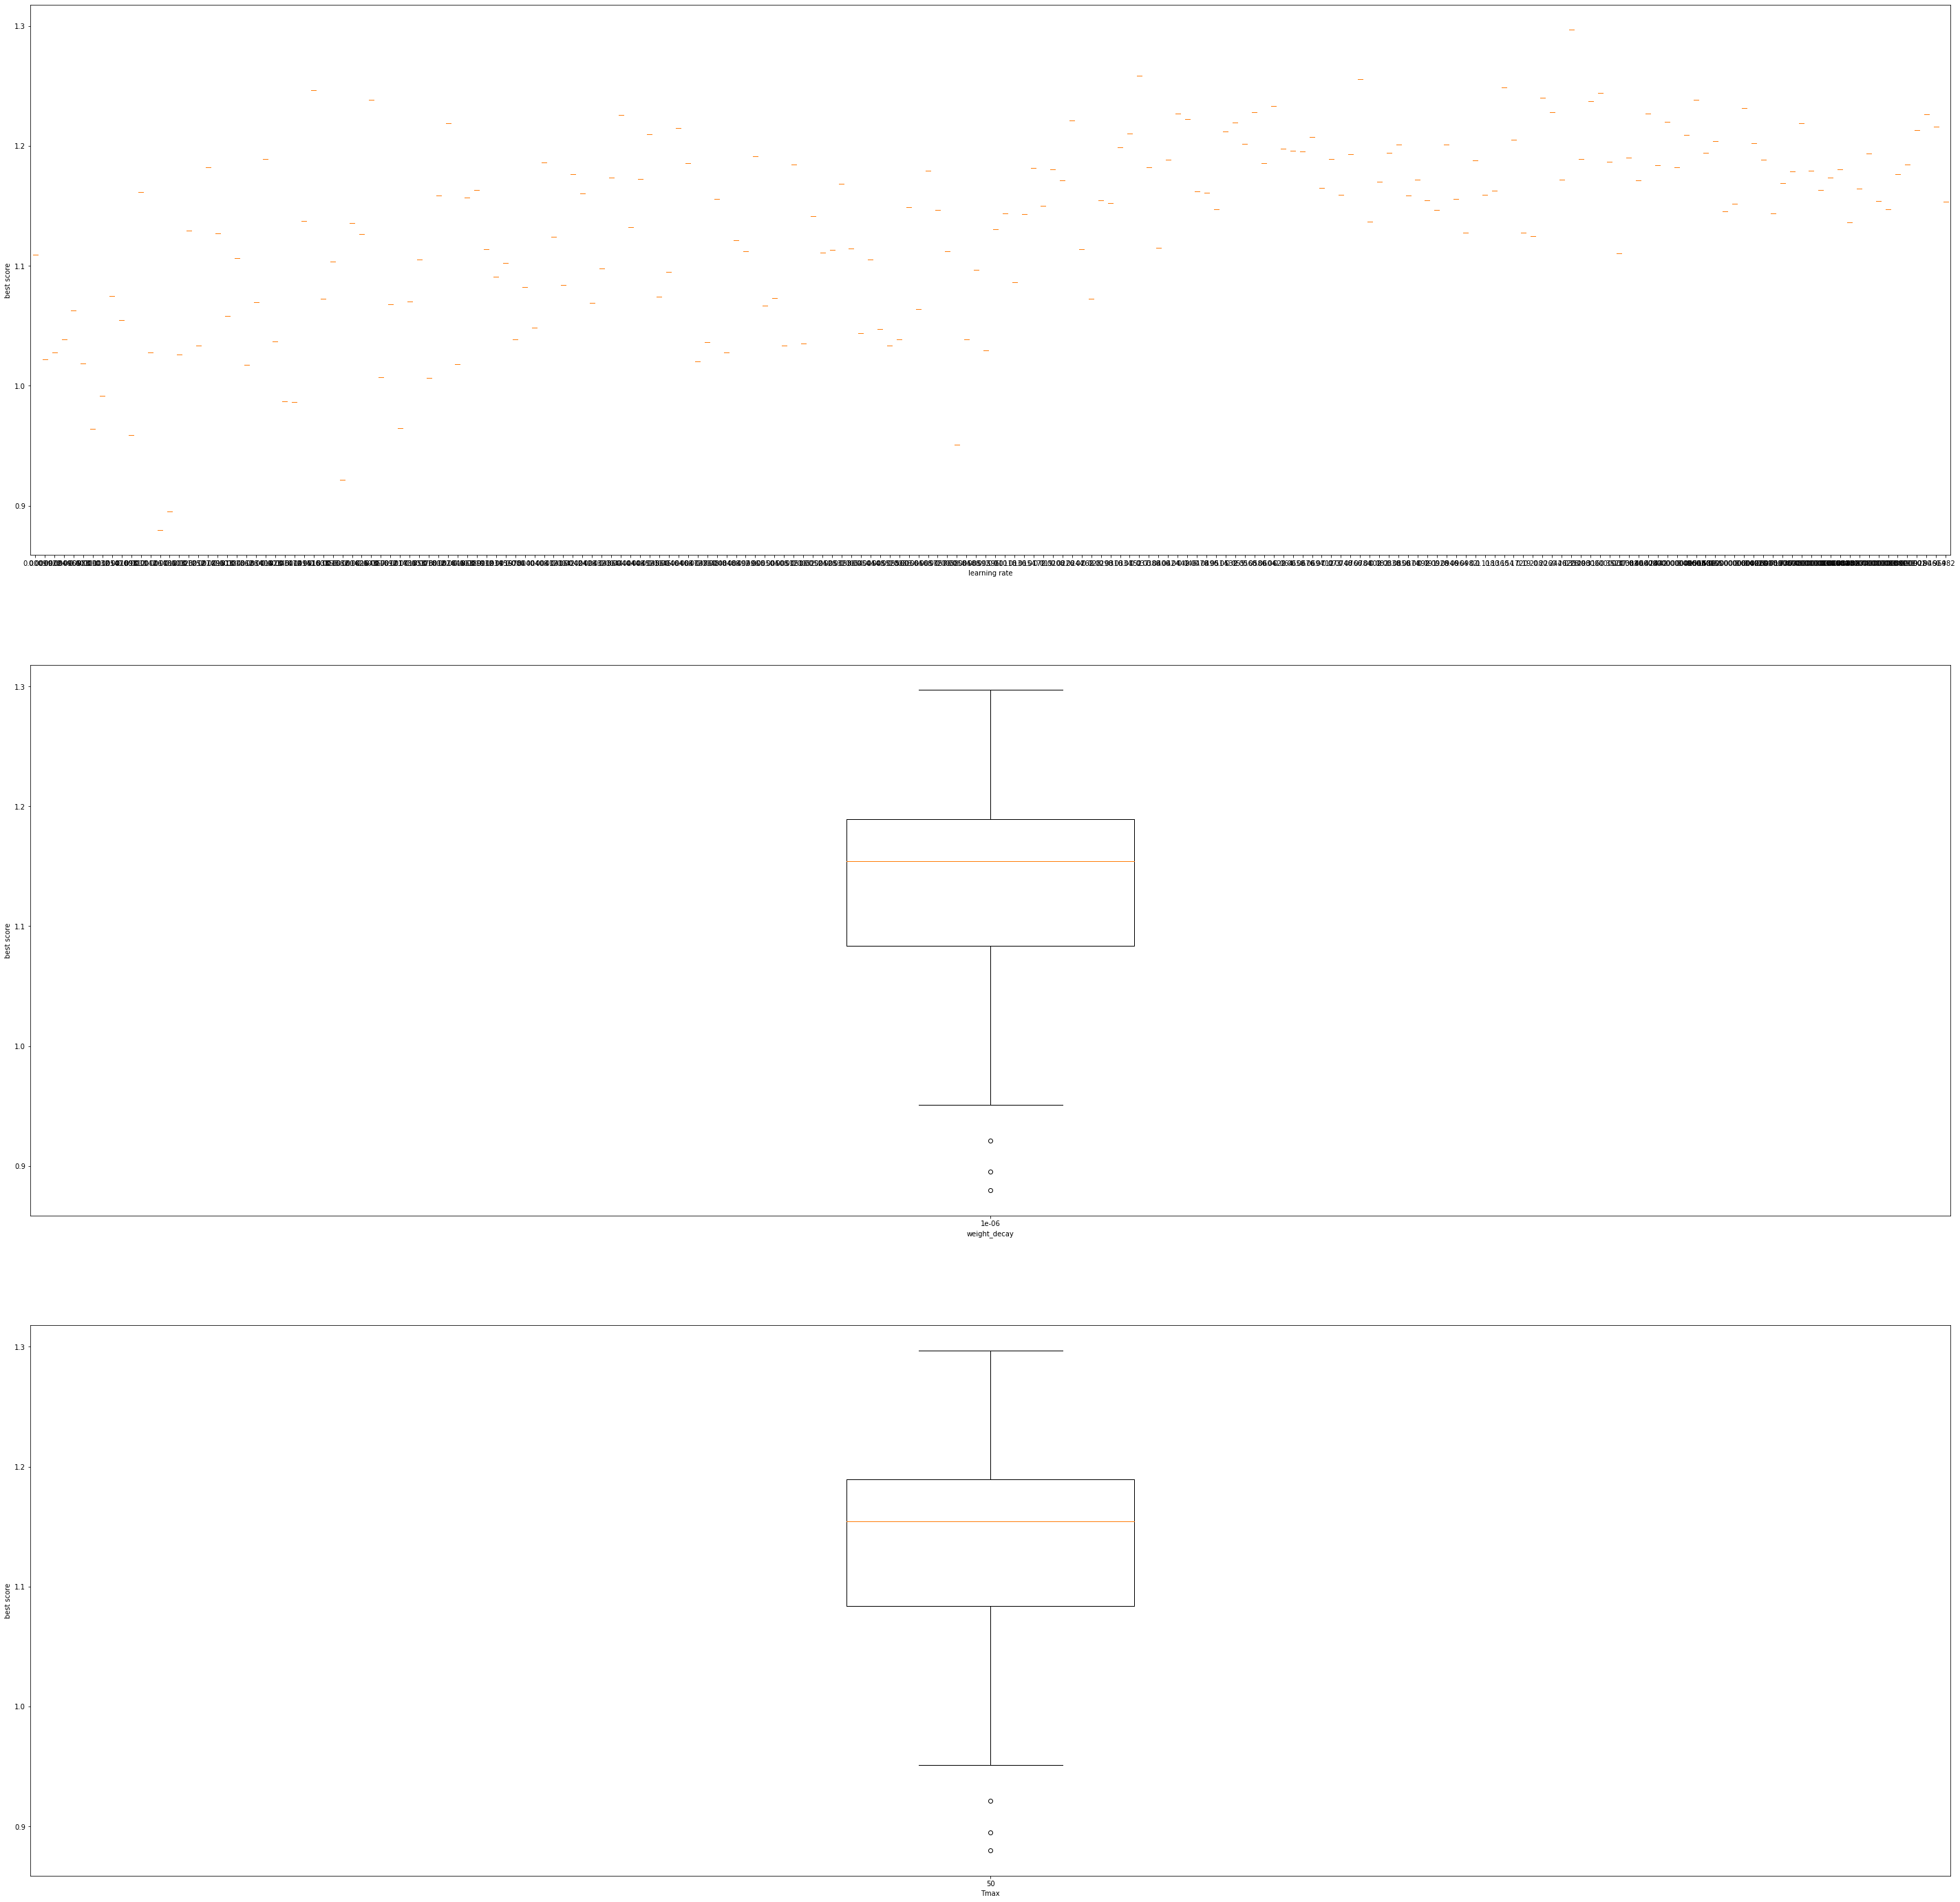

In [60]:
vis_best_metrics(result8,'best score',output=True)

count    200.000000
mean       1.579594
std        0.125553
min        1.183333
25%        1.508333
50%        1.625000
75%        1.669271
max        1.772917
Name: best avg auc, dtype: float64


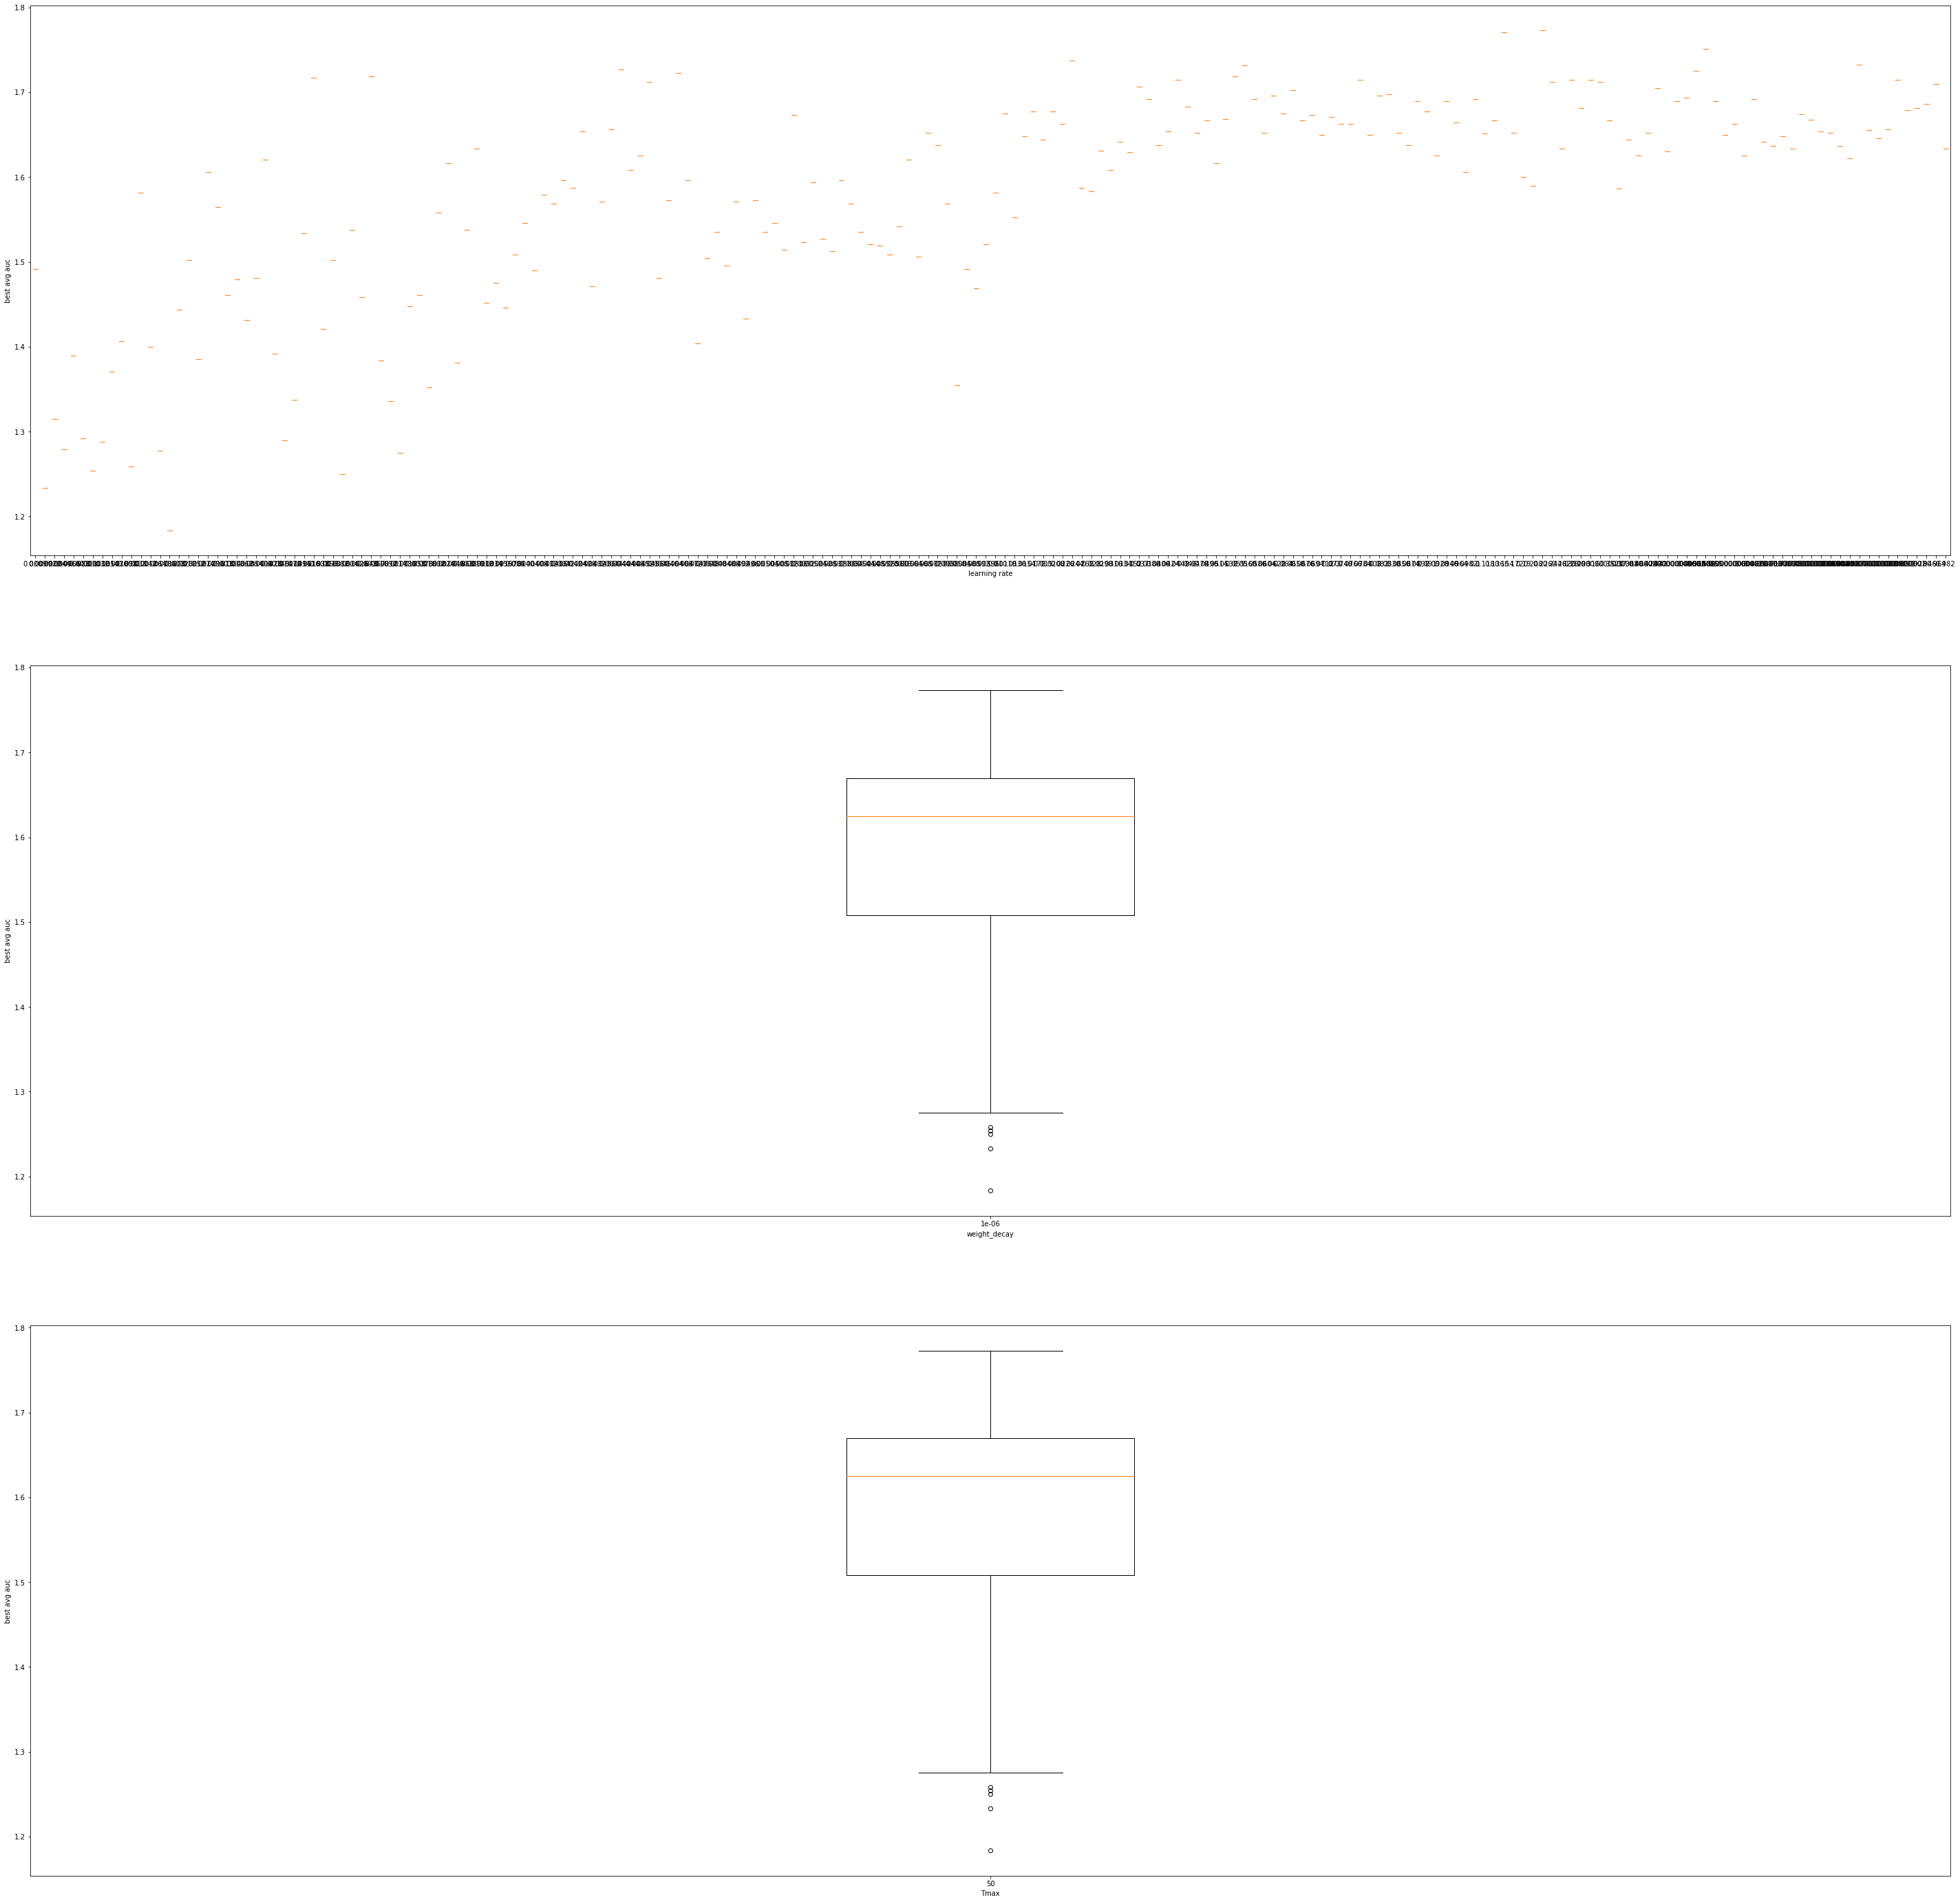

In [61]:
vis_best_metrics(result8,'best avg auc')

In [ ]:
top_comb(results=result8,metrics='best auc')

# results of 3rd trial with pretrained resnet50 extracted data, 10th run(run on server)

In [71]:
result10 = reader('./mil classifier/hyperparam_select_batch_10')

count    50.000000
mean      0.439708
std       0.011967
min       0.416667
25%       0.431771
50%       0.439583
75%       0.447917
max       0.468750
Name: best auc, dtype: float64


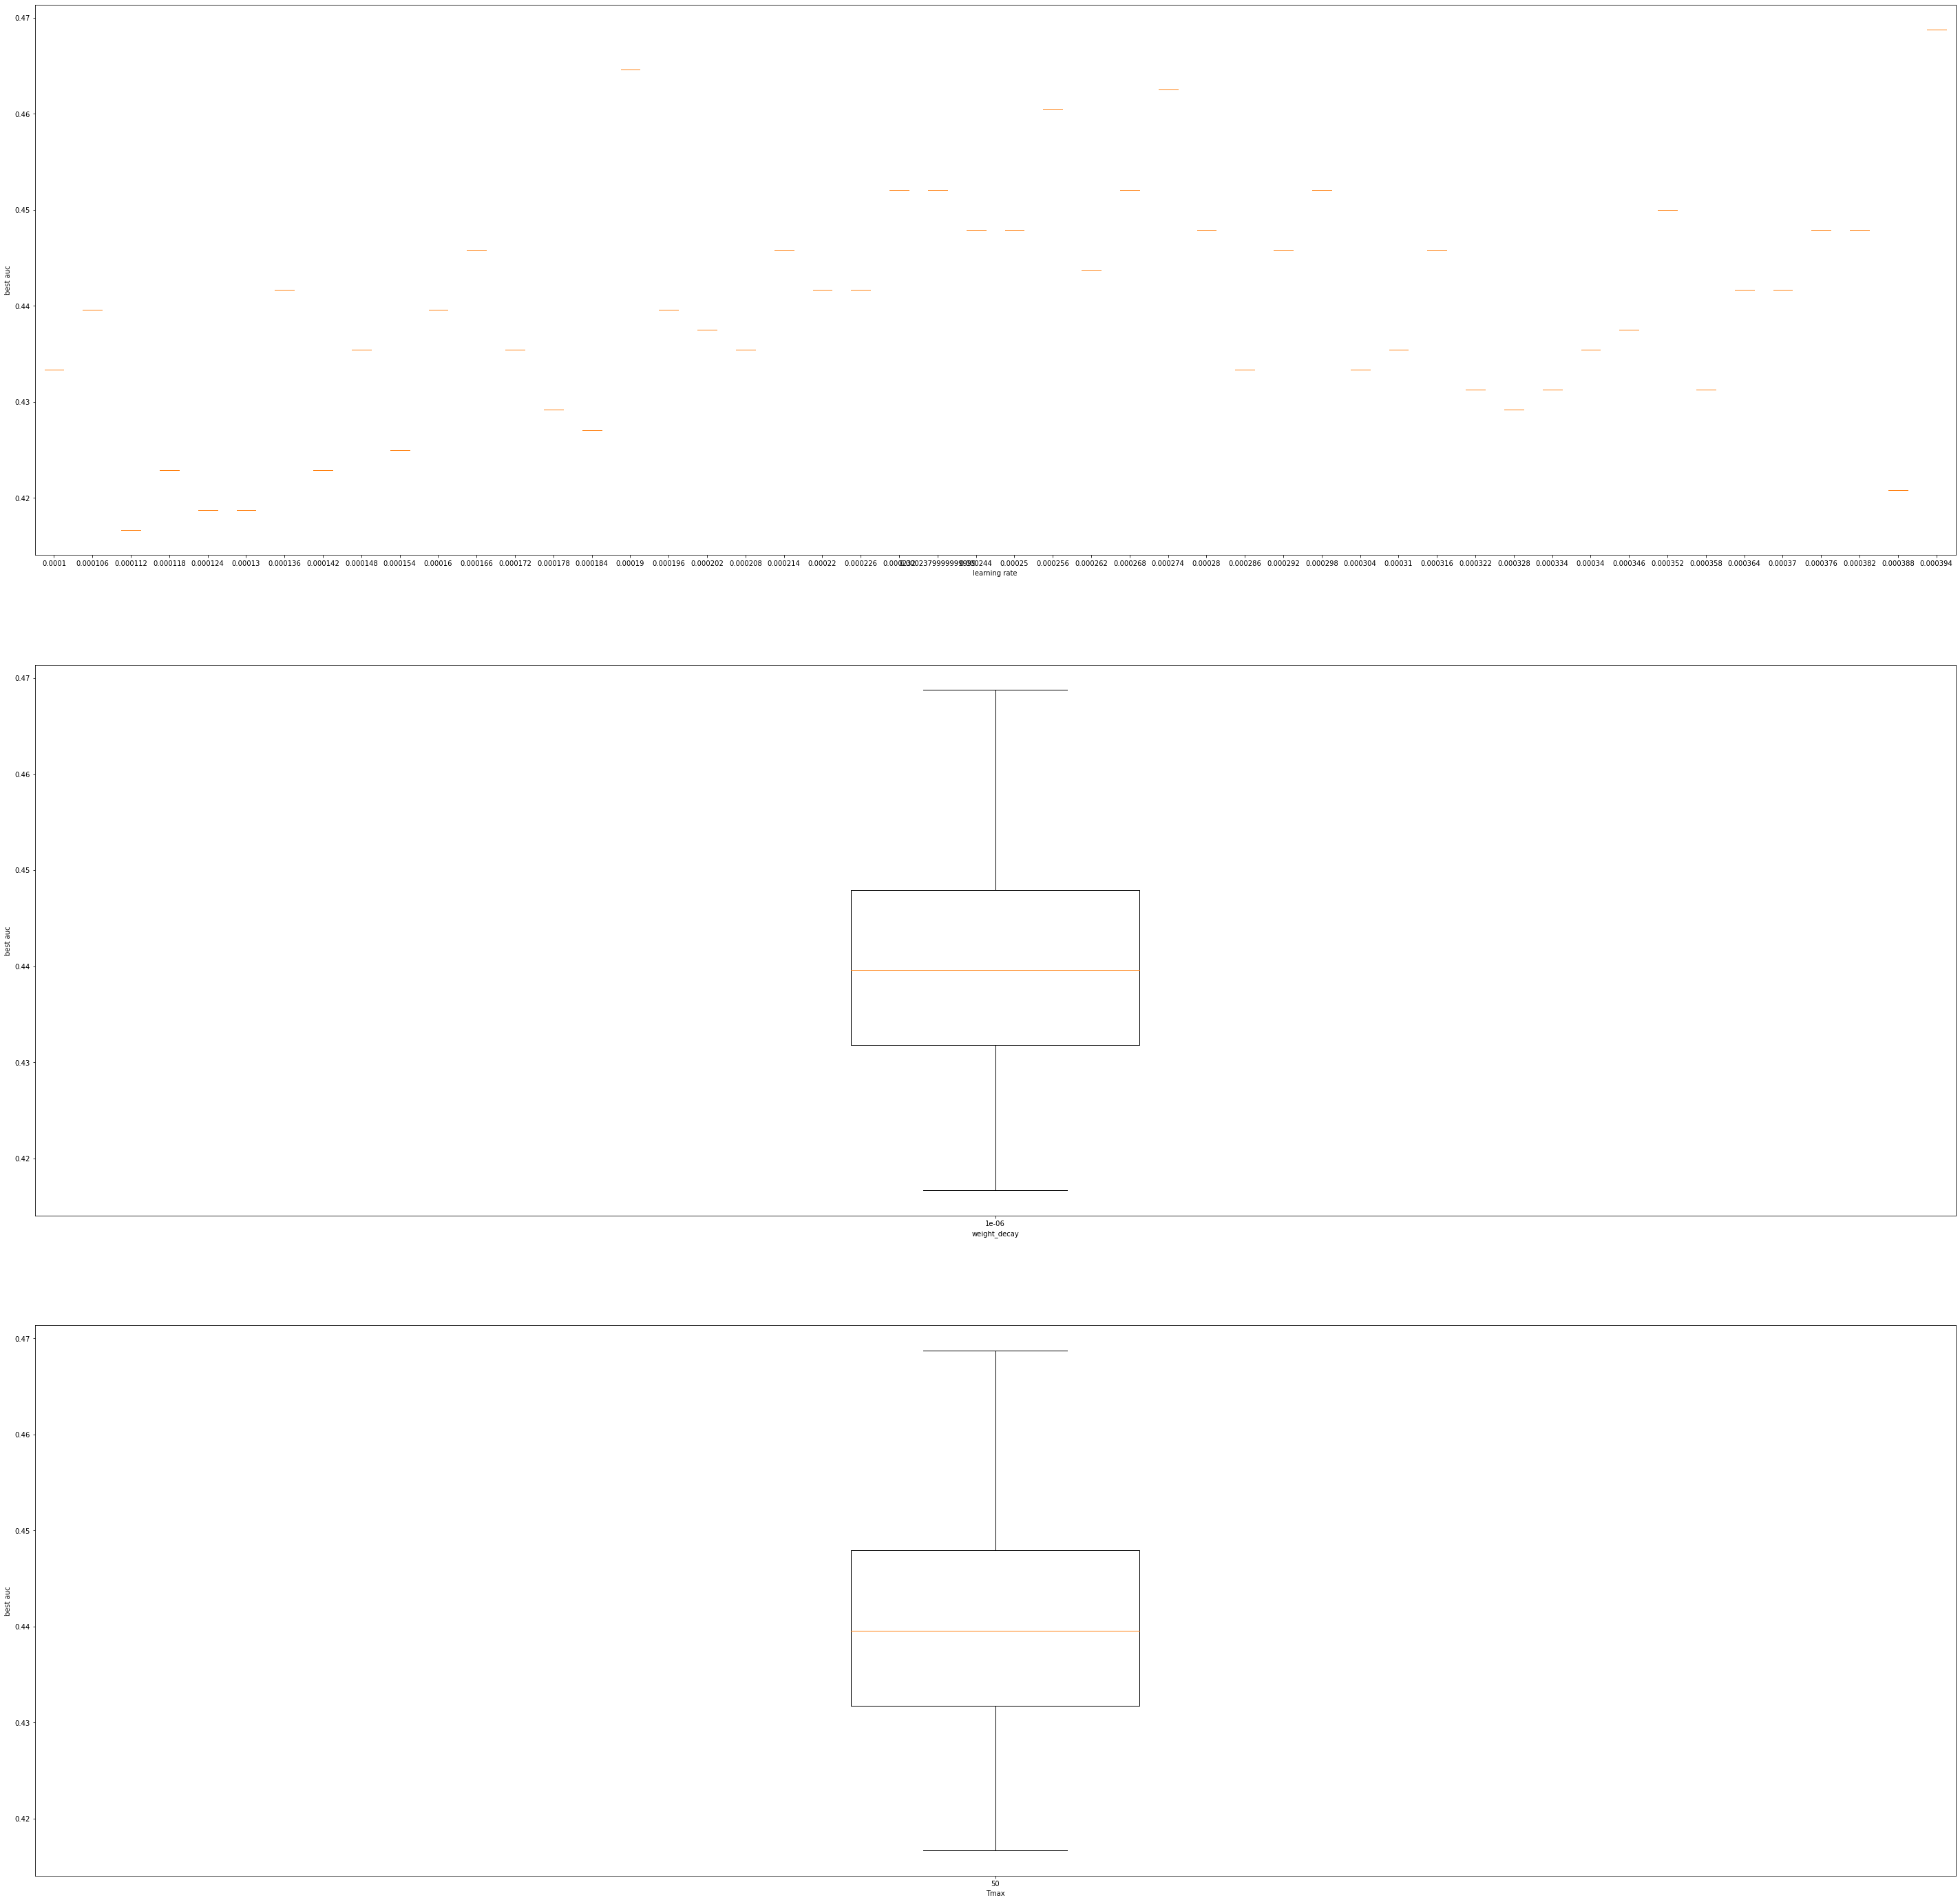

In [73]:
vis_best_metrics(result10,'best auc')

# 查看不同feature extractor在dsmil分类器中经过fine tuning之后的表现

pic saved at :/out/5_classifier/classifier_comparison/simclr.png


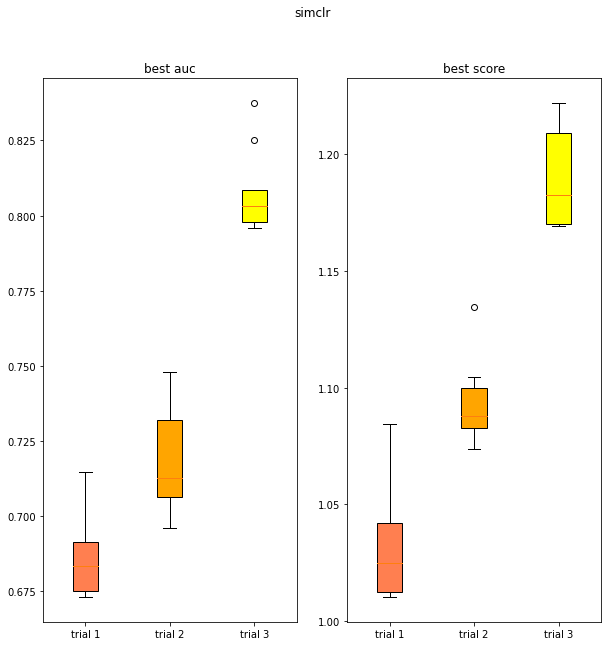

In [47]:
view_boosting([result,result2,result3],figsize=(10,10),title='simclr',output=True)

pic saved at :/out/5_classifier/classifier_comparison/pretrained Res18.png


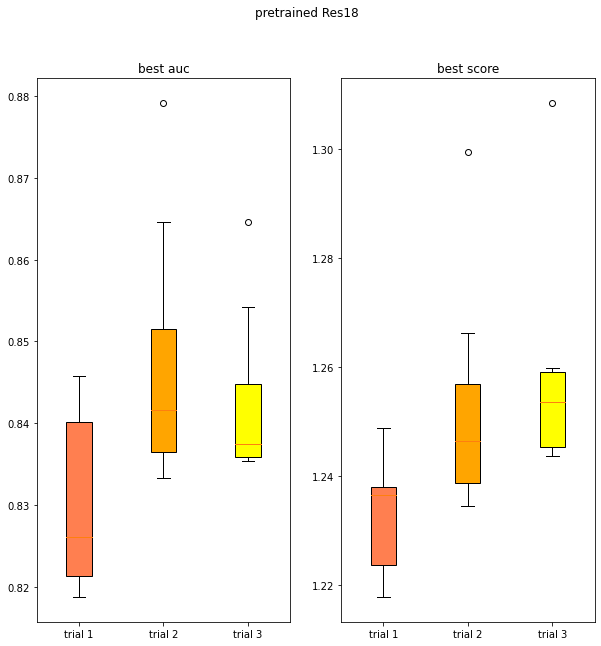

In [48]:
view_boosting([result4,result5,result6],figsize=(10,10),title='pretrained Res18',output=True)

pic saved at :/out/5_classifier/classifier_comparison/pretrained res50.png


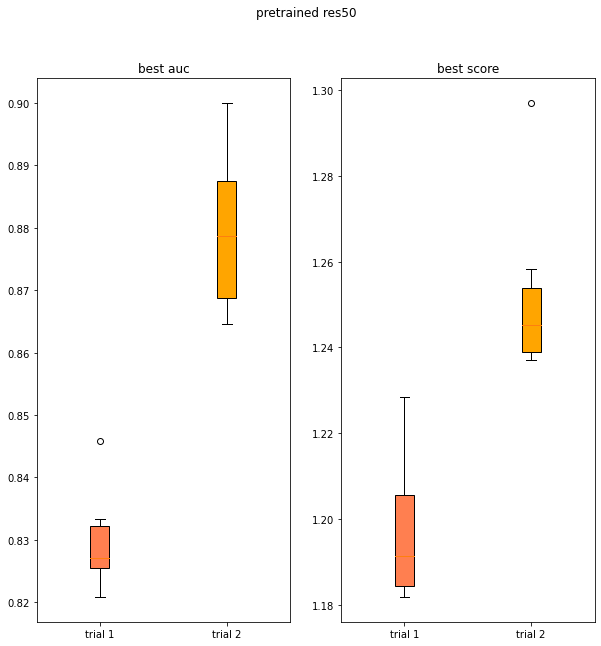

In [65]:
view_boosting([result7,result8],figsize=(10,10),title='pretrained res50',output=True)

In [ ]:
result.sort_values(['best auc'],ascending = False).head(10)